In [1]:
!pip install visualkeras ; 
import visualkeras 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 1.1 MB/s eta 0:00:00


### Import libraries

In [2]:
import tensorflow as tf
import numpy as np
import os
import shutil
import random
import glob
import imageio
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns #visualization 
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


### Set seed for reproducibility

In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Load and process data

In [5]:
(X_train_val, y_train_val), (X_test, y_test) = tfk.datasets.fashion_mnist.load_data()  ; #from zalando 
X = np.concatenate([X_train_val,X_test],axis=0)
X = np.expand_dims(((X-127.5)/127.5),axis=-1).astype('float32') #-1, 1 normalization 
# we have an hyperbolic tangent as output (-1, 1)
y = np.concatenate([y_train_val,y_test],axis=0)
X.shape, y.shape

# there is no technique to evaluate GAN, understanding if if overfits is difficult 
# IDEA: more training means more information means more generation  

4431872/4422102 [==============================] - 1s 0us/step


((70000, 28, 28, 1), (70000,))

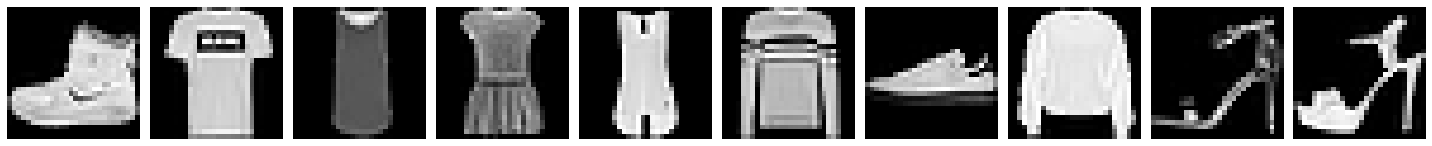

In [6]:
# Inspect the data
fig, axes = plt.subplots(1, 10, figsize=(20,10))
for i in range(10):
    ax = axes[i%10]
    ax.imshow(np.squeeze(X[i]), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [7]:
print('Data shape', X.shape)
print('Data min {:0.2f}\nData max {:0.2f}\nData mean {:0.2f}\nData std {:0.2f}'.format(
    X.min(), X.max(), X.mean(), X.std()))
# TRADE OFF between bounds (fixed) vs good mean, stdv

Data shape (70000, 28, 28, 1)
Data min -1.00
Data max 1.00
Data mean -0.43
Data std 0.71


In [8]:
input_shape = X.shape[1:]
input_shape

(28, 28, 1)

### Vanilla Generative Adversarial Network

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
padding (ZeroPadding2D)      (None, 32, 32, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 64)        640       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 16, 16, 64)        256       
_________________________________________________________________
activation1 (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 8, 8, 128)         73856     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 8, 8, 128)       

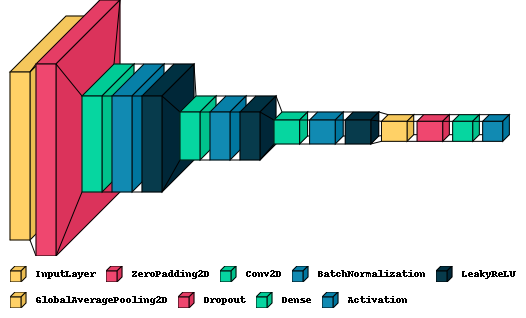

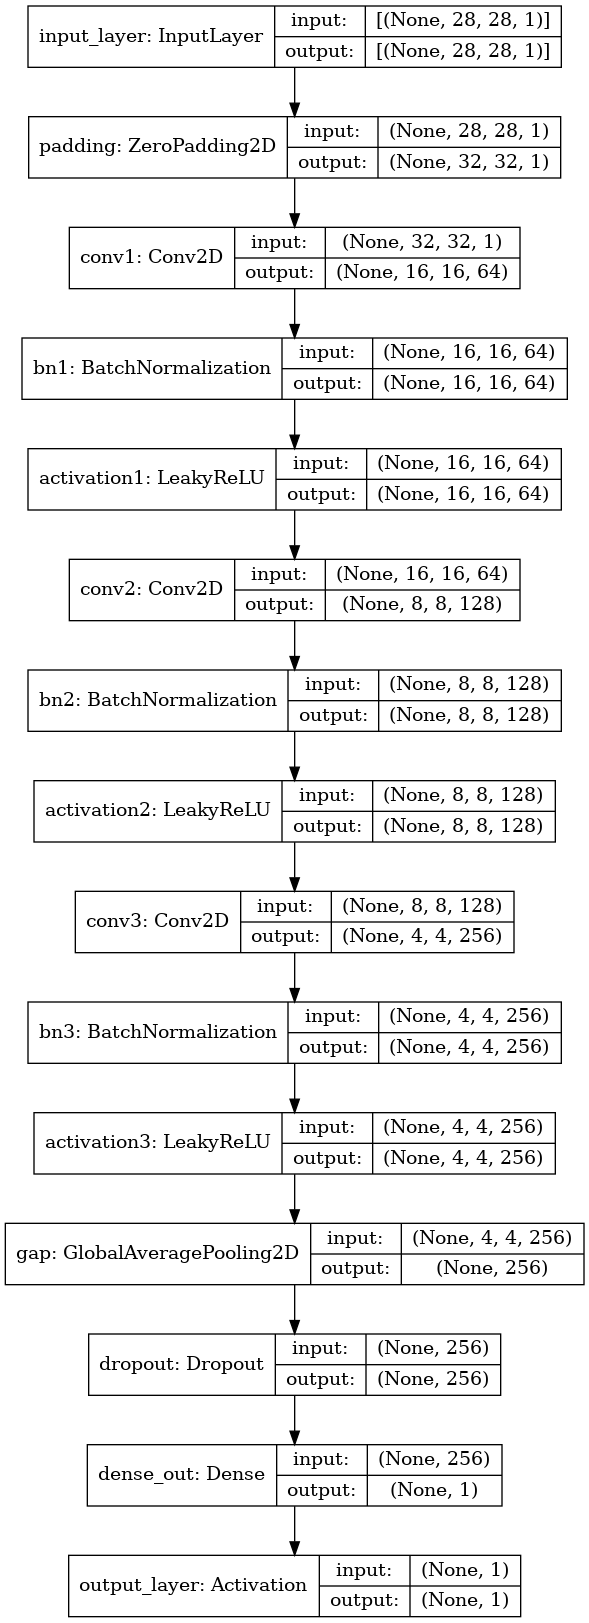

In [9]:
def get_dc_discriminator(input_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the discriminator layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.ZeroPadding2D((2,2), name='padding')(input_layer) #for commodity because of dimension (we want to work with 32x32) but pics in input are 28x28

    x = tfkl.Conv2D(64, 3, padding='same', strides=2, name='conv1')(x)
    x = tfkl.BatchNormalization(name='bn1')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)

    x = tfkl.Conv2D(128, 3, padding='same', strides=2, name='conv2')(x)
    x = tfkl.BatchNormalization(name='bn2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)

    x = tfkl.Conv2D(256, 3, padding='same', strides=2, name='conv3')(x)
    x = tfkl.BatchNormalization(name='bn3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    x = tfkl.Dropout(.5, seed=seed, name='dropout')(x)
    x = tfkl.Dense(1, name='dense_out')(x)
    output_layer = tfkl.Activation('sigmoid', name='output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='discriminator')
    #NW: model is not compiled, we have no loss,no metrics etc 
    # Return the discriminator
    return model
discriminator = get_dc_discriminator(input_shape)
discriminator.summary()
display(visualkeras.layered_view(discriminator, legend=True, scale_xy=6))
tfk.utils.plot_model(discriminator, show_shapes=True, expand_nested=True, to_file='vanilla_discriminator.png')

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128)]             0         
_________________________________________________________________
dense0 (Dense)               (None, 1024)              131072    
_________________________________________________________________
bn0 (BatchNormalization)     (None, 1024)              4096      
_________________________________________________________________
activation0 (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
upsampling1 (UpSampling2D)   (None, 8, 8, 64)          0         
_________________________________________________________________
conv1 (Conv2D)               (None, 8, 8, 64)          36

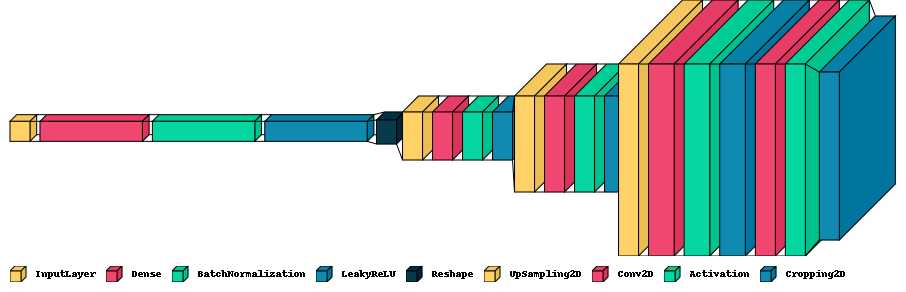

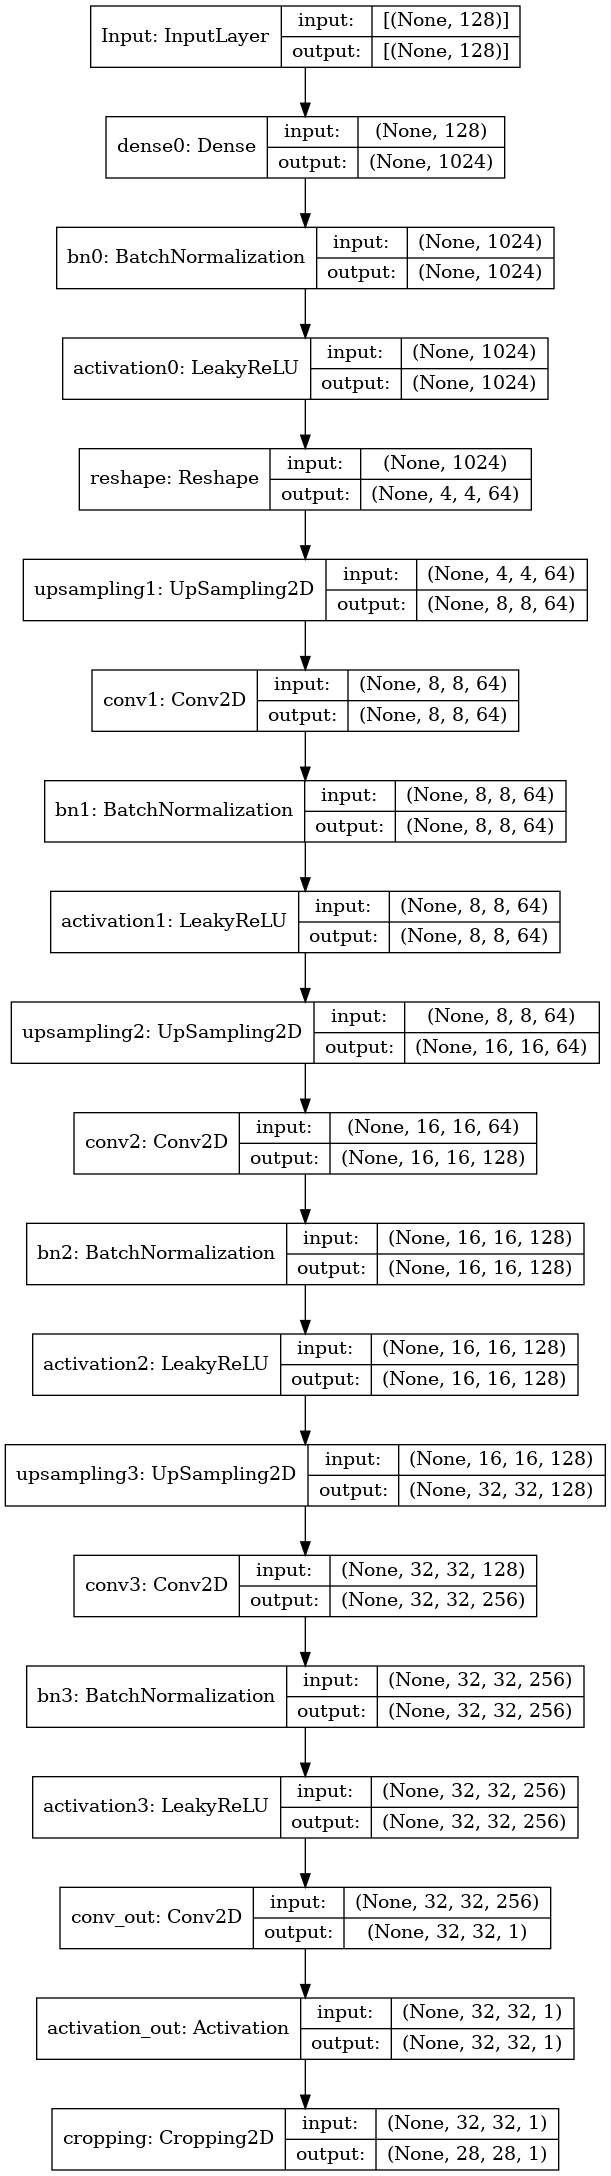

In [10]:
latent_dim = 128 #tunable, dimension of the input of the generator 
'''
The generator receives as input noise (128vector), it has to learn to generate samples belonging to the training set distribution. 
''' 

def get_dc_generator(input_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the generator layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Dense(4*4*64, use_bias=False, name='dense0')(input_layer)
    x = tfkl.BatchNormalization(name='bn0')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation0')(x)
    x = tfkl.Reshape((4,4,64))(x) #to make it working with conv 

    x = tfkl.UpSampling2D(name='upsampling1')(x)
    x = tfkl.Conv2D(64, 3, padding='same', use_bias=False, name='conv1')(x) # use_bias -> we remove the sum  (not mandatory) because 
    # we want to force generator to follow exactly the distribution in input, do not move y asix of each dimension 
    x = tfkl.BatchNormalization(name='bn1')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)

    x = tfkl.UpSampling2D(name='upsampling2')(x)
    x = tfkl.Conv2D(128, 3, padding='same', use_bias=False, name='conv2')(x)
    x = tfkl.BatchNormalization(name='bn2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)

    x = tfkl.UpSampling2D(name='upsampling3')(x)
    x = tfkl.Conv2D(256, 3, padding='same', use_bias=False, name='conv3')(x)
    x = tfkl.BatchNormalization(name='bn3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)

    x = tfkl.Conv2D(1, 3, padding='same', use_bias=False, name='conv_out')(x)
    x = tfkl.Activation('tanh', name='activation_out')(x) # bound the output in the range -1, 1 
    output_layer = tfkl.Cropping2D((2,2), name='cropping')(x) # 28 x 28 output (not 32 x 32)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='generator')

    # Return the model
    return model
generator = get_dc_generator(latent_dim)
generator.summary()
display(visualkeras.layered_view(generator, legend=True, scale_xy=6))
tfk.utils.plot_model(generator, show_shapes=True, expand_nested=True, to_file='vanilla_generator.png')

Now we check data flow, gradients computations, how the net is updated. 

In [11]:
'''
We particularize the class tfk.Model 
'''

class GAN(tfk.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

        self.loss_tracker = tfk.metrics.Mean(name="loss") #GAN 
        self.d_loss_tracker = tfk.metrics.Mean(name="d_loss") # Discriminator
        self.g_loss_tracker = tfk.metrics.Mean(name="g_loss") # we want to take the mean of this metrics 

    def compile(self, d_optimizer, g_optimizer):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    @property
    def metrics(self):
        return [
            self.loss_tracker,
            self.d_loss_tracker,
            self.g_loss_tracker
        ]
    # here labels are not used !
    @tf.function
    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0] # from here on we work in the batch dimension 
        z = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate fake images from z
        generated_images = self.generator(z)

        # Combine generated images and real ones
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Create labels so that fake images correspond to class 0 and real images to class 1
        labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)
        

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = tf.reduce_mean(tfk.losses.binary_crossentropy(labels, predictions)) # for each sample we only want one update
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights)) # the gradient will only we computed wrt to these w 

        loss = d_loss

        # Sample random points in the latent space
        z = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Create misleading labels for fake images so that they correspond to class 1
        misleading_labels = tf.ones((batch_size, 1)) #ZERO SUM GAME 
        # this row is the core of the model as we label as real images generated from fake dist

        # Train the generator 
        with tf.GradientTape() as tape: # apply operations in the scope 
            misleading_predictions = self.discriminator(self.generator(z)) #here we put generator inside as we want to update it
            # we want to MAXIMIZE the error of the discriminator, so we say the data is real but in reality we are using the generator 
            # to generate it 
            g_loss = tf.reduce_mean(tfk.losses.binary_crossentropy(misleading_labels, misleading_predictions))
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        loss += g_loss #just to know what global loss is like, in general d_loss and g_loss are enough 

        # Update metrics
        self.loss_tracker.update_state(loss)
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            "loss": self.loss_tracker.result(),
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }

In [12]:
class GANMonitor(tfk.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=latent_dim, name='', gray=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.name = name
        self.gray = gray

    def on_epoch_end(self, epoch, logs=None):
        tf.random.set_seed(seed)
        os.makedirs(self.name+'temp', exist_ok=True)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors).numpy()

        fig, axes = plt.subplots(1, self.num_img, figsize=(20,self.num_img))
        for i in range(self.num_img):
            img = tfk.preprocessing.image.array_to_img(generated_images[i])
            ax = axes[i%self.num_img]
            if self.gray:
                ax.imshow(np.squeeze(img), cmap='gray')
            else:
                ax.imshow(np.squeeze(img))
            ax.axis('off')
        fig.savefig(self.name+'temp/'+'{:0>5}'.format(epoch)+'.png') 
        plt.tight_layout()
        plt.show()

    def on_train_end(self, logs=None):
        fp_in = self.name+"temp/*.png"
        fp_out = self.name+"_generated_images.gif"
        imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
        img = next(imgs)
        img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=100, optimize=False)    
        shutil.rmtree(self.name+"temp")

In [13]:
epochs = 100
learning_rate = 5e-5 #GOLDEN RULE : no convergence? reduce the learning rate 
batch_size = 128

In [14]:
gan = GAN(
    discriminator = get_dc_discriminator(input_shape), 
    generator = get_dc_generator(latent_dim), 
    latent_dim = latent_dim
)
gan.compile(
    d_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate)
)

In [15]:
'''
fixed to have always the same noise, by default as you want to see same 
image every time -> do not change the noise in input 
'''
def sample(model, num_img, latent_dim, fixed=True, gray=False):
    if fixed:
        tf.random.set_seed(seed)
    z = tf.random.normal(shape=(num_img, latent_dim))
    generated_images = model(z).numpy()

    fig, axes = plt.subplots(1, num_img, figsize=(20,num_img))
    for i in range(num_img):
        img = tfk.preprocessing.image.array_to_img(generated_images[i])
        ax = axes[i%num_img]
        if gray:
            ax.imshow(np.squeeze(img), cmap='gray')
        else:
            ax.imshow(np.squeeze(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def generate_dataset(model, num_img, latent_dim, fixed=True):
    if fixed:
        tf.random.set_seed(seed)
    z = tf.random.normal(shape=(num_img, latent_dim))
    generated_images = model(z).numpy()
    return generated_images

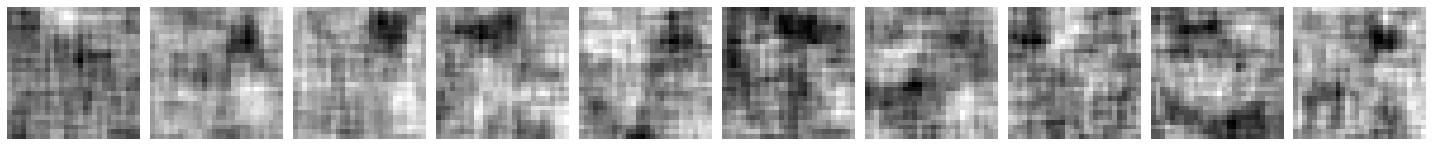

In [16]:
sample(gan.generator, 10, latent_dim, fixed=False, gray=True)

Epoch 1/100
547/547 - 28s - loss: 1.4773 - d_loss: 0.6593 - g_loss: 0.8180


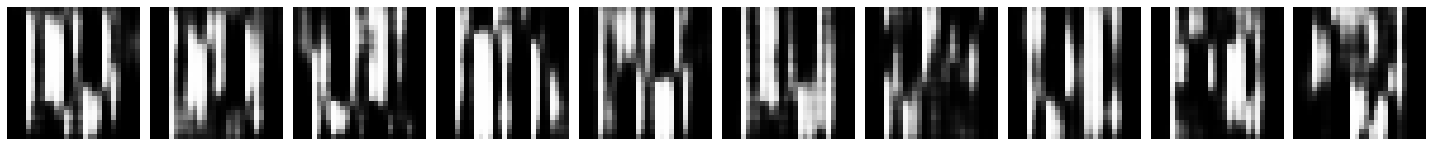

Epoch 2/100
547/547 - 25s - loss: 1.5115 - d_loss: 0.6641 - g_loss: 0.8474


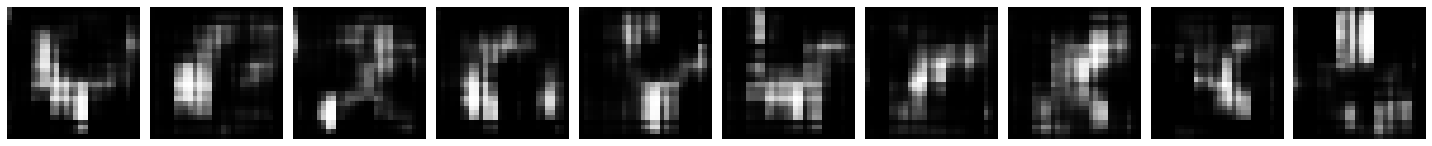

Epoch 3/100
547/547 - 25s - loss: 1.3909 - d_loss: 0.6938 - g_loss: 0.6971


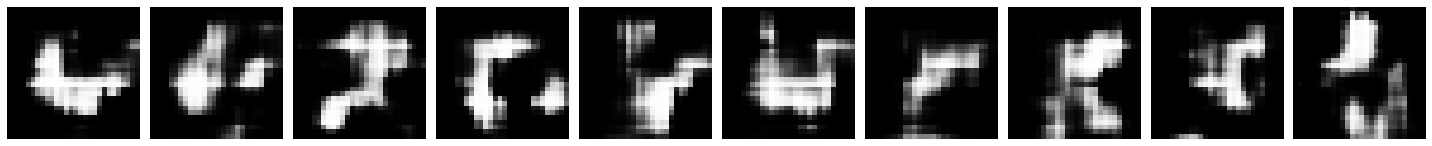

Epoch 4/100
547/547 - 25s - loss: 1.4238 - d_loss: 0.6754 - g_loss: 0.7485


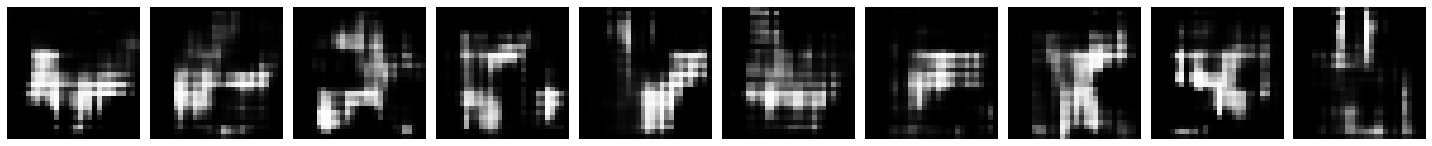

Epoch 5/100
547/547 - 25s - loss: 1.4188 - d_loss: 0.6835 - g_loss: 0.7354


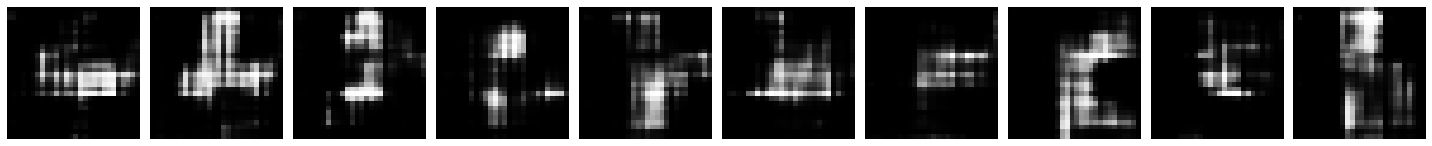

Epoch 6/100
547/547 - 25s - loss: 1.4150 - d_loss: 0.6836 - g_loss: 0.7314


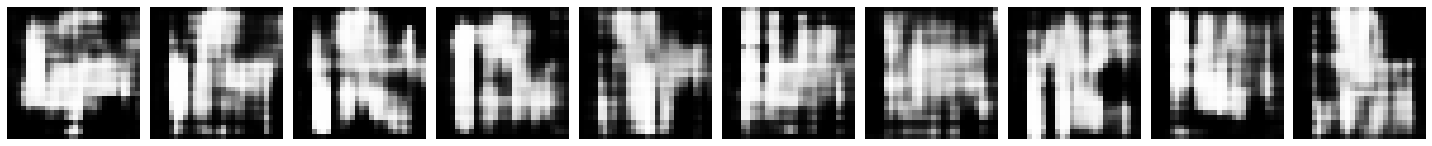

Epoch 7/100
547/547 - 25s - loss: 1.4119 - d_loss: 0.6717 - g_loss: 0.7402


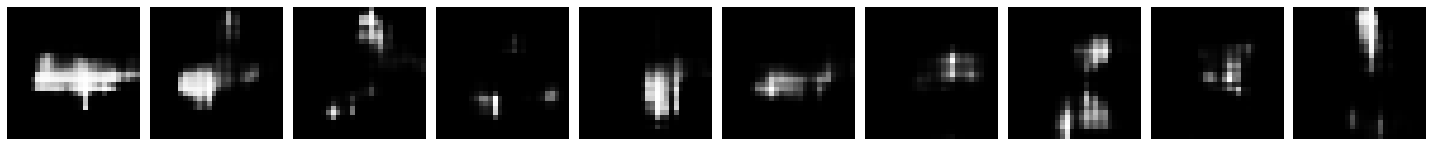

Epoch 8/100
547/547 - 25s - loss: 1.4179 - d_loss: 0.6807 - g_loss: 0.7373


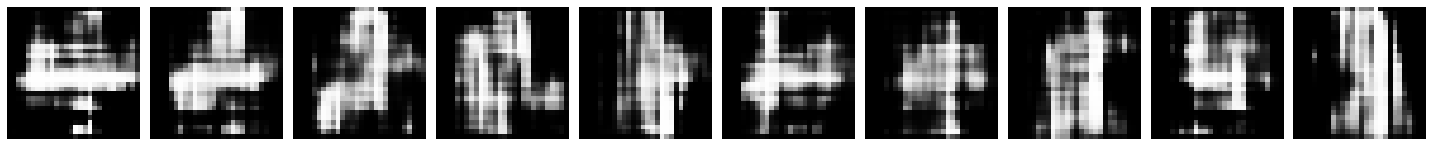

Epoch 9/100
547/547 - 25s - loss: 1.4917 - d_loss: 0.6690 - g_loss: 0.8227


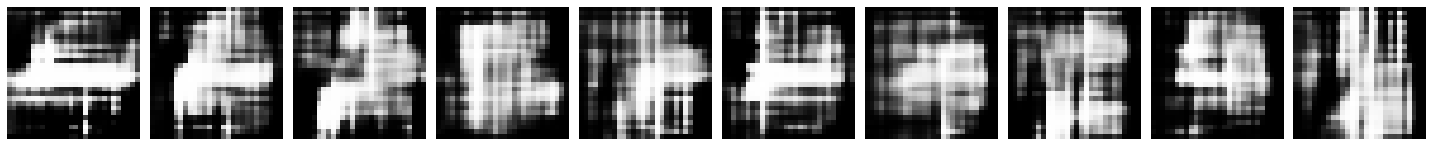

Epoch 10/100
547/547 - 25s - loss: 1.4232 - d_loss: 0.6647 - g_loss: 0.7585


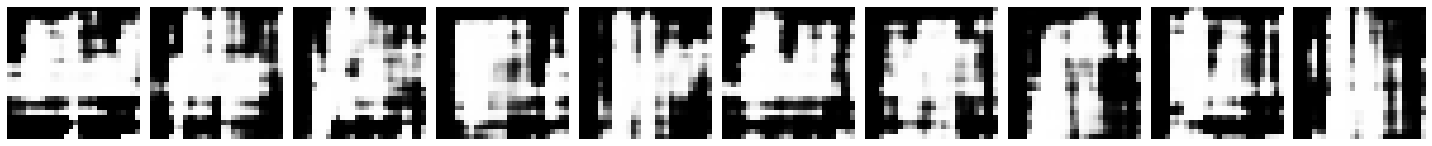

Epoch 11/100
547/547 - 25s - loss: 1.4133 - d_loss: 0.6755 - g_loss: 0.7378


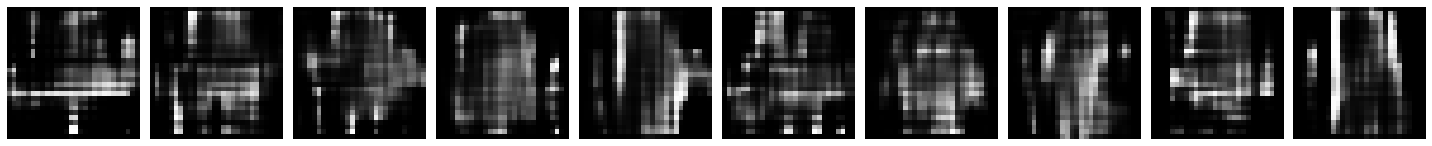

Epoch 12/100
547/547 - 25s - loss: 1.4252 - d_loss: 0.6704 - g_loss: 0.7548


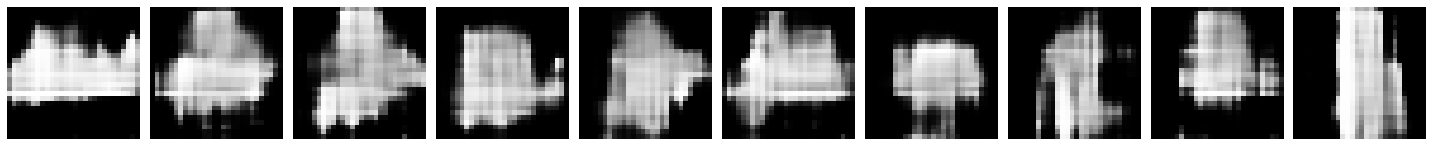

Epoch 13/100
547/547 - 25s - loss: 1.4397 - d_loss: 0.6665 - g_loss: 0.7732


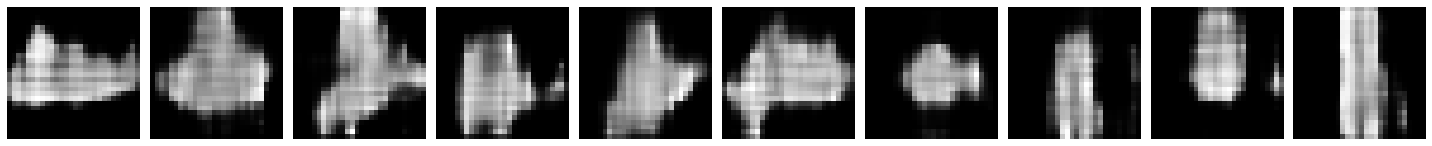

Epoch 14/100
547/547 - 25s - loss: 1.4598 - d_loss: 0.6661 - g_loss: 0.7937


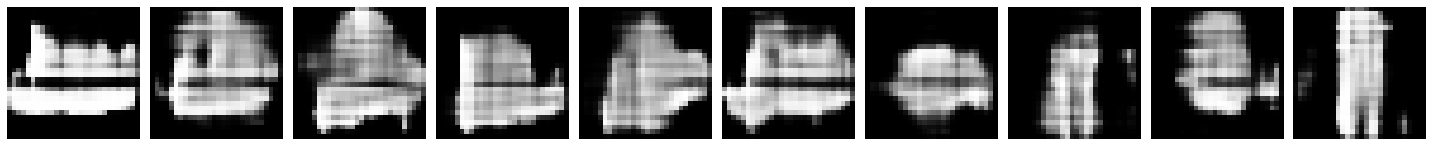

Epoch 15/100
547/547 - 25s - loss: 1.3907 - d_loss: 0.6803 - g_loss: 0.7104


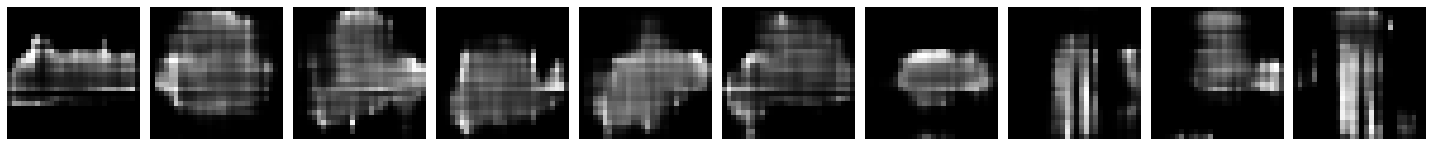

Epoch 16/100
547/547 - 25s - loss: 1.4229 - d_loss: 0.6677 - g_loss: 0.7552


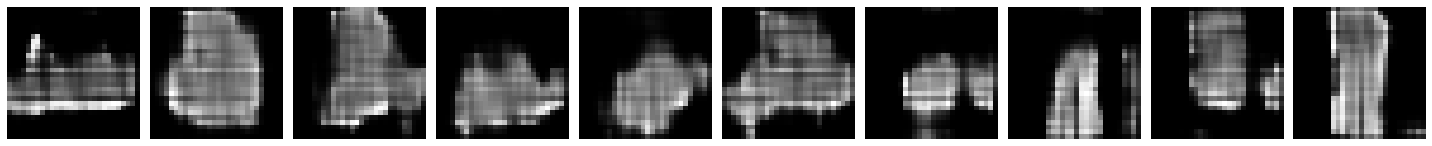

Epoch 17/100
547/547 - 25s - loss: 1.4224 - d_loss: 0.6722 - g_loss: 0.7502


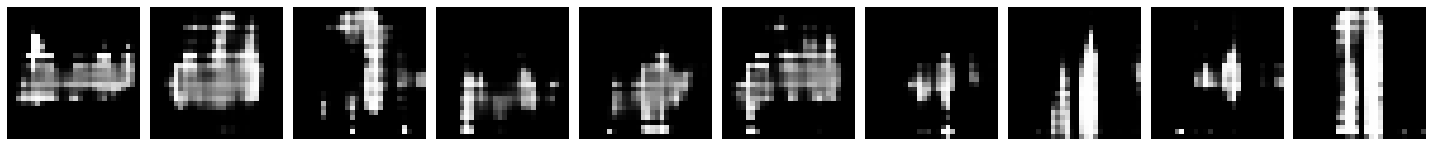

Epoch 18/100
547/547 - 25s - loss: 1.4322 - d_loss: 0.6693 - g_loss: 0.7629


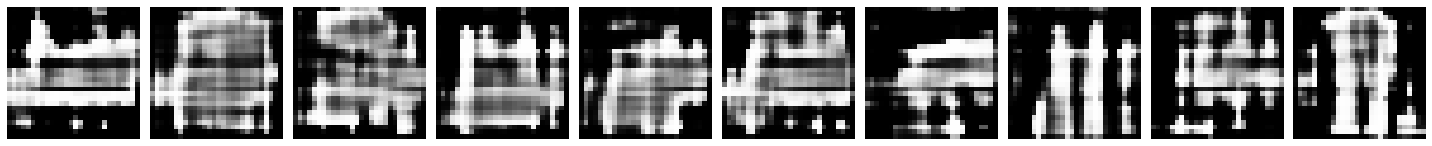

Epoch 19/100
547/547 - 25s - loss: 1.4333 - d_loss: 0.6651 - g_loss: 0.7682


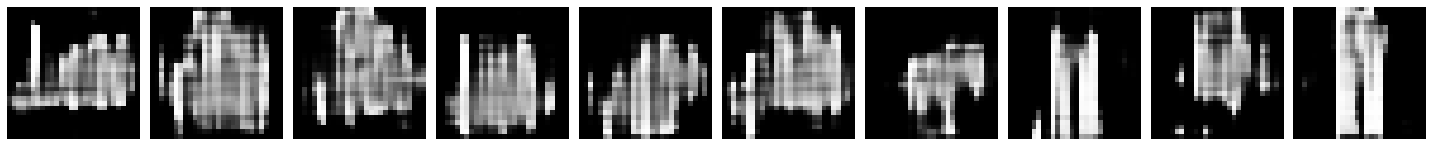

Epoch 20/100
547/547 - 25s - loss: 1.4940 - d_loss: 0.6553 - g_loss: 0.8388


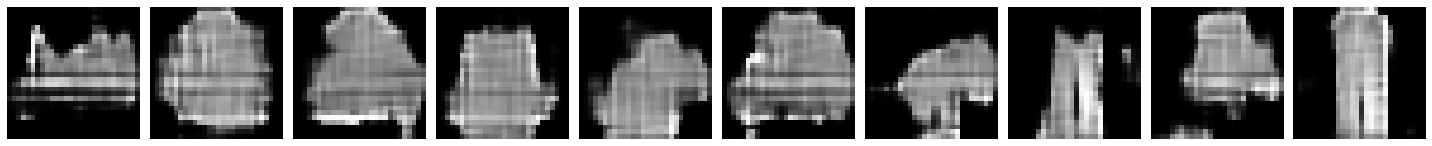

Epoch 21/100
547/547 - 25s - loss: 1.4220 - d_loss: 0.6558 - g_loss: 0.7662


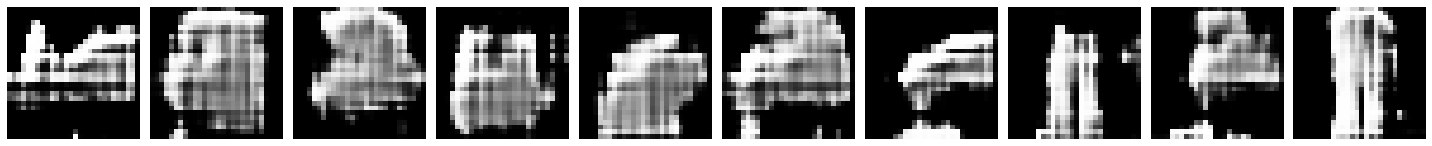

Epoch 22/100
547/547 - 25s - loss: 1.4057 - d_loss: 0.6621 - g_loss: 0.7436


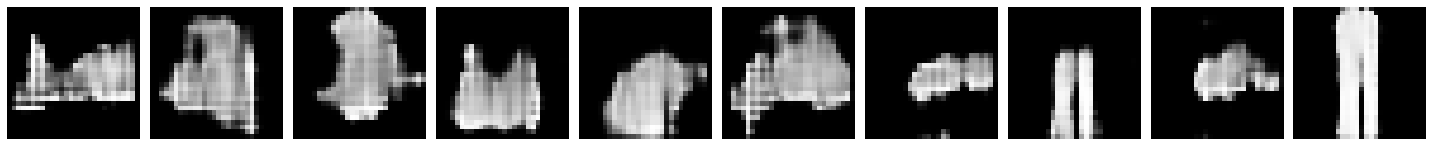

Epoch 23/100
547/547 - 25s - loss: 1.4425 - d_loss: 0.6575 - g_loss: 0.7850


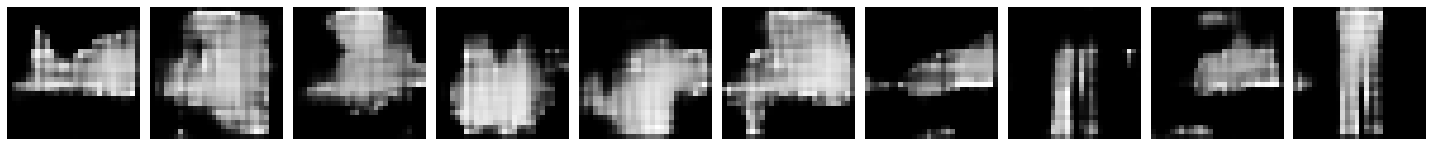

Epoch 24/100
547/547 - 25s - loss: 1.4495 - d_loss: 0.6423 - g_loss: 0.8072


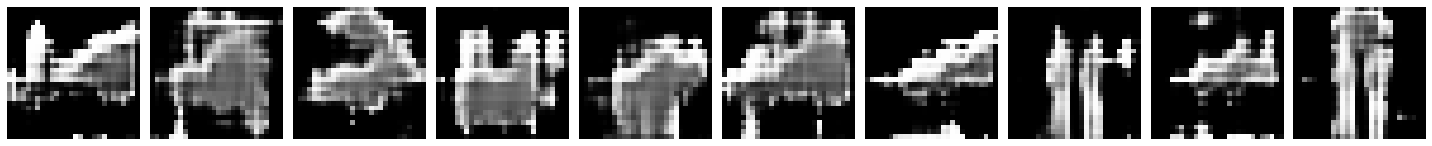

Epoch 25/100
547/547 - 25s - loss: 1.4811 - d_loss: 0.6437 - g_loss: 0.8375


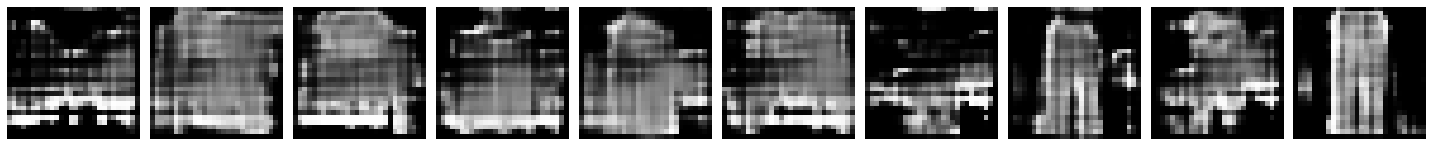

Epoch 26/100
547/547 - 25s - loss: 1.4538 - d_loss: 0.6488 - g_loss: 0.8050


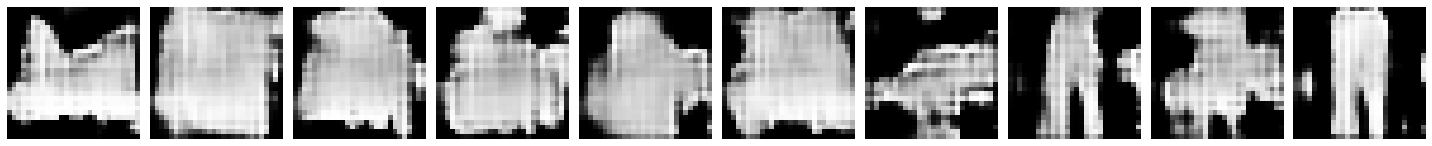

Epoch 27/100
547/547 - 25s - loss: 1.4288 - d_loss: 0.6561 - g_loss: 0.7727


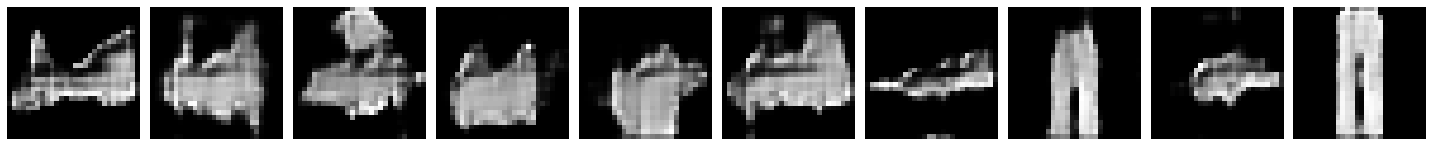

Epoch 28/100
547/547 - 25s - loss: 1.4628 - d_loss: 0.6421 - g_loss: 0.8207


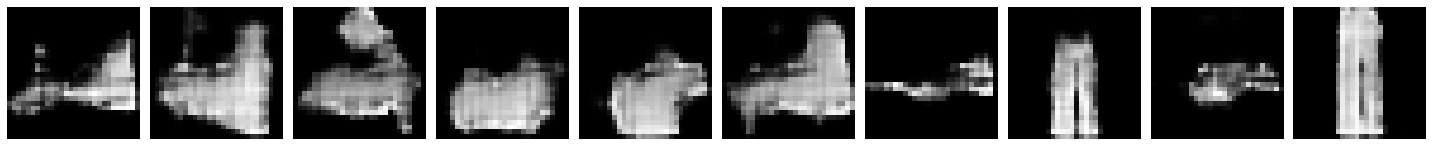

Epoch 29/100
547/547 - 25s - loss: 1.5003 - d_loss: 0.6419 - g_loss: 0.8583


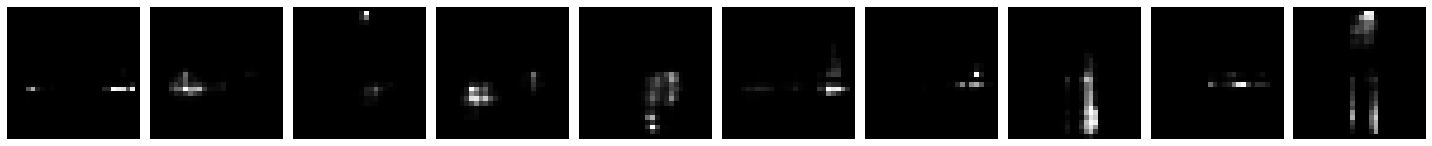

Epoch 30/100
547/547 - 25s - loss: 1.4592 - d_loss: 0.6509 - g_loss: 0.8083


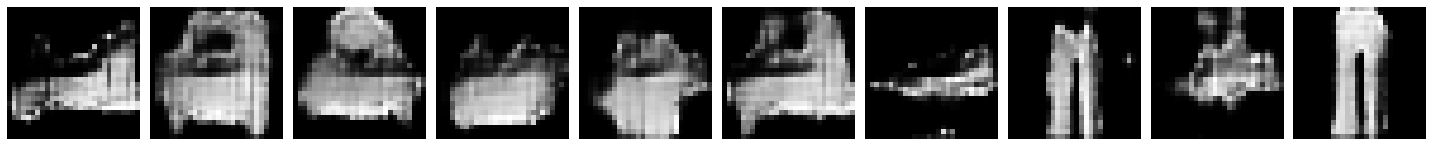

Epoch 31/100
547/547 - 25s - loss: 1.4523 - d_loss: 0.6424 - g_loss: 0.8099


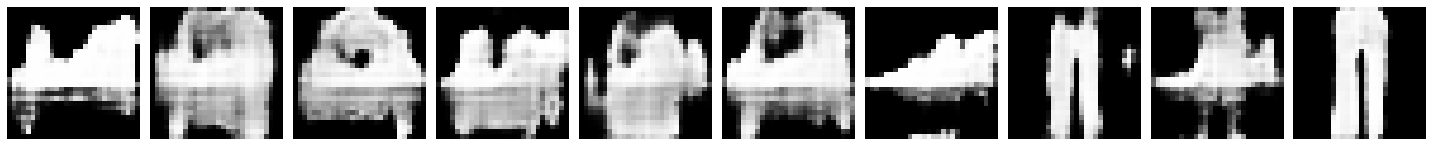

Epoch 32/100
547/547 - 25s - loss: 1.4859 - d_loss: 0.6427 - g_loss: 0.8432


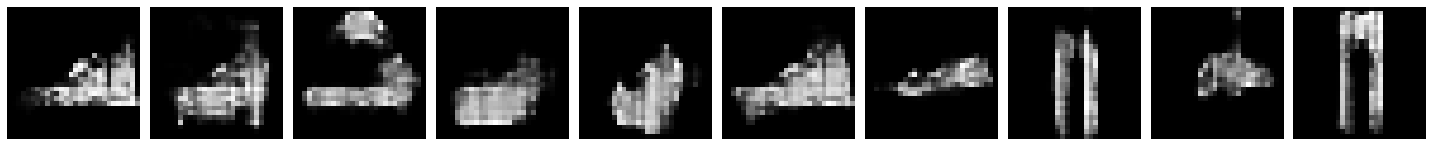

Epoch 33/100
547/547 - 25s - loss: 1.4239 - d_loss: 0.6525 - g_loss: 0.7714


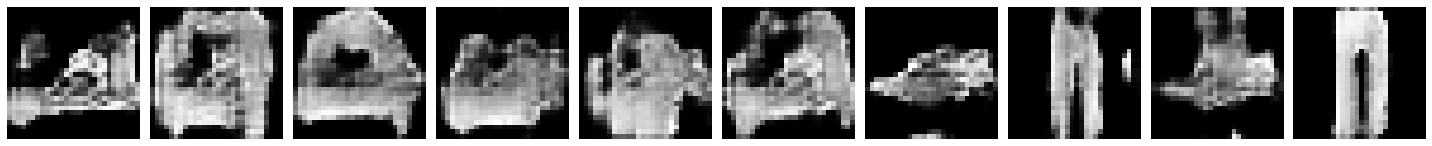

Epoch 34/100
547/547 - 25s - loss: 1.4800 - d_loss: 0.6399 - g_loss: 0.8400


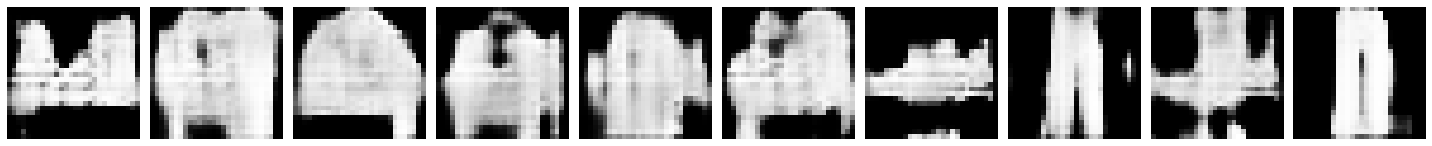

Epoch 35/100
547/547 - 25s - loss: 1.4871 - d_loss: 0.6456 - g_loss: 0.8415


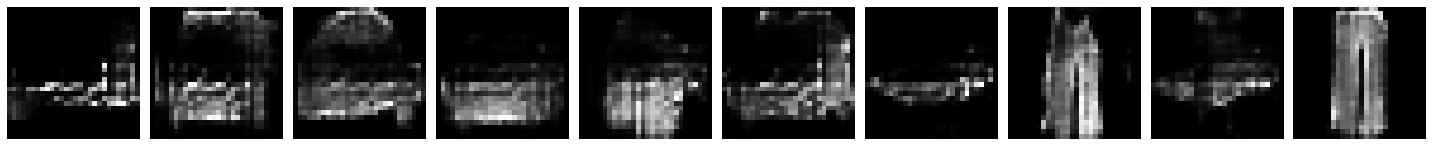

Epoch 36/100
547/547 - 25s - loss: 1.4474 - d_loss: 0.6429 - g_loss: 0.8044


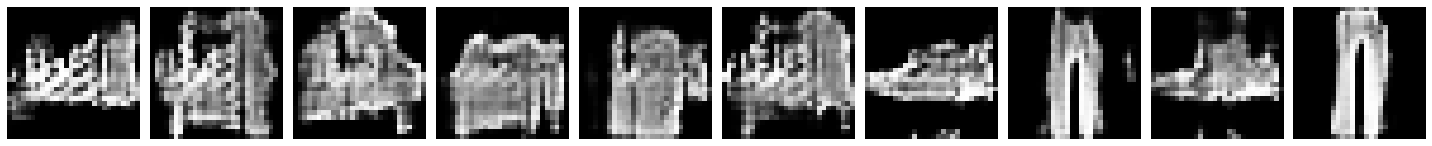

Epoch 37/100
547/547 - 25s - loss: 1.4653 - d_loss: 0.6420 - g_loss: 0.8233


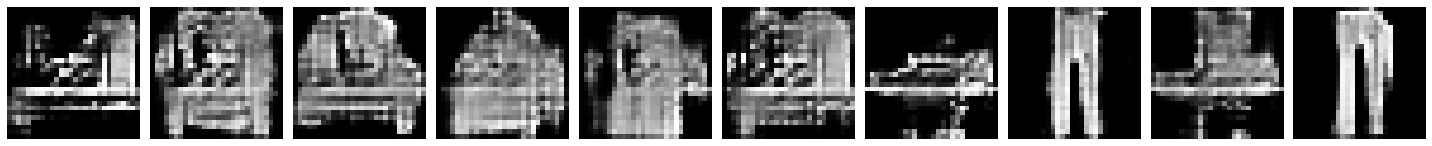

Epoch 38/100
547/547 - 25s - loss: 1.4864 - d_loss: 0.6320 - g_loss: 0.8544


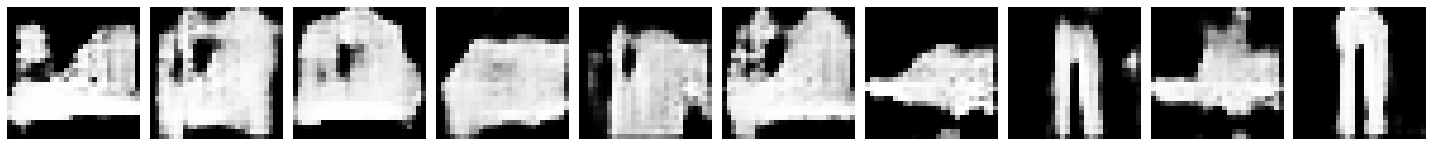

Epoch 39/100
547/547 - 25s - loss: 1.4451 - d_loss: 0.6404 - g_loss: 0.8047


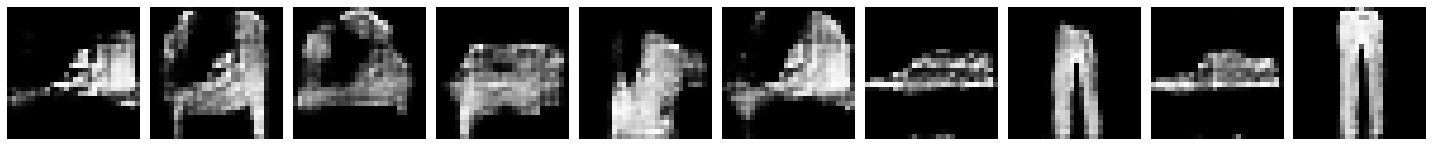

Epoch 40/100
547/547 - 25s - loss: 1.4846 - d_loss: 0.6289 - g_loss: 0.8557


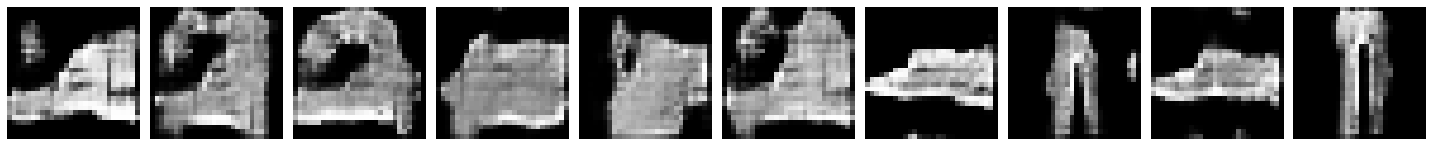

Epoch 41/100
547/547 - 25s - loss: 1.4772 - d_loss: 0.6333 - g_loss: 0.8439


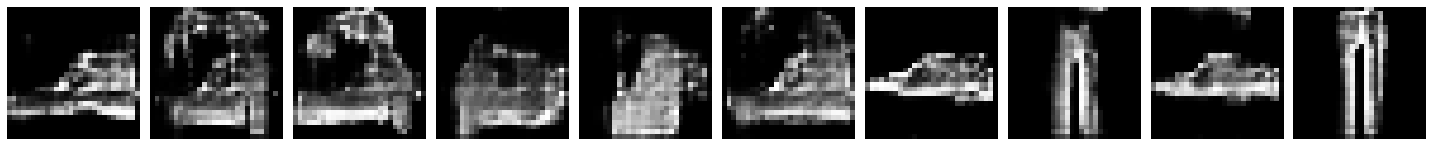

Epoch 42/100
547/547 - 25s - loss: 1.4509 - d_loss: 0.6375 - g_loss: 0.8134


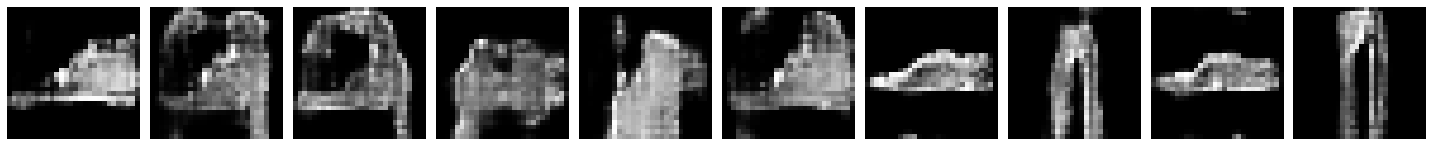

Epoch 43/100
547/547 - 25s - loss: 1.4487 - d_loss: 0.6332 - g_loss: 0.8156


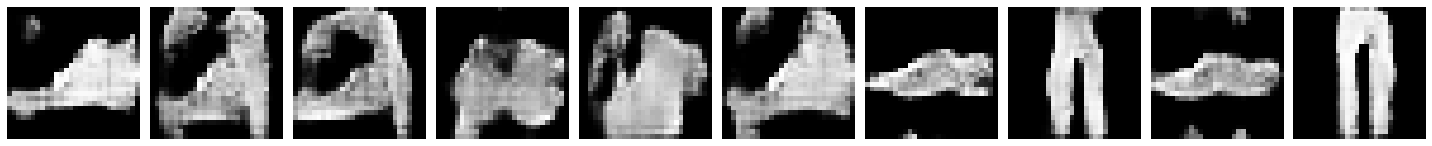

Epoch 44/100
547/547 - 25s - loss: 1.4763 - d_loss: 0.6356 - g_loss: 0.8407


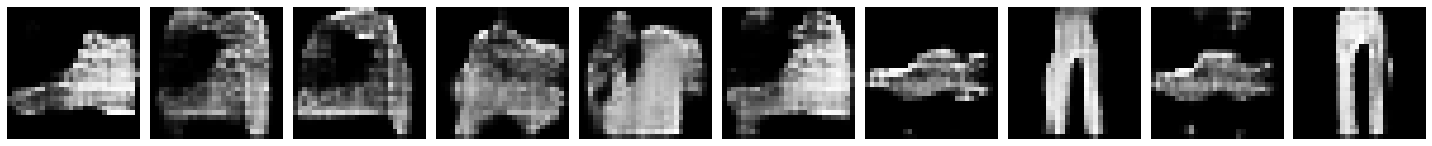

Epoch 45/100
547/547 - 25s - loss: 1.4693 - d_loss: 0.6342 - g_loss: 0.8352


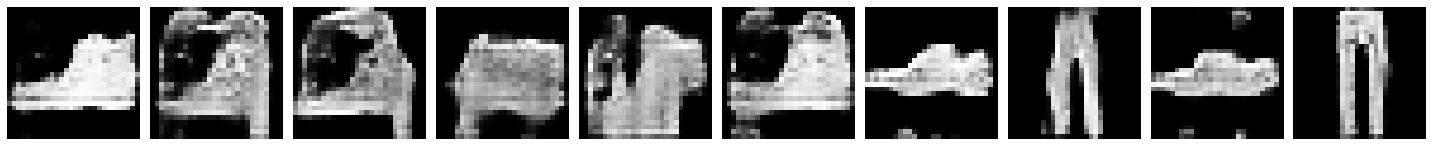

Epoch 46/100
547/547 - 25s - loss: 1.4642 - d_loss: 0.6396 - g_loss: 0.8246


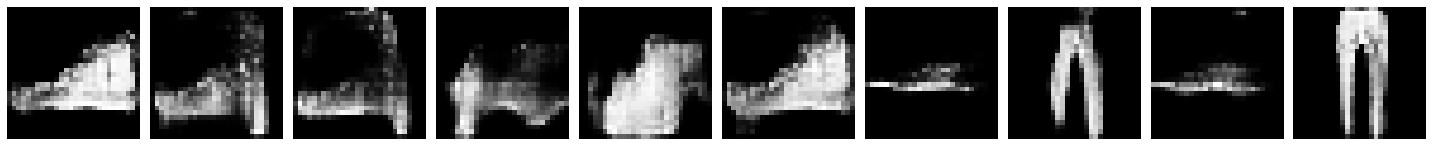

Epoch 47/100
547/547 - 25s - loss: 1.4457 - d_loss: 0.6400 - g_loss: 0.8057


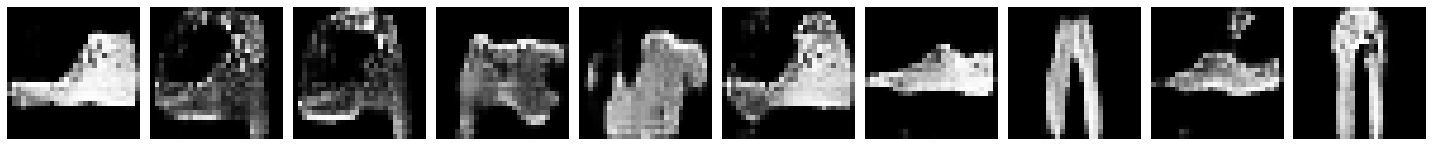

Epoch 48/100
547/547 - 25s - loss: 1.4792 - d_loss: 0.6430 - g_loss: 0.8362


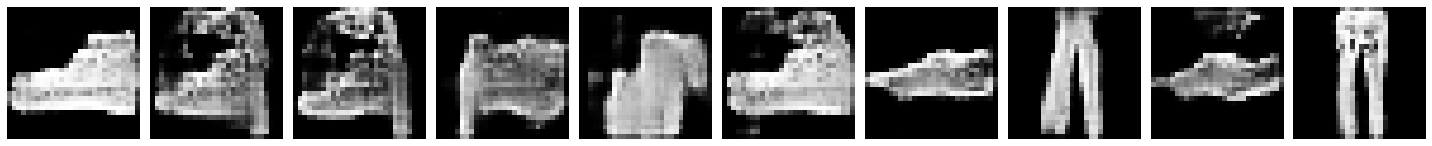

Epoch 49/100
547/547 - 25s - loss: 1.4646 - d_loss: 0.6461 - g_loss: 0.8185


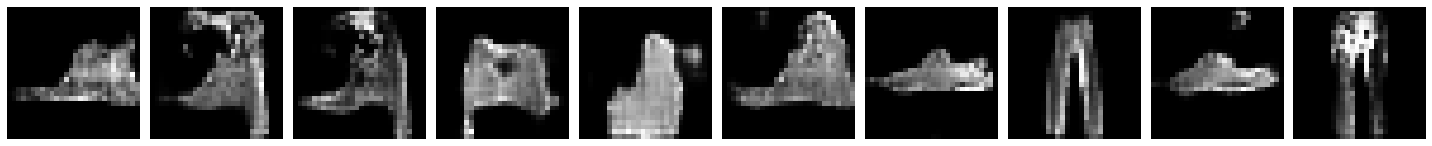

Epoch 50/100
547/547 - 25s - loss: 1.4579 - d_loss: 0.6373 - g_loss: 0.8206


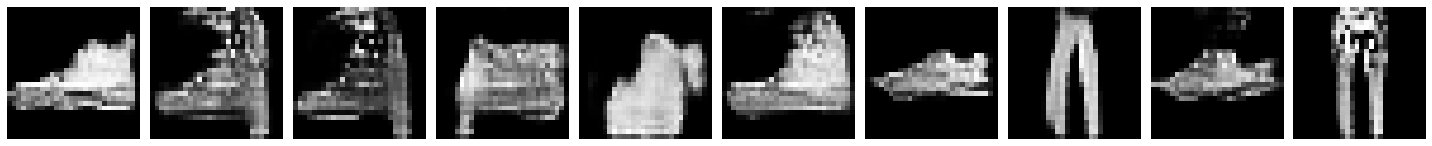

Epoch 51/100
547/547 - 25s - loss: 1.4467 - d_loss: 0.6398 - g_loss: 0.8068


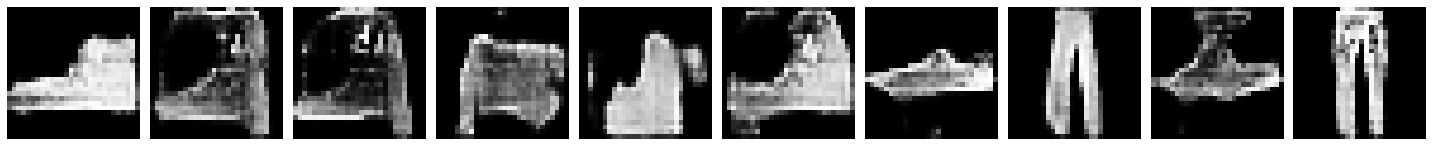

Epoch 52/100
547/547 - 25s - loss: 1.4555 - d_loss: 0.6375 - g_loss: 0.8180


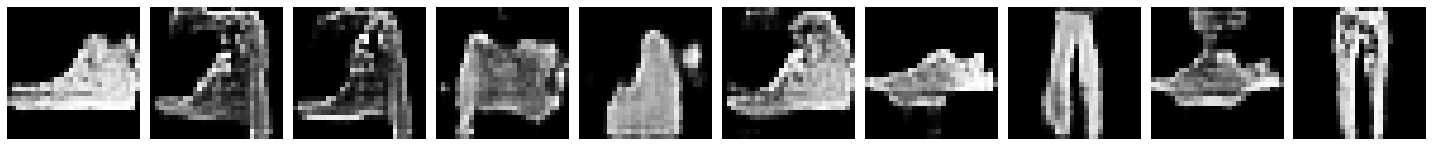

Epoch 53/100
547/547 - 25s - loss: 1.4684 - d_loss: 0.6398 - g_loss: 0.8286


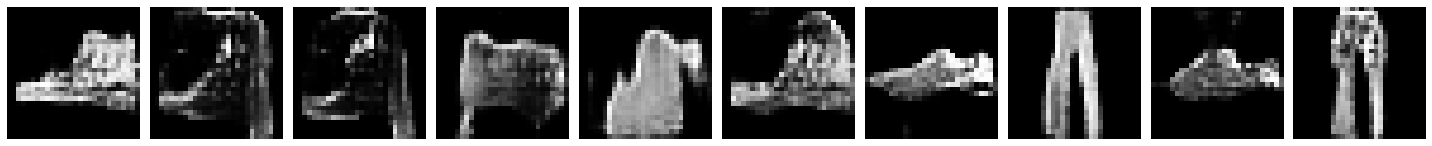

Epoch 54/100
547/547 - 25s - loss: 1.4498 - d_loss: 0.6457 - g_loss: 0.8041


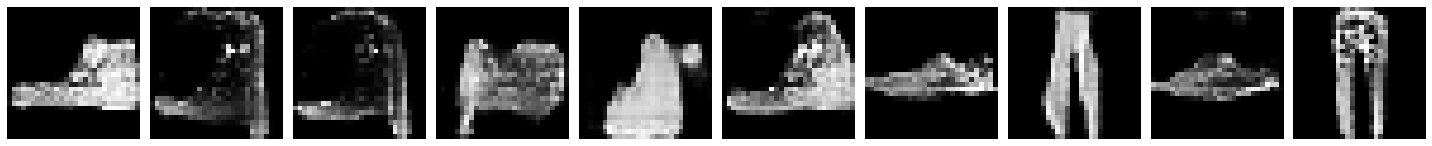

Epoch 55/100
547/547 - 25s - loss: 1.4603 - d_loss: 0.6385 - g_loss: 0.8218


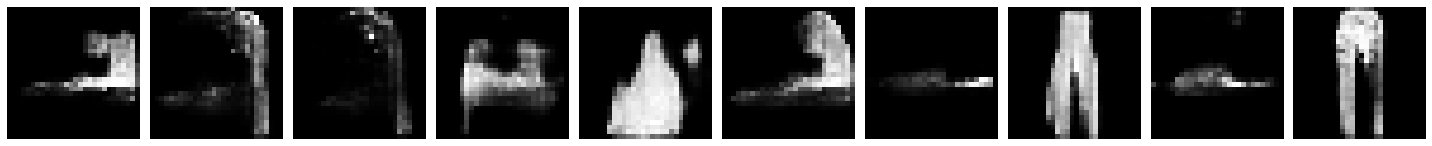

Epoch 56/100
547/547 - 25s - loss: 1.5291 - d_loss: 0.6176 - g_loss: 0.9115


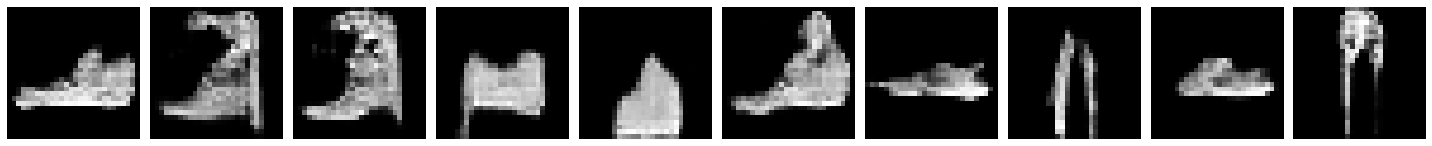

Epoch 57/100
547/547 - 25s - loss: 1.4631 - d_loss: 0.6240 - g_loss: 0.8391


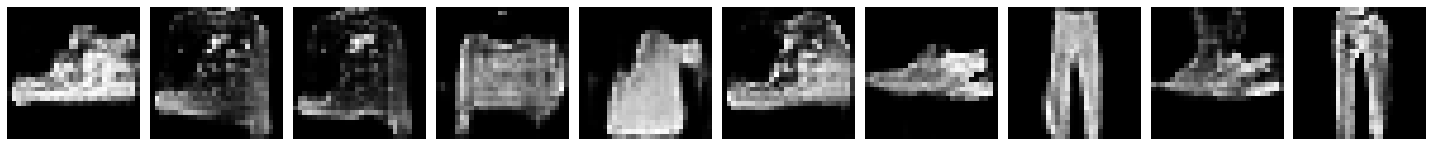

Epoch 58/100
547/547 - 25s - loss: 1.4624 - d_loss: 0.6301 - g_loss: 0.8323


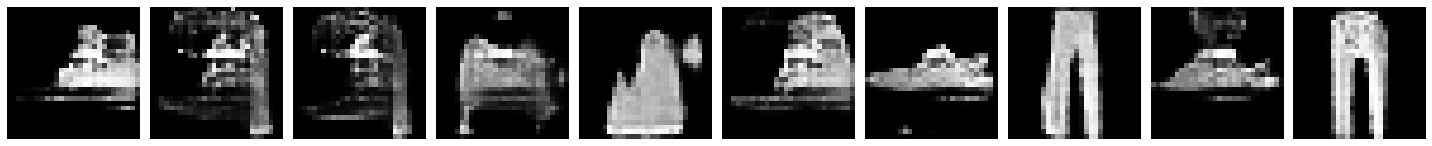

Epoch 59/100
547/547 - 25s - loss: 1.4721 - d_loss: 0.6254 - g_loss: 0.8467


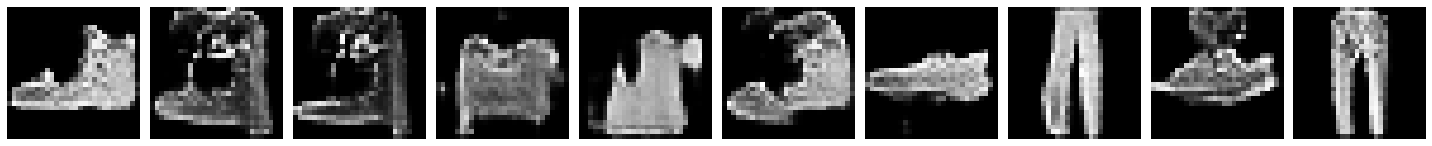

Epoch 60/100
547/547 - 25s - loss: 1.4801 - d_loss: 0.6259 - g_loss: 0.8542


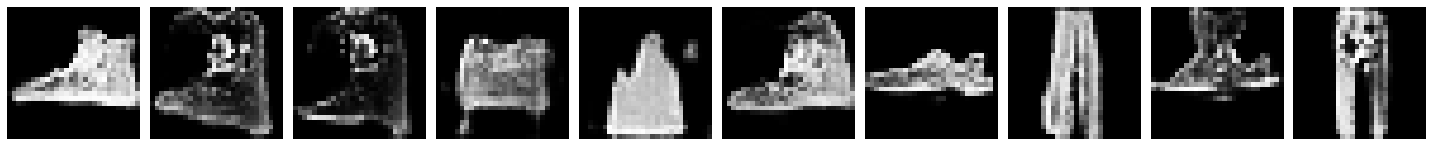

Epoch 61/100
547/547 - 25s - loss: 1.4462 - d_loss: 0.6393 - g_loss: 0.8069


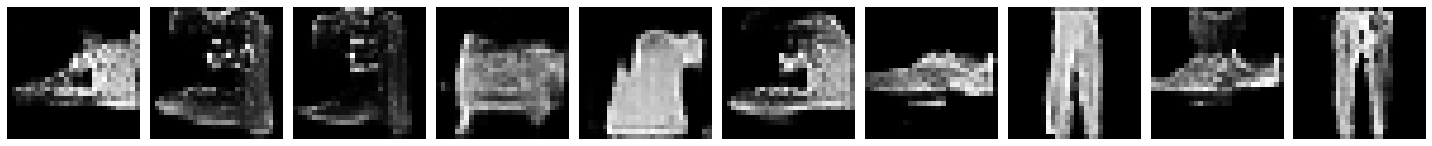

Epoch 62/100
547/547 - 25s - loss: 1.5239 - d_loss: 0.6213 - g_loss: 0.9026


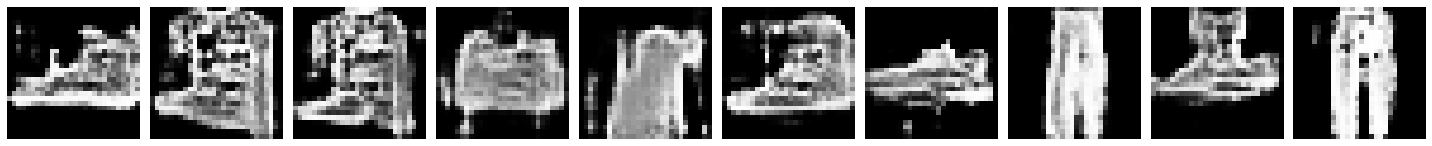

Epoch 63/100
547/547 - 25s - loss: 1.4720 - d_loss: 0.6252 - g_loss: 0.8467


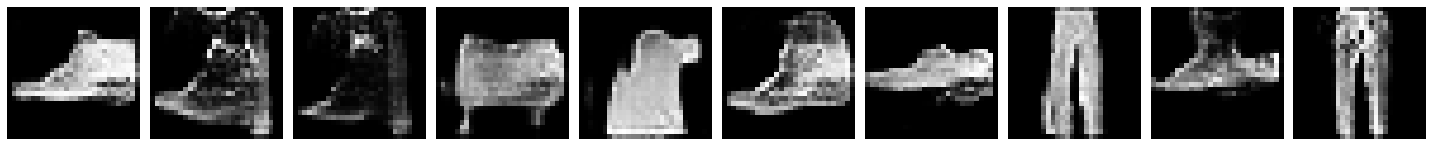

Epoch 64/100
547/547 - 25s - loss: 1.4424 - d_loss: 0.6353 - g_loss: 0.8071


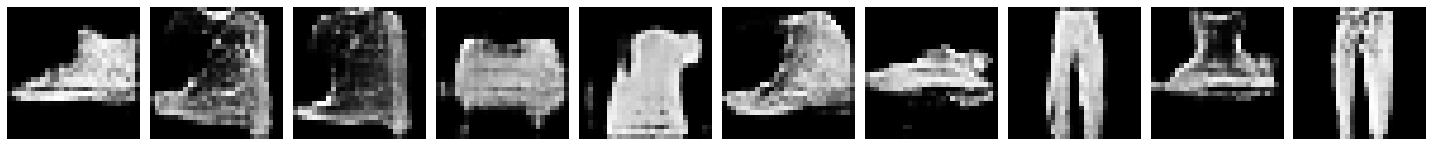

Epoch 65/100
547/547 - 25s - loss: 1.5292 - d_loss: 0.6265 - g_loss: 0.9027


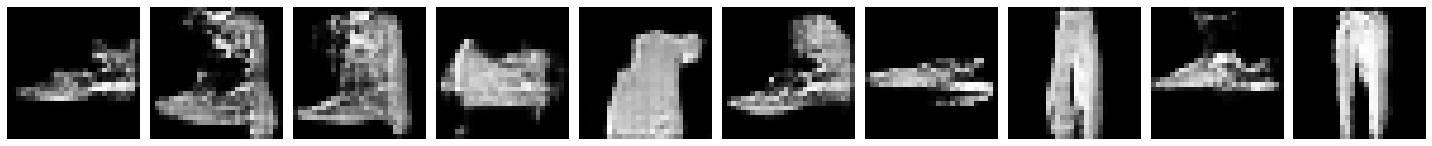

Epoch 66/100
547/547 - 25s - loss: 1.4604 - d_loss: 0.6278 - g_loss: 0.8326


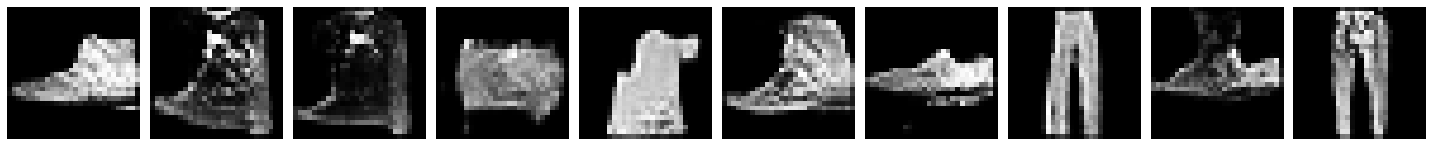

Epoch 67/100
547/547 - 25s - loss: 1.4444 - d_loss: 0.6391 - g_loss: 0.8053


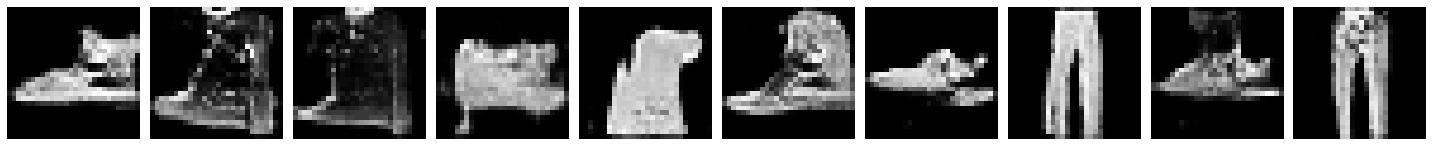

Epoch 68/100
547/547 - 25s - loss: 1.4484 - d_loss: 0.6361 - g_loss: 0.8123


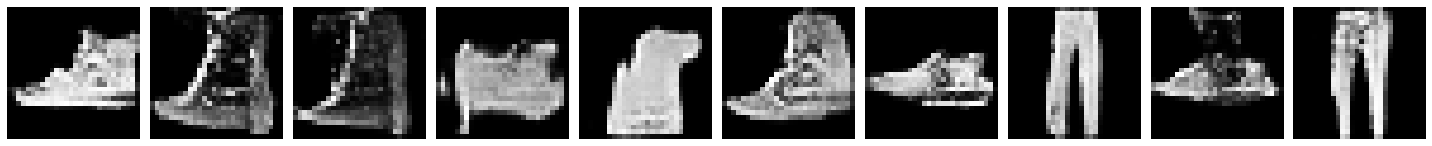

Epoch 69/100
547/547 - 25s - loss: 1.5084 - d_loss: 0.6281 - g_loss: 0.8803


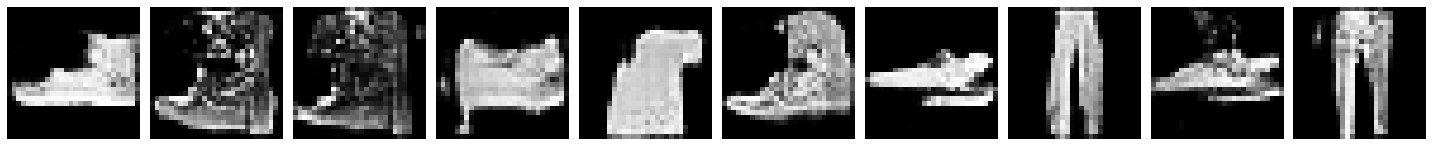

Epoch 70/100
547/547 - 25s - loss: 1.4505 - d_loss: 0.6311 - g_loss: 0.8194


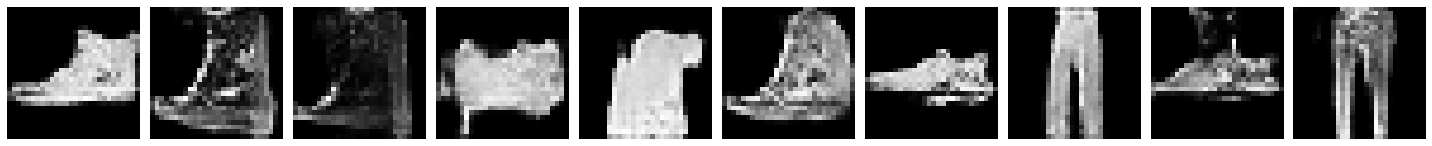

Epoch 71/100
547/547 - 25s - loss: 1.4450 - d_loss: 0.6387 - g_loss: 0.8063


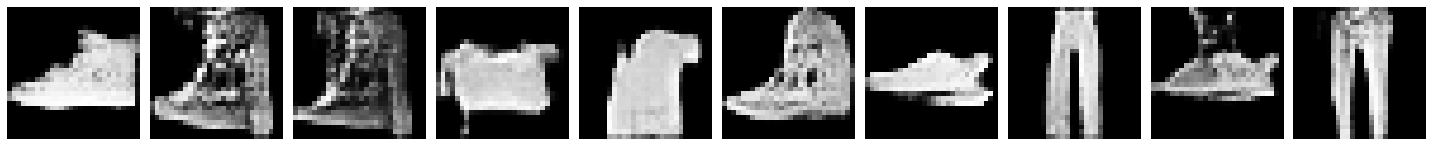

Epoch 72/100
547/547 - 25s - loss: 1.5245 - d_loss: 0.6338 - g_loss: 0.8906


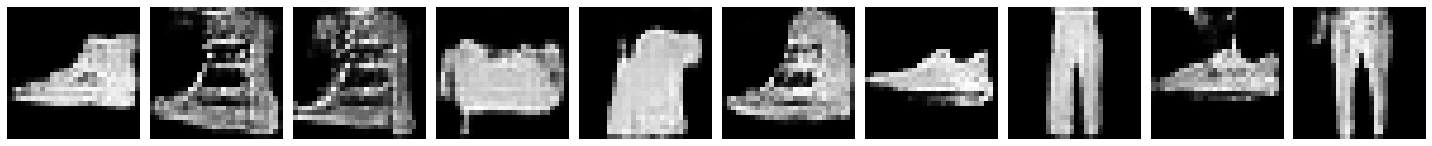

Epoch 73/100
547/547 - 25s - loss: 1.4374 - d_loss: 0.6380 - g_loss: 0.7994


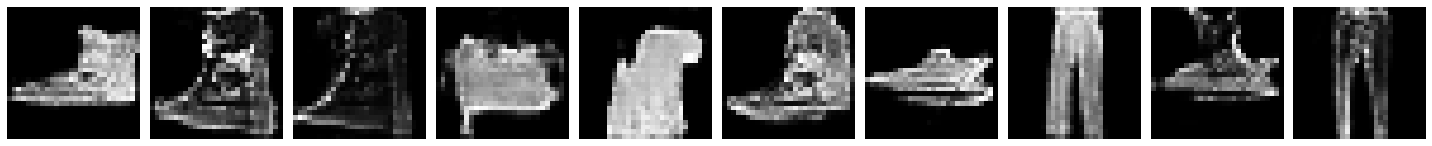

Epoch 74/100
547/547 - 25s - loss: 1.4519 - d_loss: 0.6337 - g_loss: 0.8181


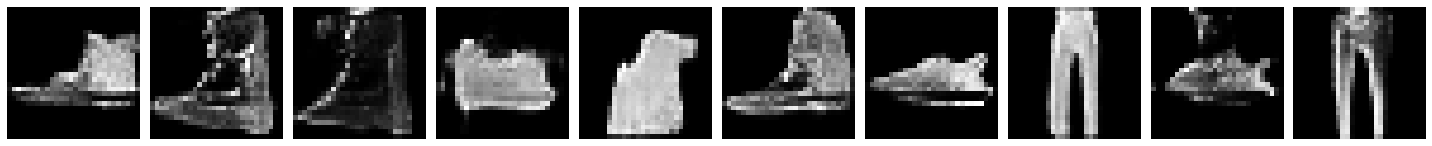

Epoch 75/100
547/547 - 25s - loss: 1.5162 - d_loss: 0.6279 - g_loss: 0.8883


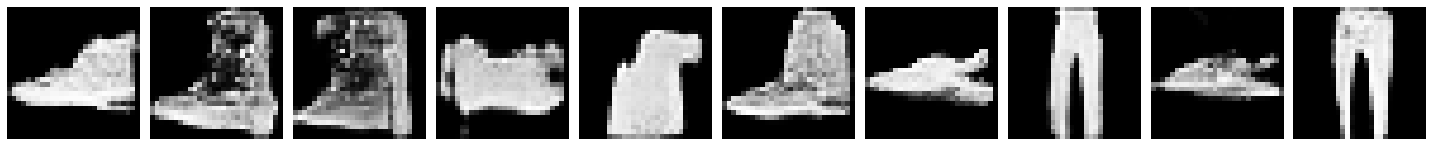

Epoch 76/100
547/547 - 25s - loss: 1.4480 - d_loss: 0.6300 - g_loss: 0.8180


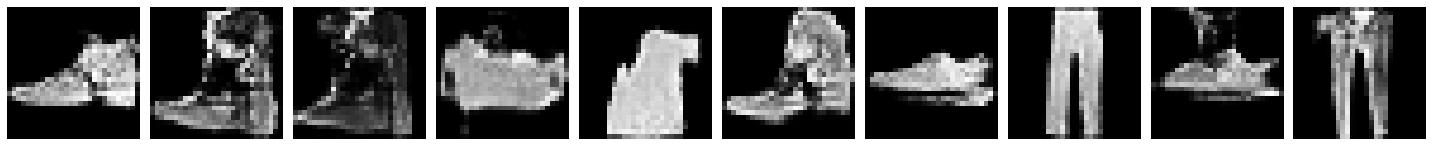

Epoch 77/100
547/547 - 25s - loss: 1.4383 - d_loss: 0.6353 - g_loss: 0.8030


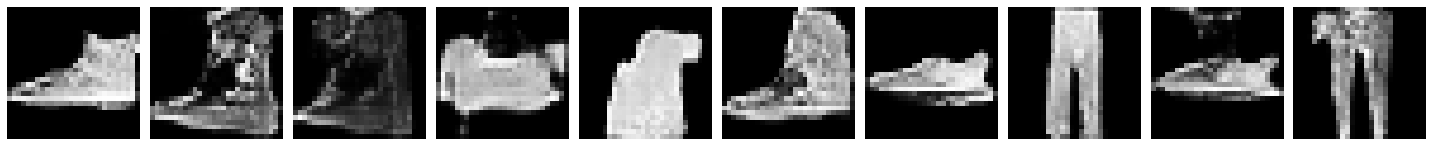

Epoch 78/100
547/547 - 25s - loss: 1.4827 - d_loss: 0.6331 - g_loss: 0.8496


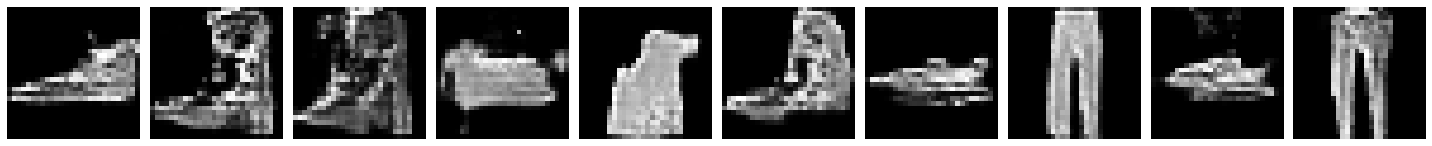

Epoch 79/100
547/547 - 25s - loss: 1.4491 - d_loss: 0.6341 - g_loss: 0.8150


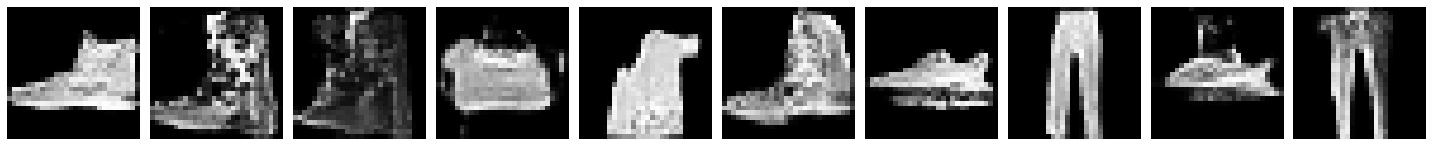

Epoch 80/100
547/547 - 25s - loss: 1.4412 - d_loss: 0.6371 - g_loss: 0.8041


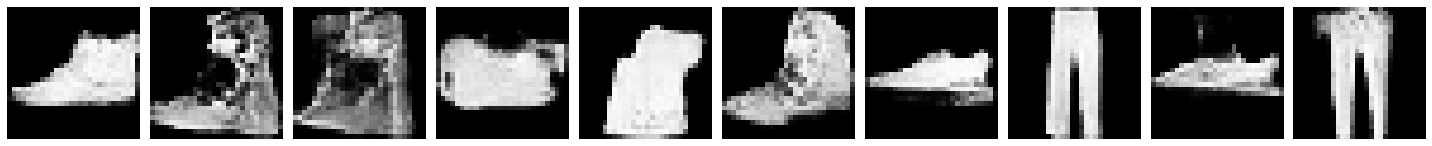

Epoch 81/100
547/547 - 25s - loss: 1.5111 - d_loss: 0.6267 - g_loss: 0.8844


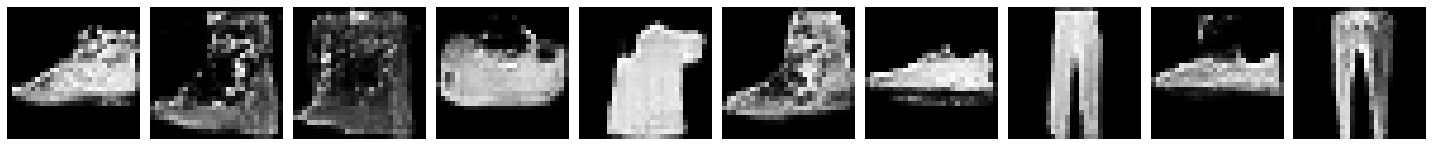

Epoch 82/100
547/547 - 25s - loss: 1.4472 - d_loss: 0.6357 - g_loss: 0.8116


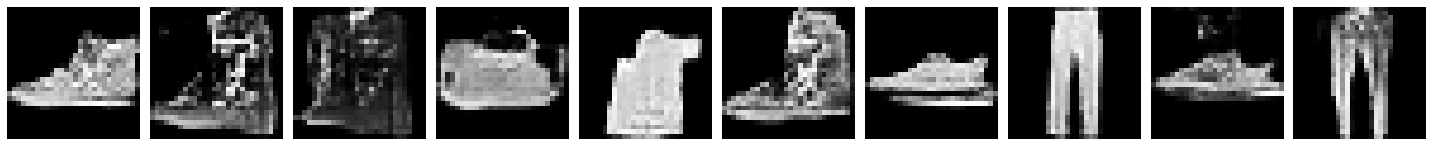

Epoch 83/100
547/547 - 25s - loss: 1.4414 - d_loss: 0.6382 - g_loss: 0.8032


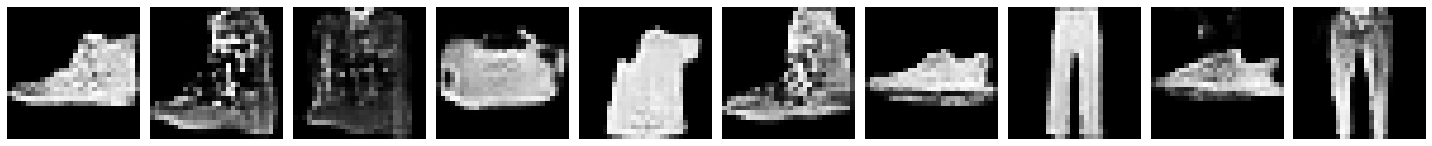

Epoch 84/100
547/547 - 25s - loss: 1.5193 - d_loss: 0.6304 - g_loss: 0.8889


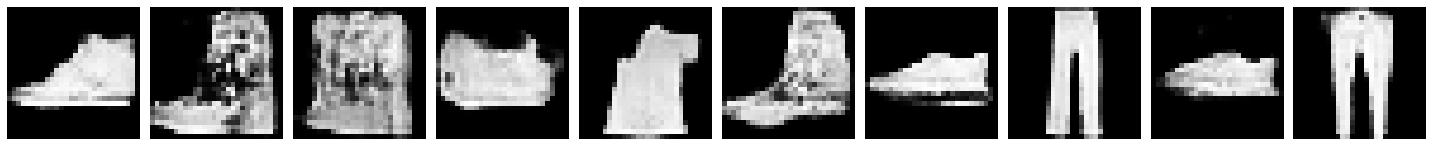

Epoch 85/100
547/547 - 25s - loss: 1.4858 - d_loss: 0.6280 - g_loss: 0.8578


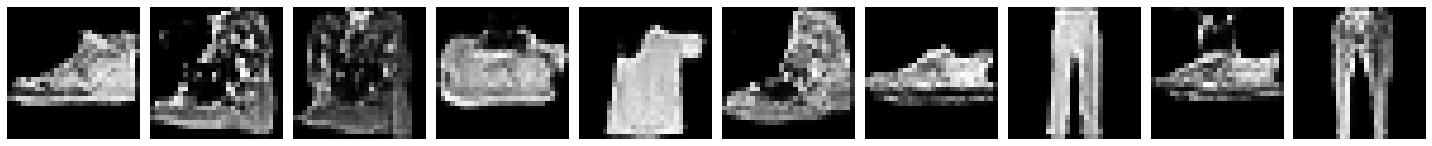

Epoch 86/100
547/547 - 25s - loss: 1.4296 - d_loss: 0.6381 - g_loss: 0.7915


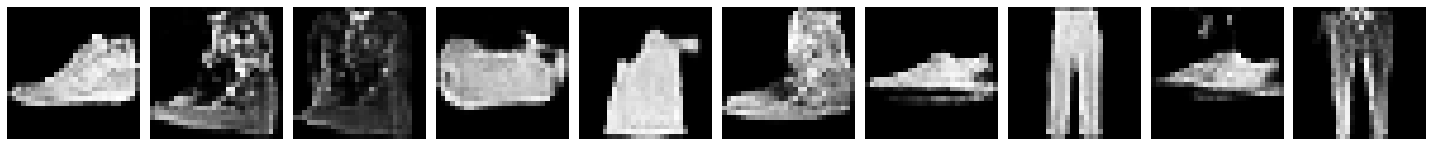

Epoch 87/100
547/547 - 25s - loss: 1.4331 - d_loss: 0.6430 - g_loss: 0.7901


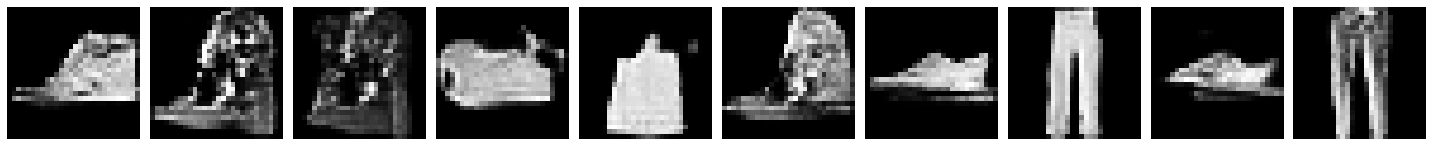

Epoch 88/100
547/547 - 25s - loss: 1.4477 - d_loss: 0.6405 - g_loss: 0.8072


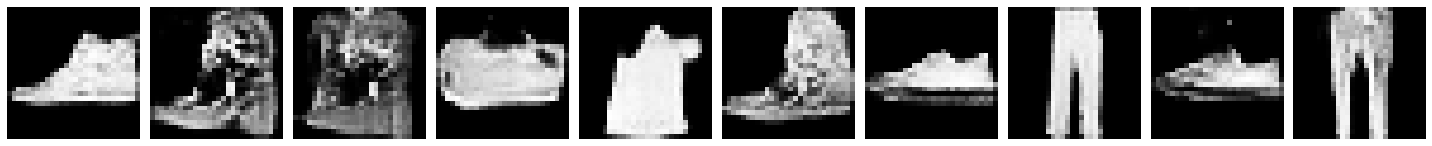

Epoch 89/100
547/547 - 25s - loss: 1.5155 - d_loss: 0.6324 - g_loss: 0.8830


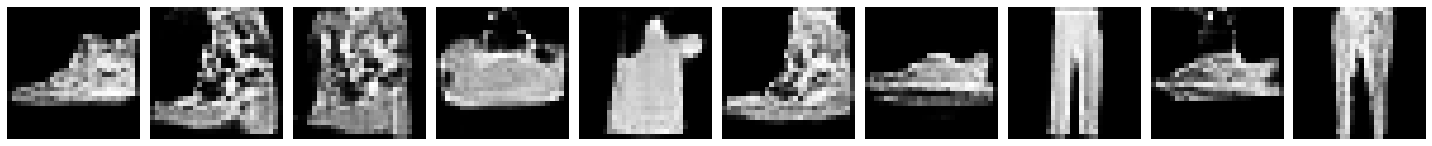

Epoch 90/100
547/547 - 25s - loss: 1.4561 - d_loss: 0.6329 - g_loss: 0.8232


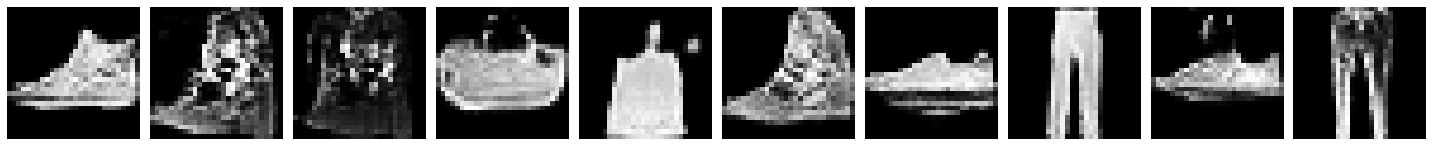

Epoch 91/100
547/547 - 25s - loss: 1.4231 - d_loss: 0.6462 - g_loss: 0.7769


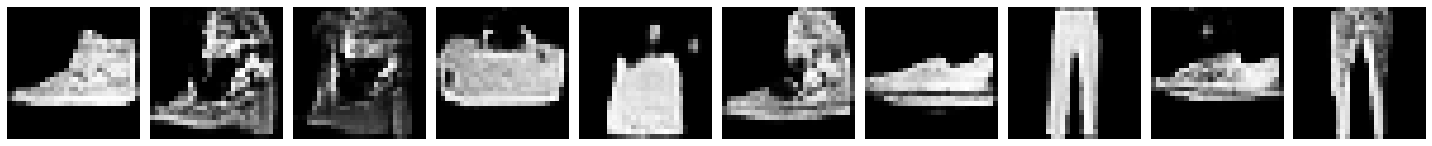

Epoch 92/100
547/547 - 25s - loss: 1.4303 - d_loss: 0.6421 - g_loss: 0.7882


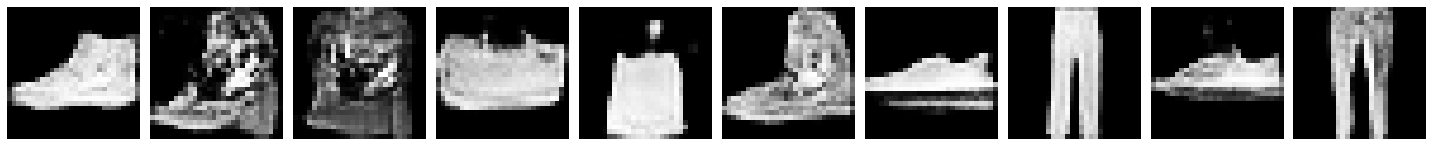

Epoch 93/100
547/547 - 25s - loss: 1.5148 - d_loss: 0.6341 - g_loss: 0.8807


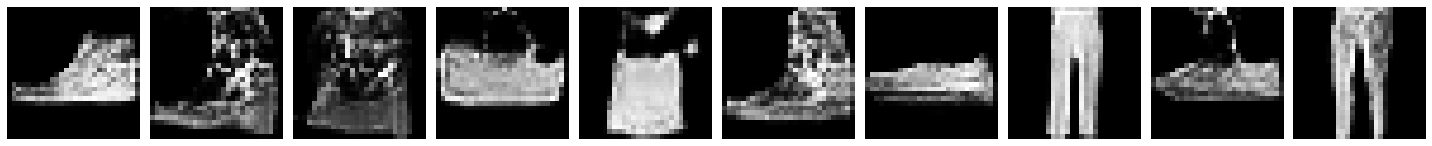

Epoch 94/100
547/547 - 25s - loss: 1.4312 - d_loss: 0.6423 - g_loss: 0.7888


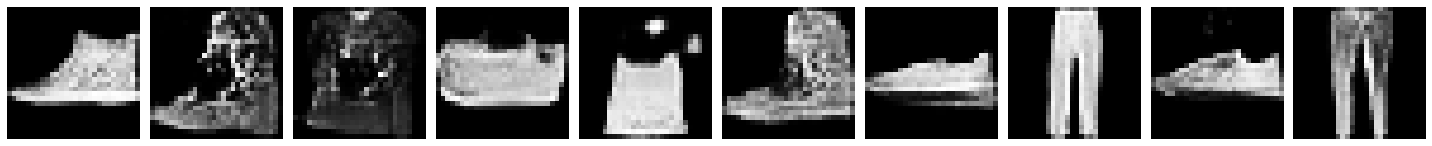

Epoch 95/100
547/547 - 25s - loss: 1.4241 - d_loss: 0.6458 - g_loss: 0.7784


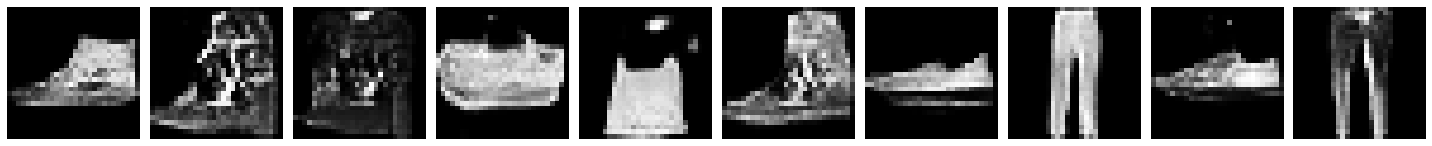

Epoch 96/100
547/547 - 25s - loss: 1.4948 - d_loss: 0.6373 - g_loss: 0.8574


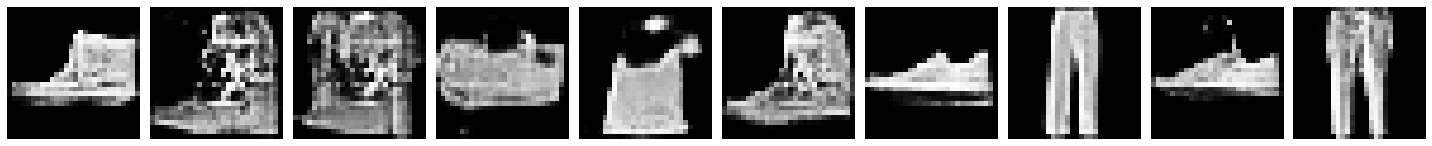

Epoch 97/100
547/547 - 25s - loss: 1.5060 - d_loss: 0.6308 - g_loss: 0.8752


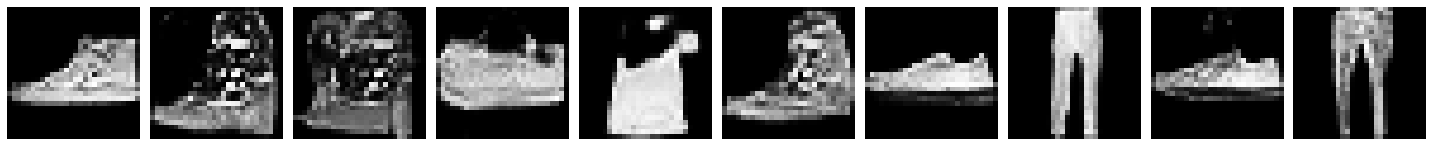

Epoch 98/100
547/547 - 25s - loss: 1.4174 - d_loss: 0.6432 - g_loss: 0.7742


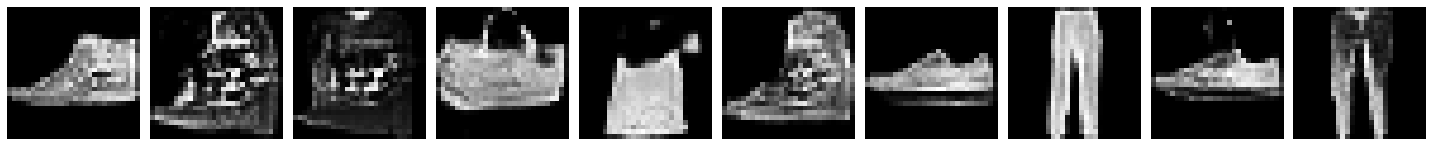

Epoch 99/100
547/547 - 25s - loss: 1.4153 - d_loss: 0.6483 - g_loss: 0.7670


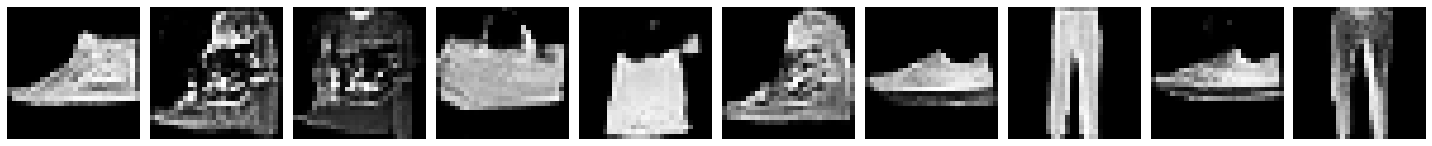

Epoch 100/100
547/547 - 25s - loss: 1.4409 - d_loss: 0.6444 - g_loss: 0.7965


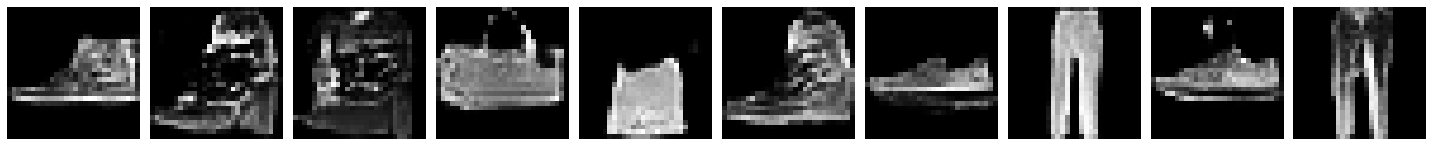

In [17]:
history = gan.fit(
    X, 
    epochs = epochs, 
    batch_size = batch_size,
    callbacks = [GANMonitor(name='vanilla', gray=True)],
    verbose = 2
).history

# when do we stop? loss is not very descriptive 
# minimum d_loss -> very very good, we migth be at the very beginning of the training 
# same for g_loss
# ISSUES 
# convergence 
# mode collapse -> generator understands how to trick discriminator always producing the same inputs 
# tried GAN for augmentation 


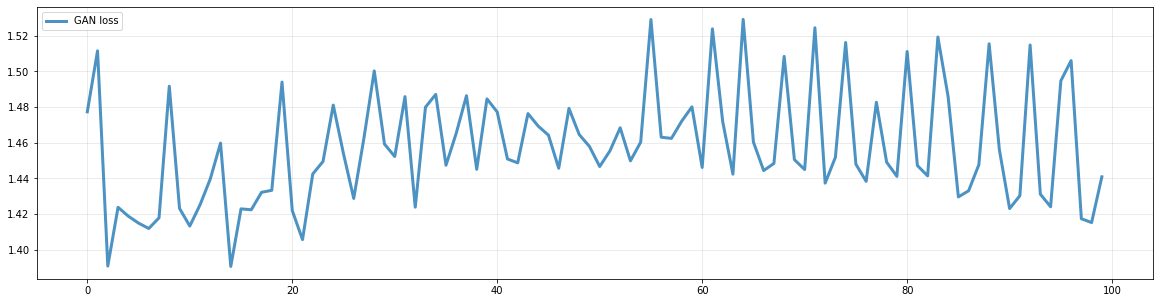

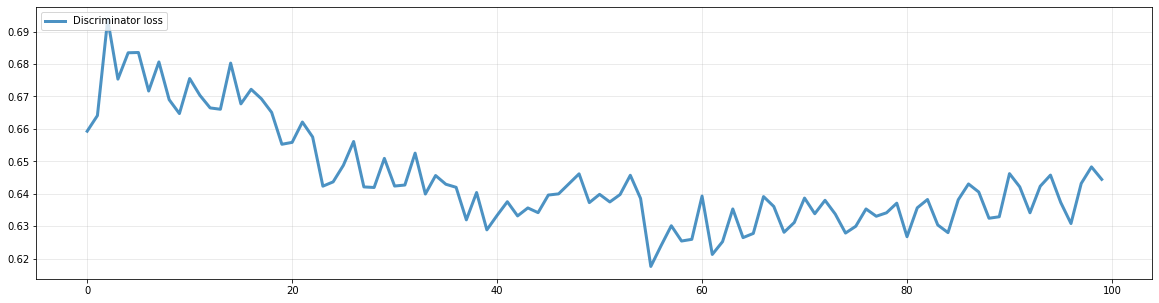

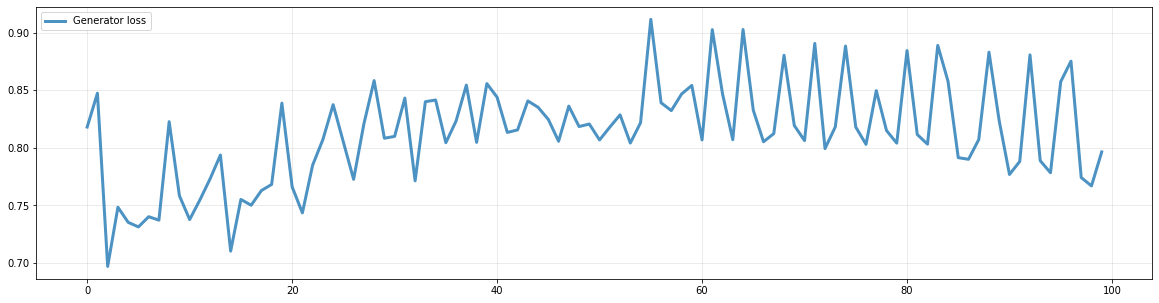

In [18]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='GAN loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['d_loss'], label='Discriminator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['g_loss'], label='Generator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)
plt.show()

In [19]:
gan.generator.save('vanilla_gan_generator')

In [20]:
vanilla_gan_generator = tfk.models.load_model('vanilla_gan_generator')

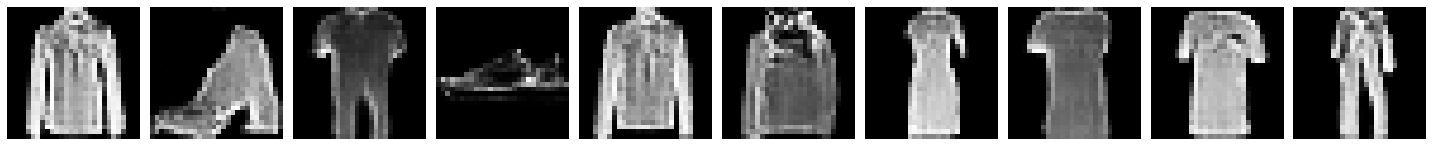

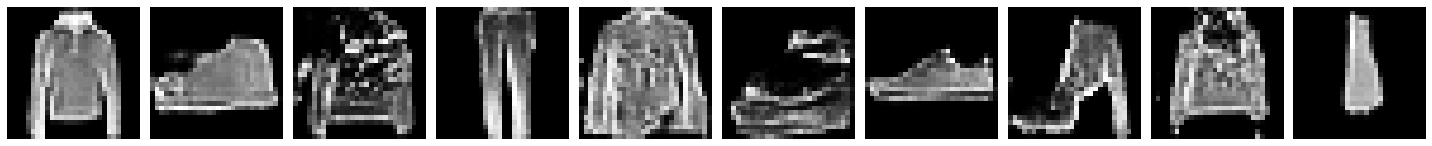

In [21]:
sample(vanilla_gan_generator, 10, latent_dim, fixed=False, gray=True)
sample(vanilla_gan_generator, 10, latent_dim, fixed=False, gray=True)
# we did not give the model info about labels, it cannot discriminate between images 

In [22]:
imgs = 2500
X_hat = generate_dataset(vanilla_gan_generator, imgs, latent_dim)*127.5 + 127+5
X_hat = np.reshape(X_hat, (X_hat.shape[0],X_hat.shape[1]*X_hat.shape[2]))
X_hat = np.mean(X_hat, axis=0)

X_temp = X[:imgs]*127.5 + 127+5 #going back to original img (see before)
X_temp = np.reshape(X_temp, (X_temp.shape[0],X_temp.shape[1]*X_temp.shape[2]))
X_temp = np.mean(X_temp, axis=0)

print(X_hat.shape, X_temp.shape)

(784,) (784,)


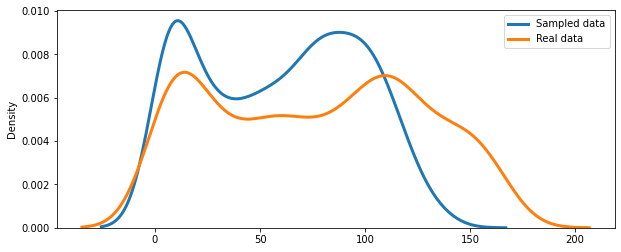

In [23]:
plt.figure(figsize=(10,4))
sns.kdeplot(x=X_hat, label='Sampled data', linewidth=3)
sns.kdeplot(x=X_temp, label='Real data', linewidth=3)
plt.legend()
plt.show()
# this models tries to make sampled distribution as simple as possible to the real data (input) distribution 

### Deep Convolutional Conditional GAN

In [24]:
image_size = input_shape[0]
num_classes = len(np.unique(y))
num_channels = input_shape[-1]

In [25]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes #porcata but it works
print(generator_in_channels, discriminator_in_channels)

138 11


We are computing a conditional probability, so this is named conditional GAN 

In [26]:
conditional_generator_input = (generator_in_channels)
conditional_discriminator_input = (image_size, image_size, discriminator_in_channels)
conditional_discriminator_input, conditional_generator_input

((28, 28, 11), 138)

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 11)]      0         
_________________________________________________________________
padding (ZeroPadding2D)      (None, 32, 32, 11)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 64)        6400      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 16, 16, 64)        256       
_________________________________________________________________
activation1 (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 8, 8, 128)         73856     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 8, 8, 128)       

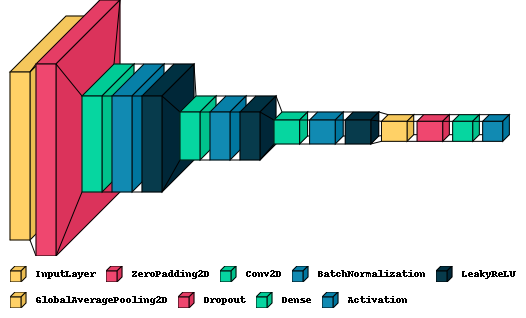

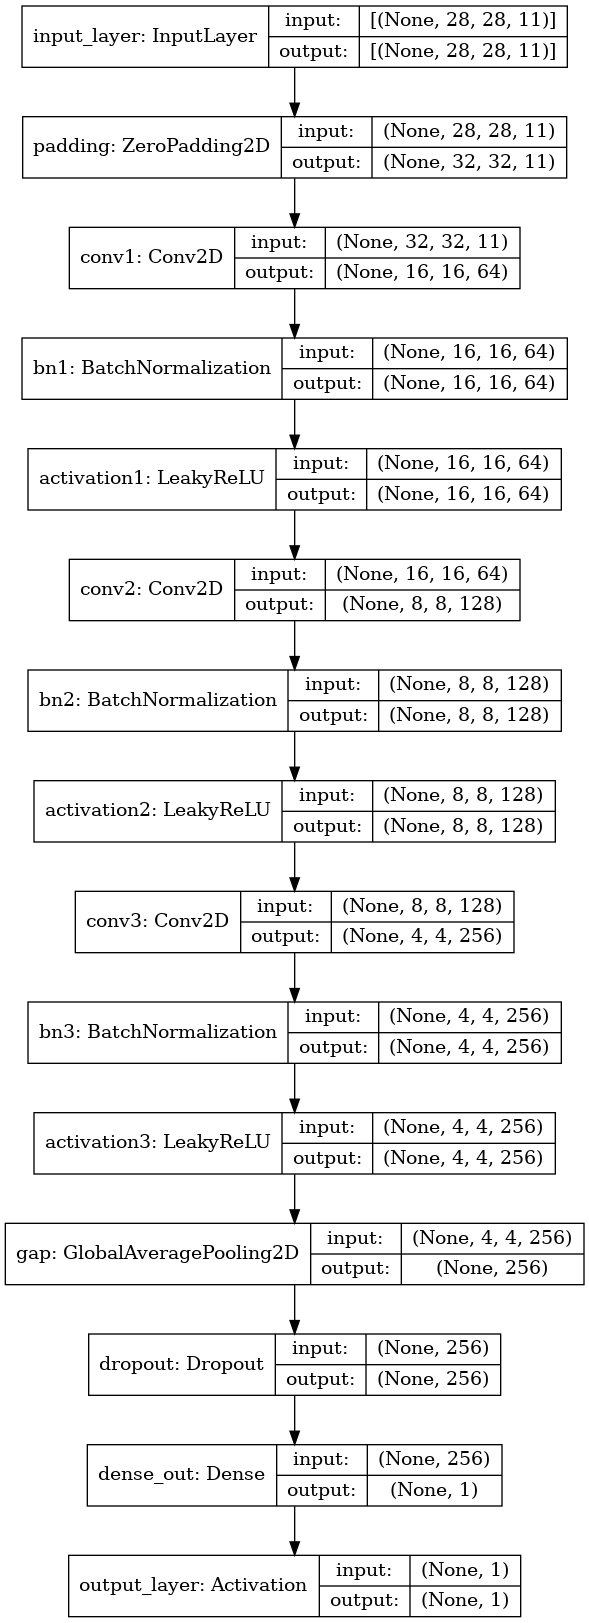

In [27]:
discriminator = get_dc_discriminator(conditional_discriminator_input)
discriminator.summary()
display(visualkeras.layered_view(discriminator, legend=True, scale_xy=6))
tfk.utils.plot_model(discriminator, show_shapes=True, expand_nested=True, to_file='conditional_discriminator.png')

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 138)]             0         
_________________________________________________________________
dense0 (Dense)               (None, 1024)              141312    
_________________________________________________________________
bn0 (BatchNormalization)     (None, 1024)              4096      
_________________________________________________________________
activation0 (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
upsampling1 (UpSampling2D)   (None, 8, 8, 64)          0         
_________________________________________________________________
conv1 (Conv2D)               (None, 8, 8, 64)          36

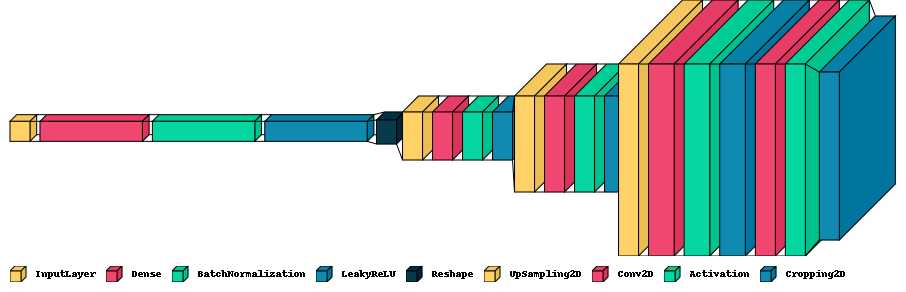

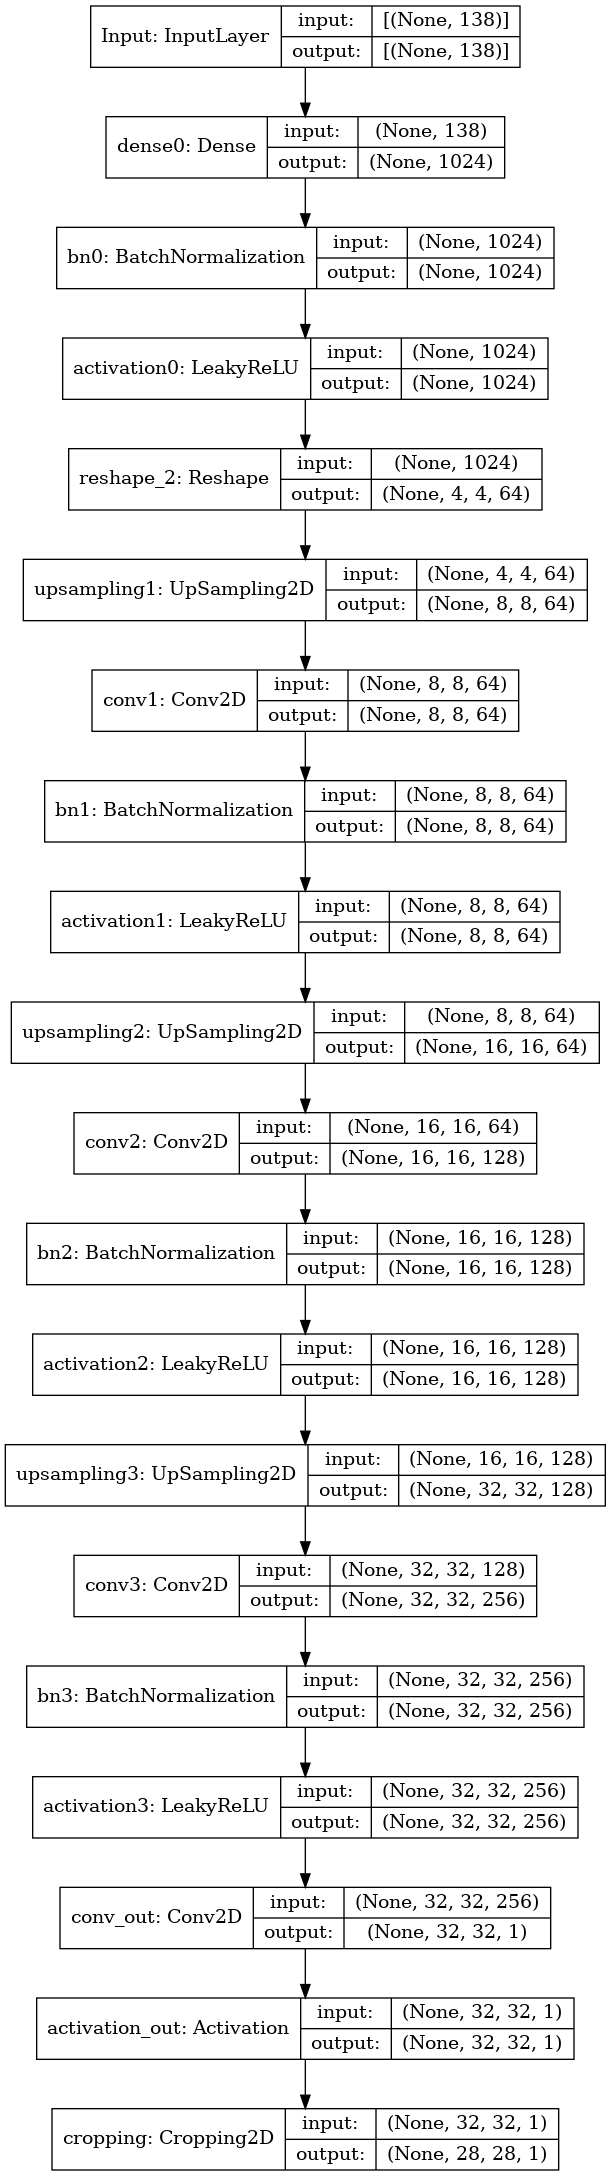

In [28]:
generator = get_dc_generator(conditional_generator_input)
generator.summary()
display(visualkeras.layered_view(generator, legend=True, scale_xy=6))
tfk.utils.plot_model(generator, show_shapes=True, expand_nested=True, to_file='conditional_generator.png')

In [29]:
class ConditionalGAN(tfk.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

        self.loss_tracker = tfk.metrics.Mean(name="loss")
        self.d_loss_tracker = tfk.metrics.Mean(name="d_loss")
        self.g_loss_tracker = tfk.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    @property
    def metrics(self):
        return [
            self.loss_tracker,
            self.d_loss_tracker,
            self.g_loss_tracker
        ]

    @tf.function
    def train_step(self, data): #we are receiving img + labels in one hot encoding 
        real_images, one_hot_labels = data
        batch_size = tf.shape(real_images)[0]
        
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[image_size * image_size])
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, image_size, image_size, num_classes))
        
        # Sample random points in the latent space
        z = tf.random.normal(shape=(batch_size, self.latent_dim))
        z = tf.concat([z, one_hot_labels], -1) #in each batch we want to have same classes for real img and for generated ones 

        # Generate fake images from z
        generated_images = self.generator(z)

        
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        # Combine generated images and real ones
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

        # Create labels so that fake images correspond to class 0 and real images to class 1
        labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = tf.reduce_mean(tfk.losses.binary_crossentropy(labels, predictions))
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        loss = d_loss

        # Sample random points in the latent space
        z = tf.random.normal(shape=(batch_size, self.latent_dim))
        z = tf.concat([z, one_hot_labels], axis=1)

        # Create misleading labels for fake images so that they correspond to class 1
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator 
        with tf.GradientTape() as tape:
            fake_images = self.generator(z)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            misleading_predictions = self.discriminator(fake_image_and_labels)
            g_loss = tf.reduce_mean(tfk.losses.binary_crossentropy(misleading_labels, misleading_predictions))
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        loss += g_loss

        # Update metrics
        self.loss_tracker.update_state(loss)
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            "loss": self.loss_tracker.result(),
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }

In [30]:
# little bit different to take into account labels, check it out on rec

class ConditionalGANMonitor(tfk.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=latent_dim, name='', gray=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.name = name
        self.gray = gray

    def on_epoch_end(self, epoch, logs=None):
        tf.random.set_seed(seed)
        os.makedirs(self.name+'temp', exist_ok=True)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        labels = tf.cast(tf.math.floormod(tf.range(0,self.num_img), num_classes), 'float32')
        labels = tfk.utils.to_categorical(labels, num_classes)
        random_latent_vectors = tf.concat([random_latent_vectors,labels],-1)
        generated_images = self.model.generator(random_latent_vectors).numpy()

        fig, axes = plt.subplots(1, self.num_img, figsize=(20,2*self.num_img))
        for i in range(self.num_img):
            img = tfk.preprocessing.image.array_to_img(generated_images[i])
            ax = axes[i%self.num_img]
            if self.gray:
                ax.imshow(np.squeeze(img), cmap='gray')
            else:
                ax.imshow(np.squeeze(img))
            ax.axis('off')
        fig.savefig(self.name+'temp/'+'{:0>5}'.format(epoch)+'.png') 
        plt.tight_layout()
        plt.show()

    def on_train_end(self, logs=None):
        fp_in = self.name+"temp/*.png"
        fp_out = self.name+"_generated_images.gif"
        imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
        img = next(imgs)
        img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=100, optimize=False)    
        shutil.rmtree(self.name+"temp")

In [31]:
all_labels = tfk.utils.to_categorical(y, num_classes)
dataset = tf.data.Dataset.from_tensor_slices((X, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [32]:
cgan = ConditionalGAN(
    discriminator = get_dc_discriminator(conditional_discriminator_input), 
    generator = get_dc_generator(conditional_generator_input), 
    latent_dim = latent_dim
)
cgan.compile(
    d_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate)
)

In [33]:
def conditional_sample(model, num_img, latent_dim, fixed=True, gray=False, label=None): #fix to a particular class 
    if fixed:
        tf.random.set_seed(seed)
    z = tf.random.normal(shape=(num_img, latent_dim))
    if label == None:
        labels = tf.cast(tf.math.floormod(tf.range(0,num_img), num_classes), 'float32')
    else:
        labels = tf.cast(tf.math.floormod(tf.ones(num_img)*label, num_classes), 'float32')
    labels = tfk.utils.to_categorical(labels, num_classes)
    z = tf.concat([z,labels],-1)
    generated_images = model(z).numpy()

    fig, axes = plt.subplots(1, num_img, figsize=(20,2*num_img))
    for i in range(num_img):
        img = tfk.preprocessing.image.array_to_img(generated_images[i])
        ax = axes[i%num_img]
        if gray:
            ax.imshow(np.squeeze(img), cmap='gray')
        else:
            ax.imshow(np.squeeze(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def generate_conditional_dataset(model, num_img, latent_dim, fixed=True, label=None):
    if fixed:
        tf.random.set_seed(seed)
    z = tf.random.normal(shape=(num_img, latent_dim))
    if label == None:
        labels = tf.cast(tf.math.floormod(tf.range(0,num_img), num_classes), 'float32')
    else:
        labels = tf.cast(tf.math.floormod(tf.ones(num_img)*label, num_classes), 'float32')
    labels = tfk.utils.to_categorical(labels, num_classes)
    z = tf.concat([z,labels],-1)
    generated_images = model(z).numpy()
    return generated_images, labels

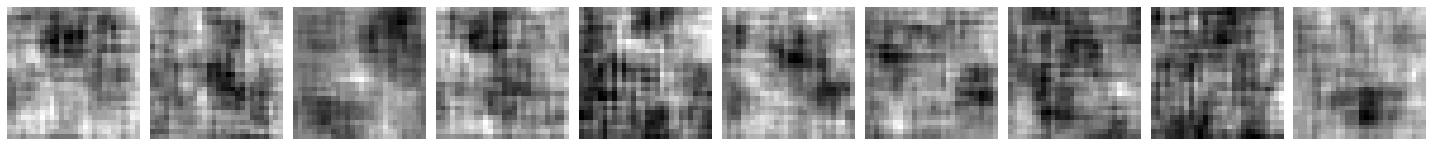

In [34]:
conditional_sample(cgan.generator, 10, latent_dim, gray=True)

Epoch 1/100
547/547 - 27s - loss: 1.6481 - d_loss: 0.5815 - g_loss: 1.0666


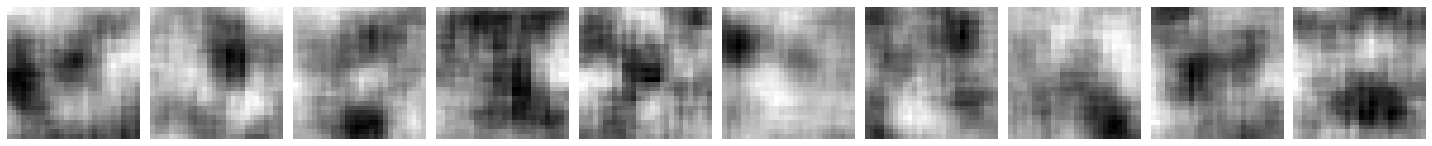

Epoch 2/100
547/547 - 26s - loss: 2.7804 - d_loss: 0.2424 - g_loss: 2.5379


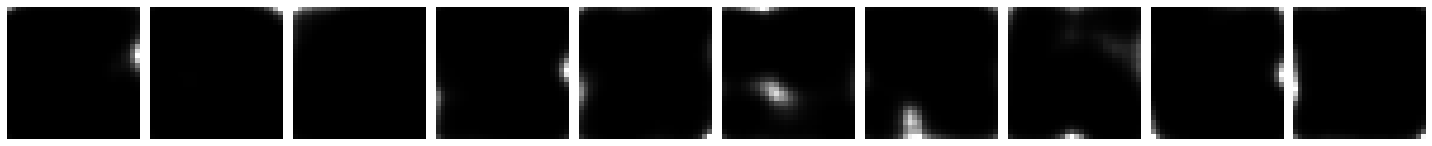

Epoch 3/100
547/547 - 26s - loss: 4.4304 - d_loss: 0.1640 - g_loss: 4.2664


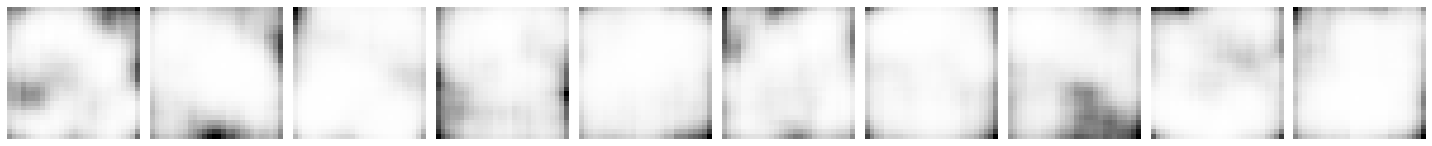

Epoch 4/100
547/547 - 26s - loss: 2.9391 - d_loss: 0.1630 - g_loss: 2.7760


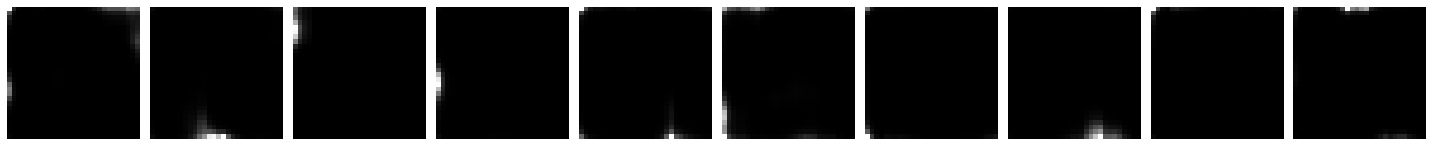

Epoch 5/100
547/547 - 26s - loss: 4.3084 - d_loss: 0.0235 - g_loss: 4.2849


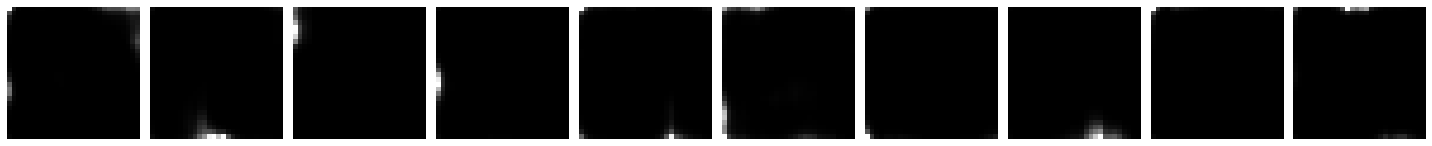

Epoch 6/100
547/547 - 26s - loss: 5.1903 - d_loss: 0.0102 - g_loss: 5.1801


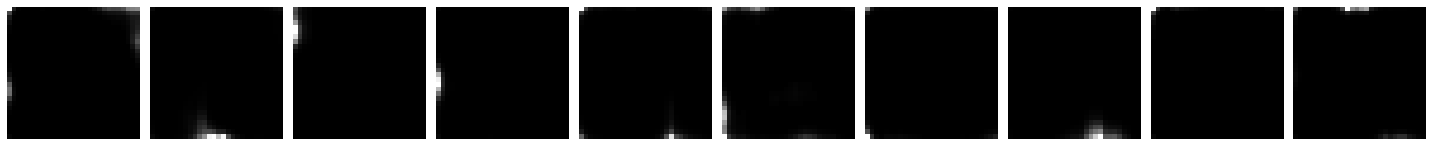

Epoch 7/100
547/547 - 26s - loss: 5.7568 - d_loss: 0.0059 - g_loss: 5.7509


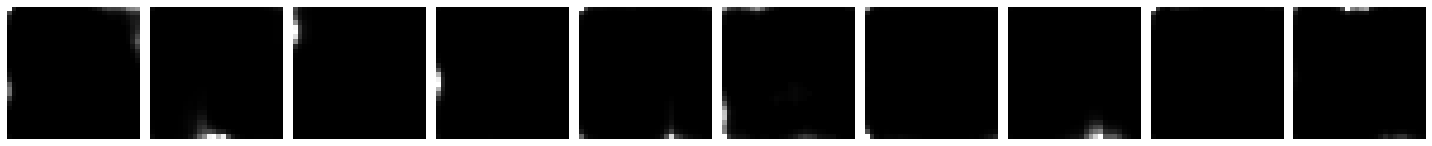

Epoch 8/100
547/547 - 26s - loss: 6.2258 - d_loss: 0.0038 - g_loss: 6.2220


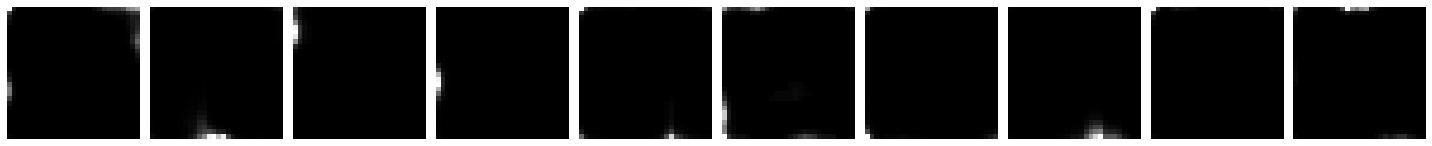

Epoch 9/100
547/547 - 26s - loss: 6.6349 - d_loss: 0.0026 - g_loss: 6.6323


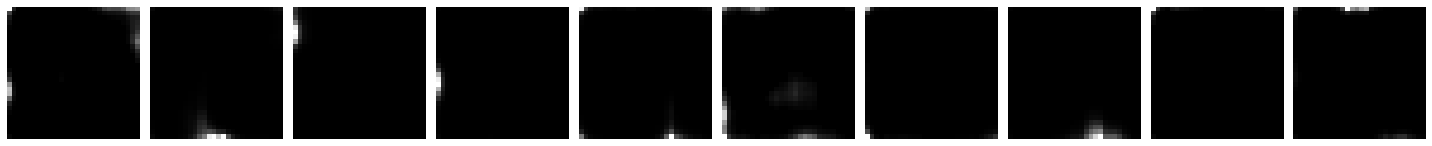

Epoch 10/100
547/547 - 26s - loss: 3.6183 - d_loss: 0.6739 - g_loss: 2.9444


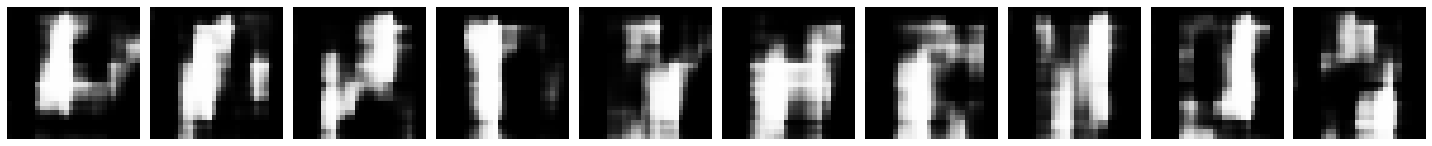

Epoch 11/100
547/547 - 26s - loss: 1.4126 - d_loss: 0.7232 - g_loss: 0.6894


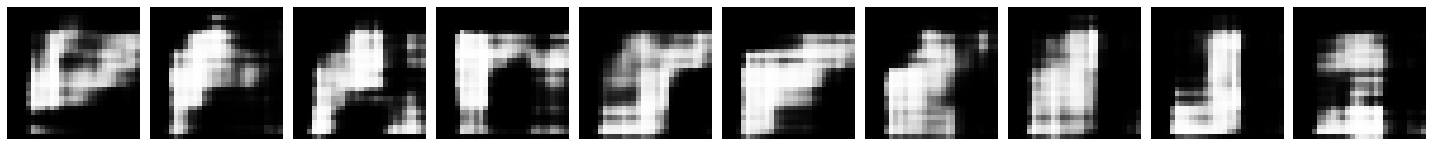

Epoch 12/100
547/547 - 26s - loss: 1.4336 - d_loss: 0.6693 - g_loss: 0.7643


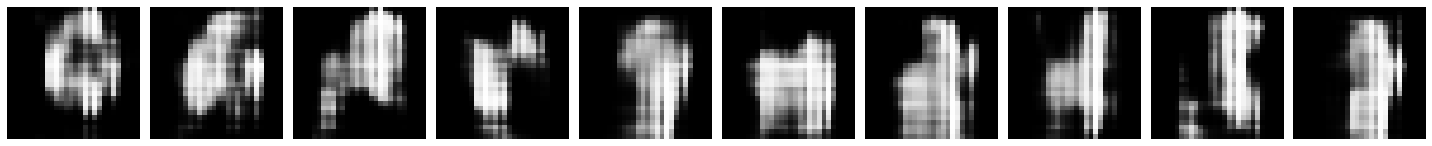

Epoch 13/100
547/547 - 26s - loss: 1.4389 - d_loss: 0.6779 - g_loss: 0.7609


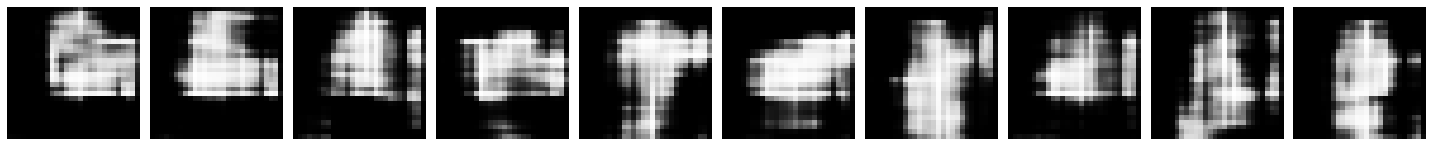

Epoch 14/100
547/547 - 26s - loss: 1.4091 - d_loss: 0.6558 - g_loss: 0.7533


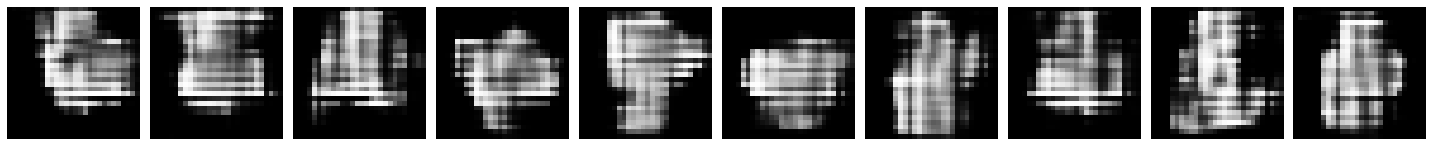

Epoch 15/100
547/547 - 26s - loss: 1.5901 - d_loss: 0.6298 - g_loss: 0.9604


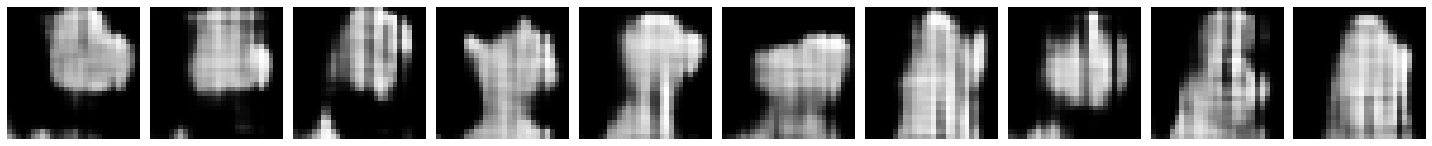

Epoch 16/100
547/547 - 26s - loss: 1.5311 - d_loss: 0.6248 - g_loss: 0.9063


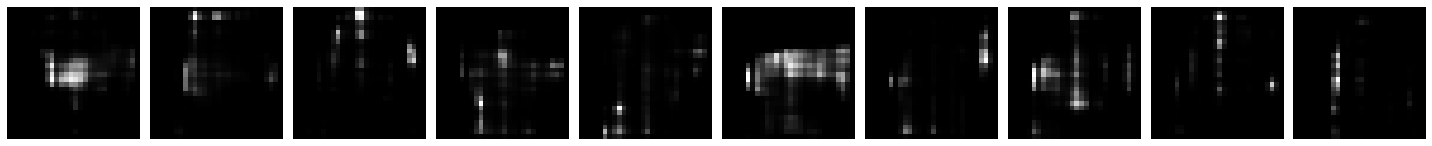

Epoch 17/100
547/547 - 26s - loss: 1.4294 - d_loss: 0.6615 - g_loss: 0.7679


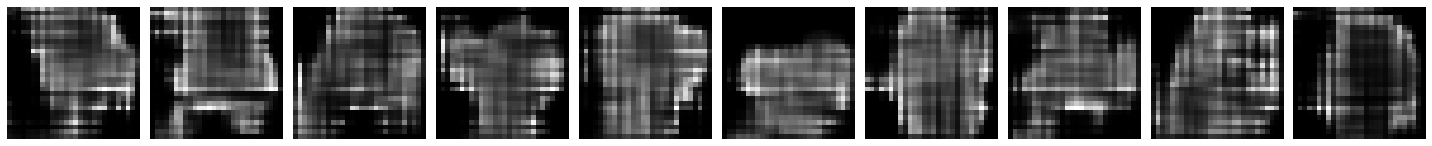

Epoch 18/100
547/547 - 26s - loss: 1.4726 - d_loss: 0.6328 - g_loss: 0.8397


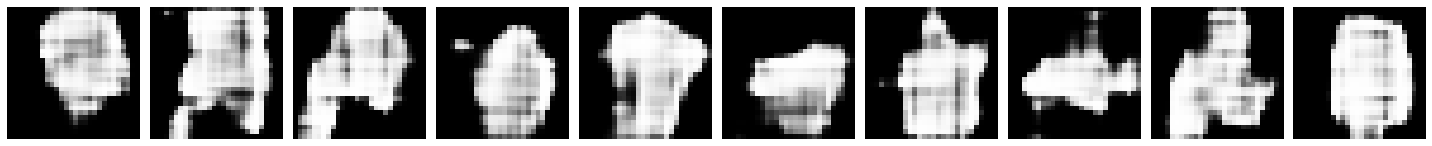

Epoch 19/100
547/547 - 26s - loss: 1.4570 - d_loss: 0.6341 - g_loss: 0.8229


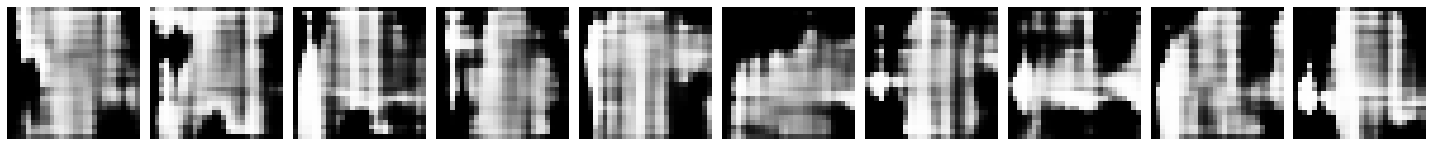

Epoch 20/100
547/547 - 26s - loss: 1.4620 - d_loss: 0.6319 - g_loss: 0.8301


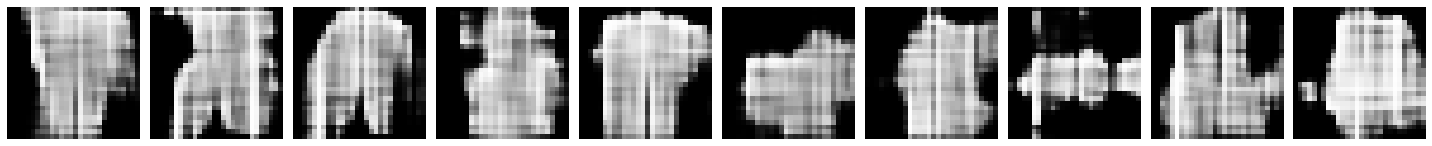

Epoch 21/100
547/547 - 26s - loss: 1.4773 - d_loss: 0.6326 - g_loss: 0.8447


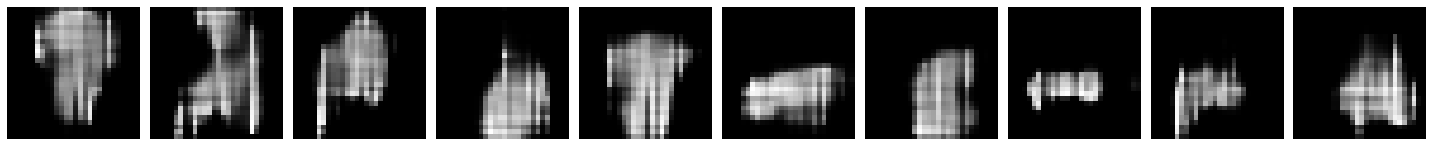

Epoch 22/100
547/547 - 26s - loss: 1.4352 - d_loss: 0.6231 - g_loss: 0.8121


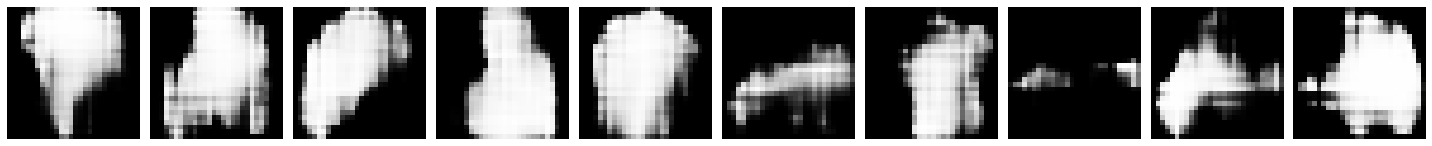

Epoch 23/100
547/547 - 26s - loss: 1.4643 - d_loss: 0.6211 - g_loss: 0.8432


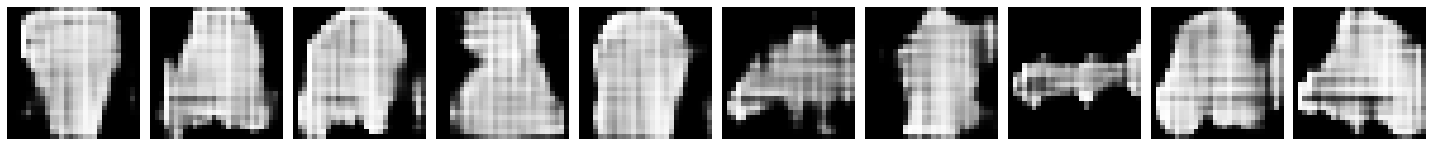

Epoch 24/100
547/547 - 26s - loss: 1.5005 - d_loss: 0.6313 - g_loss: 0.8692


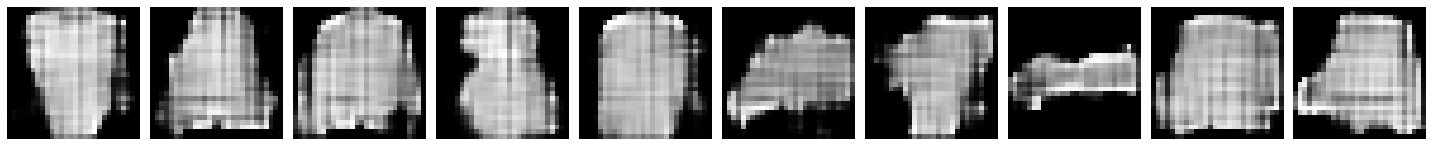

Epoch 25/100
547/547 - 26s - loss: 1.4637 - d_loss: 0.6186 - g_loss: 0.8451


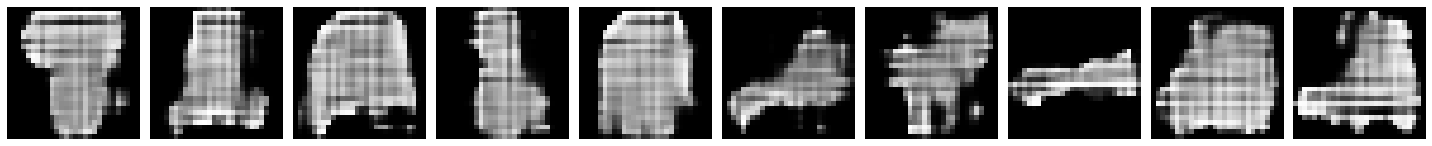

Epoch 26/100
547/547 - 26s - loss: 1.4923 - d_loss: 0.6259 - g_loss: 0.8663


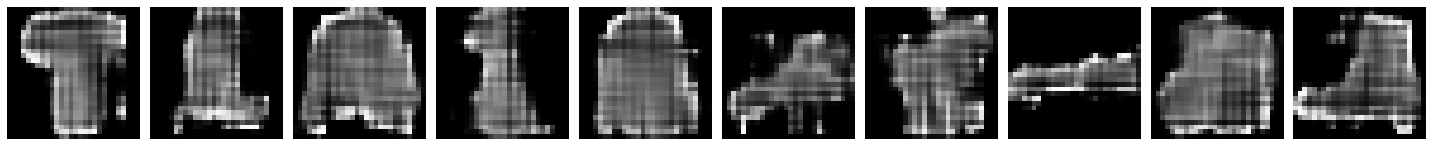

Epoch 27/100
547/547 - 26s - loss: 1.4981 - d_loss: 0.6236 - g_loss: 0.8744


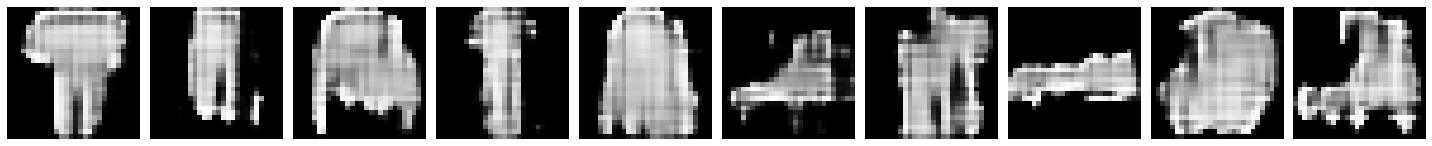

Epoch 28/100
547/547 - 26s - loss: 1.5098 - d_loss: 0.6118 - g_loss: 0.8981


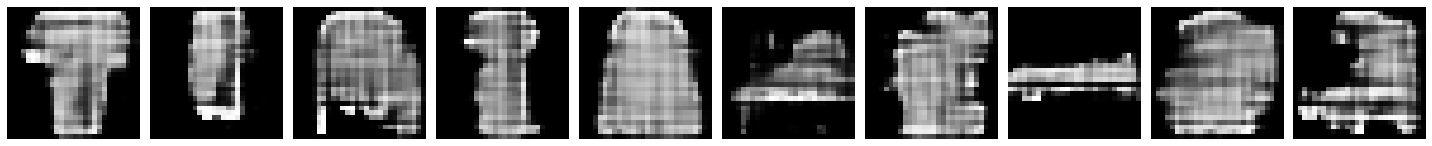

Epoch 29/100
547/547 - 26s - loss: 1.4784 - d_loss: 0.6238 - g_loss: 0.8546


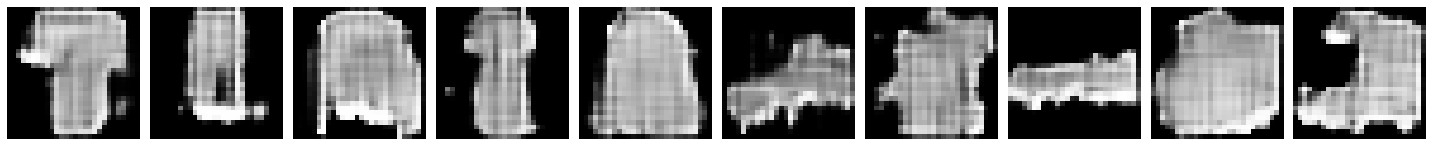

Epoch 30/100
547/547 - 26s - loss: 1.5012 - d_loss: 0.6210 - g_loss: 0.8801


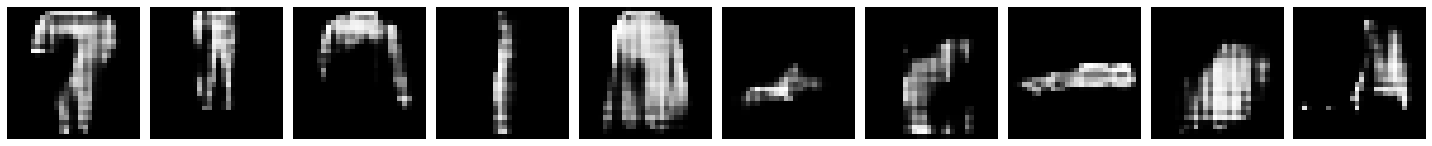

Epoch 31/100
547/547 - 26s - loss: 1.4989 - d_loss: 0.6244 - g_loss: 0.8745


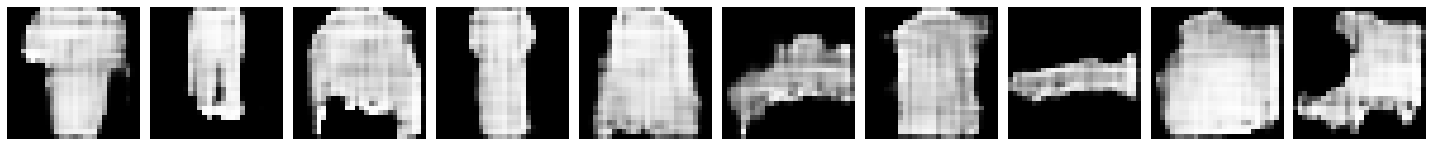

Epoch 32/100
547/547 - 26s - loss: 1.4795 - d_loss: 0.6358 - g_loss: 0.8437


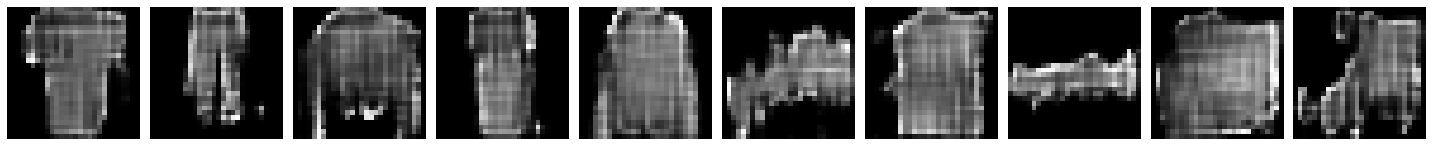

Epoch 33/100
547/547 - 26s - loss: 1.4989 - d_loss: 0.6251 - g_loss: 0.8737


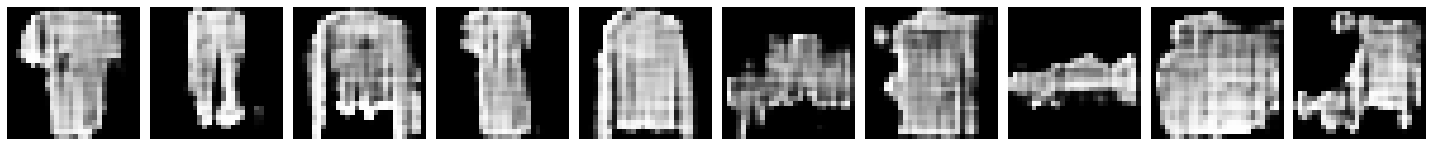

Epoch 34/100
547/547 - 26s - loss: 1.4857 - d_loss: 0.6216 - g_loss: 0.8641


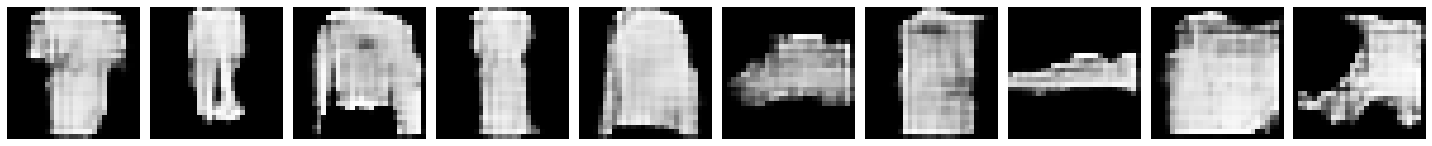

Epoch 35/100
547/547 - 26s - loss: 1.5039 - d_loss: 0.6186 - g_loss: 0.8853


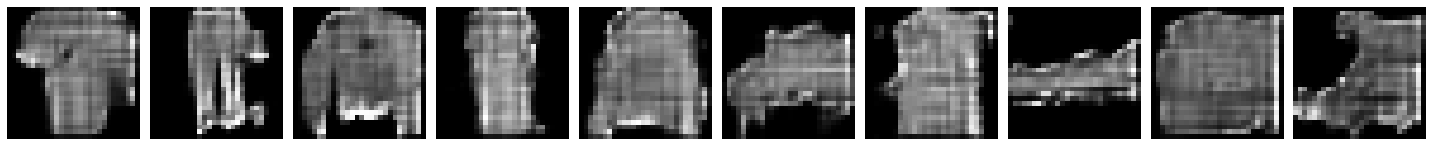

Epoch 36/100
547/547 - 26s - loss: 1.4964 - d_loss: 0.6302 - g_loss: 0.8662


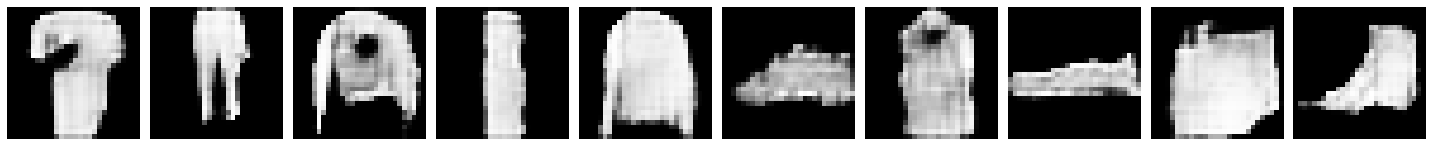

Epoch 37/100
547/547 - 26s - loss: 1.5310 - d_loss: 0.6227 - g_loss: 0.9083


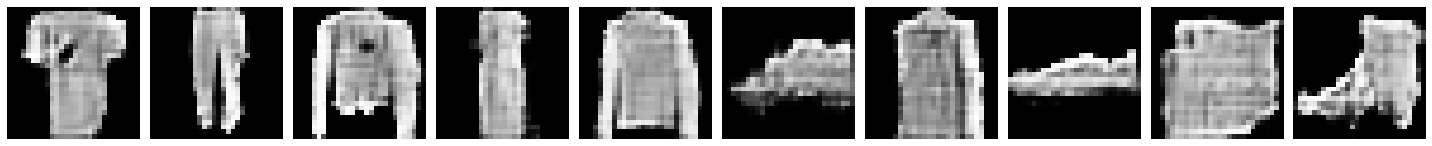

Epoch 38/100
547/547 - 26s - loss: 1.4998 - d_loss: 0.6305 - g_loss: 0.8693


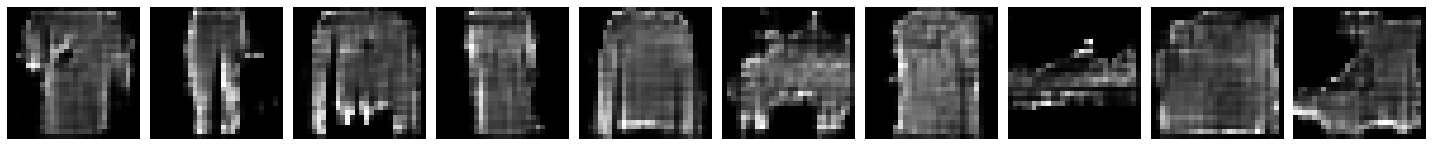

Epoch 39/100
547/547 - 26s - loss: 1.6109 - d_loss: 0.6307 - g_loss: 0.9801


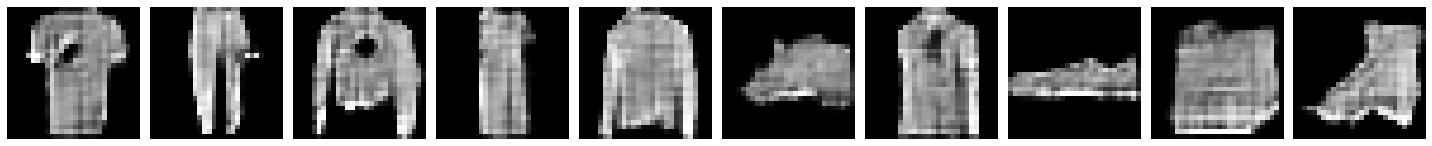

Epoch 40/100
547/547 - 26s - loss: 1.4545 - d_loss: 0.6281 - g_loss: 0.8264


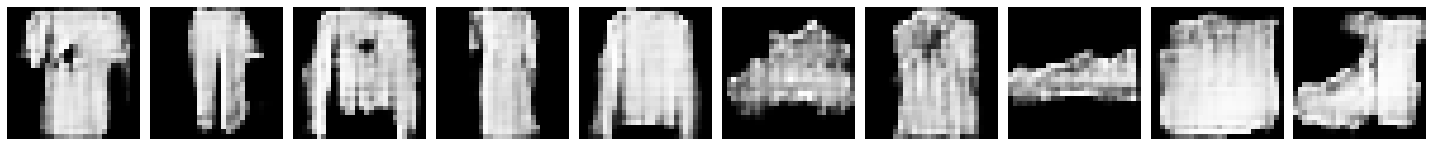

Epoch 41/100
547/547 - 26s - loss: 1.5135 - d_loss: 0.6309 - g_loss: 0.8826


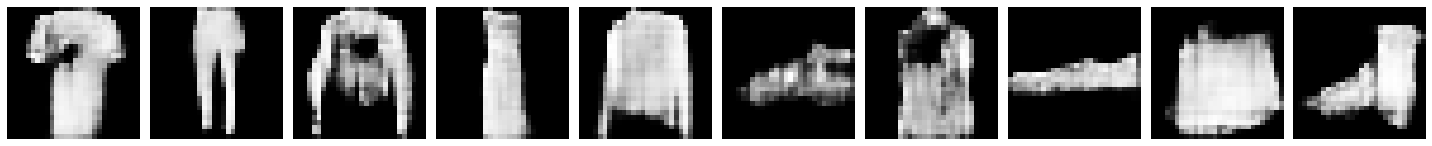

Epoch 42/100
547/547 - 26s - loss: 1.4936 - d_loss: 0.6230 - g_loss: 0.8707


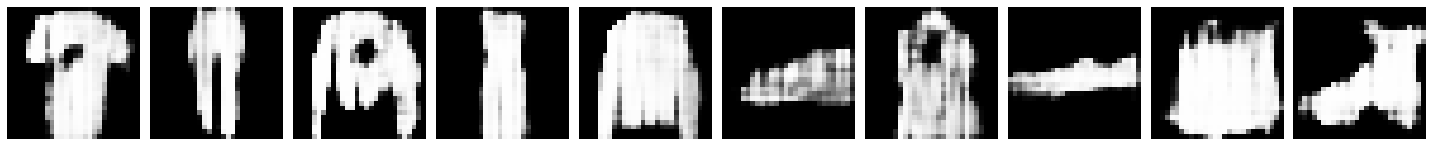

Epoch 43/100
547/547 - 26s - loss: 1.5077 - d_loss: 0.6442 - g_loss: 0.8635


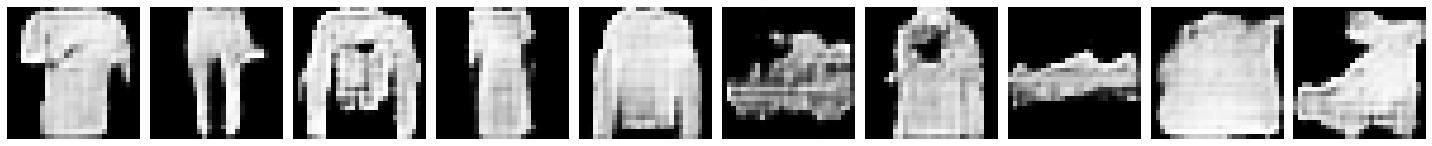

Epoch 44/100
547/547 - 26s - loss: 1.4988 - d_loss: 0.6319 - g_loss: 0.8669


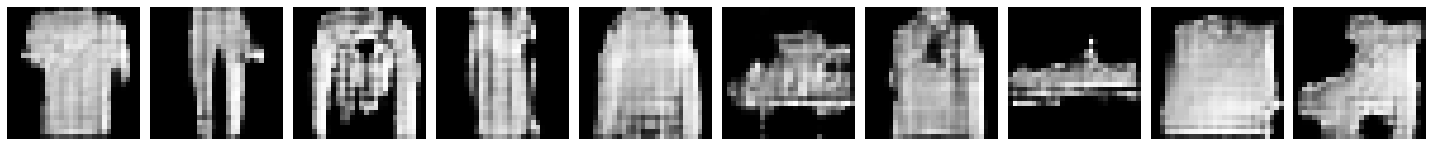

Epoch 45/100
547/547 - 26s - loss: 1.5280 - d_loss: 0.6300 - g_loss: 0.8980


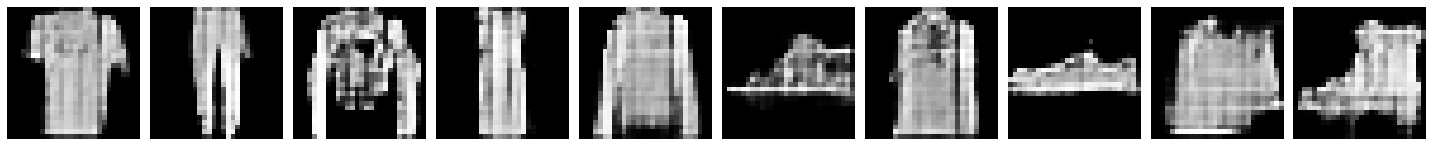

Epoch 46/100
547/547 - 26s - loss: 1.4708 - d_loss: 0.6417 - g_loss: 0.8292


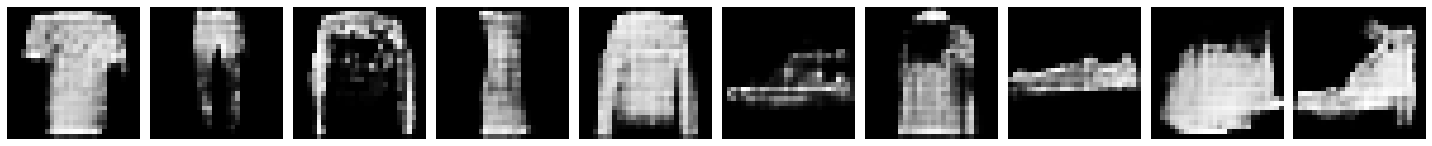

Epoch 47/100
547/547 - 26s - loss: 1.5111 - d_loss: 0.6469 - g_loss: 0.8641


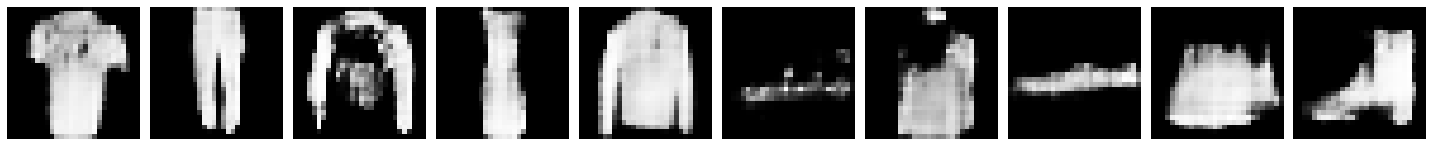

Epoch 48/100
547/547 - 26s - loss: 1.4860 - d_loss: 0.6276 - g_loss: 0.8584


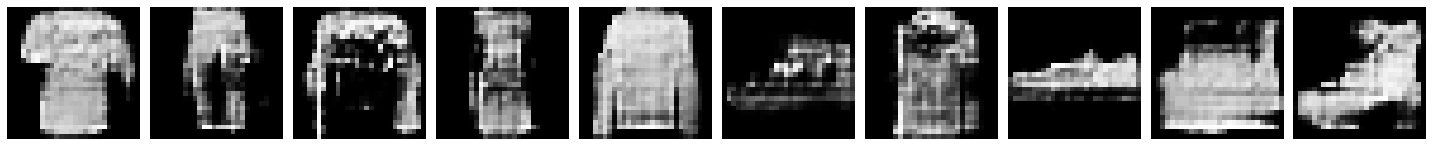

Epoch 49/100
547/547 - 26s - loss: 1.4949 - d_loss: 0.6370 - g_loss: 0.8578


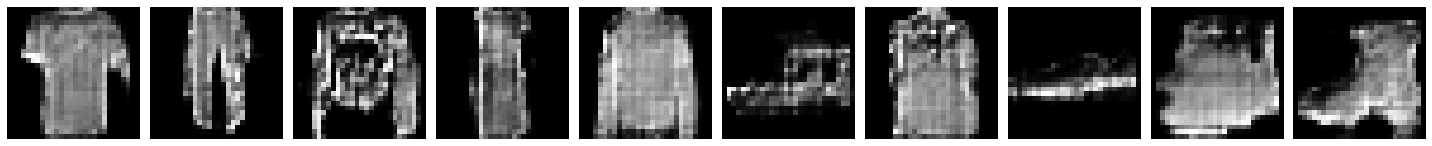

Epoch 50/100
547/547 - 26s - loss: 1.4989 - d_loss: 0.6419 - g_loss: 0.8570


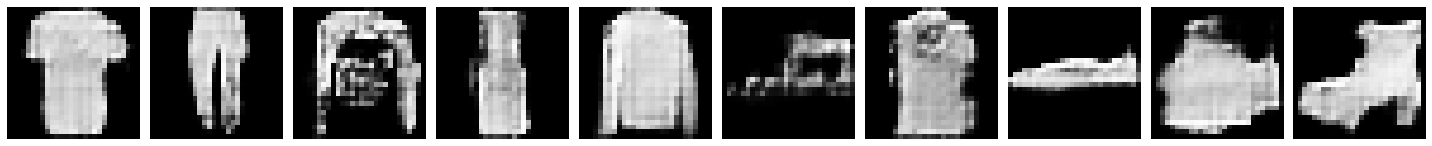

Epoch 51/100
547/547 - 26s - loss: 1.4904 - d_loss: 0.6350 - g_loss: 0.8554


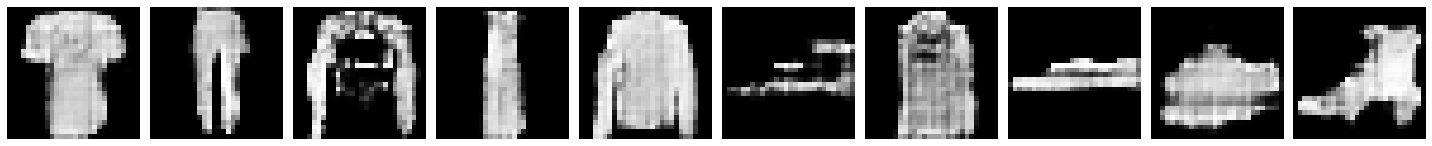

Epoch 52/100
547/547 - 26s - loss: 1.4919 - d_loss: 0.6409 - g_loss: 0.8510


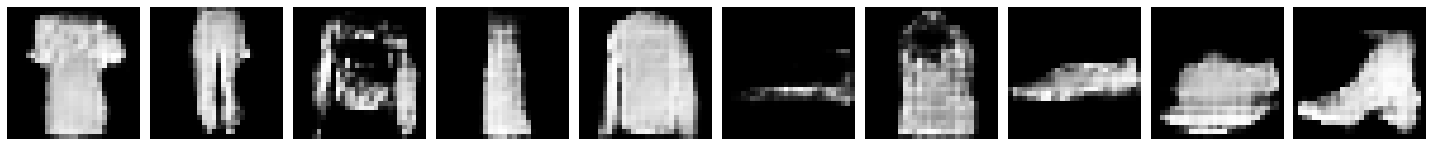

Epoch 53/100
547/547 - 26s - loss: 1.4675 - d_loss: 0.6351 - g_loss: 0.8324


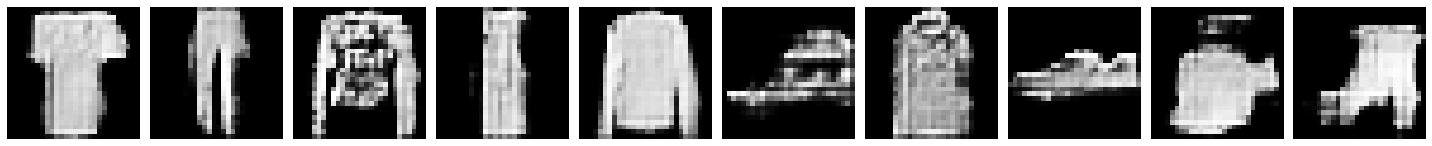

Epoch 54/100
547/547 - 26s - loss: 1.5268 - d_loss: 0.6389 - g_loss: 0.8880


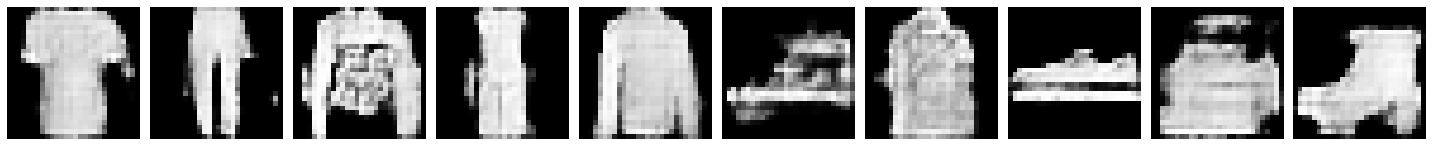

Epoch 55/100
547/547 - 26s - loss: 1.4706 - d_loss: 0.6434 - g_loss: 0.8271


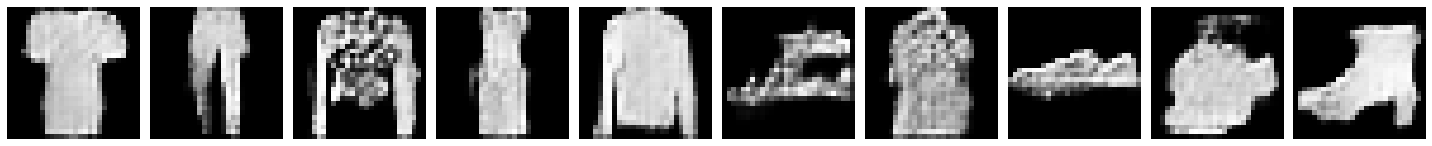

Epoch 56/100
547/547 - 26s - loss: 1.4567 - d_loss: 0.6464 - g_loss: 0.8104


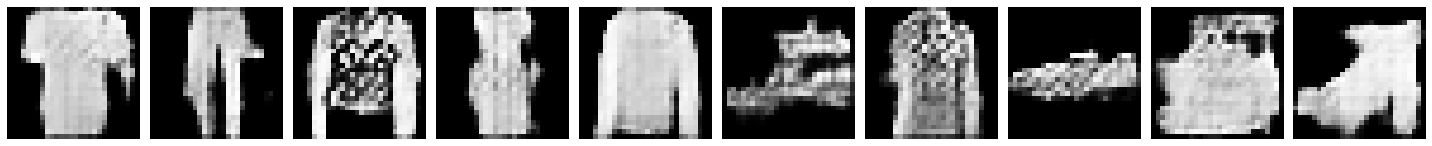

Epoch 57/100
547/547 - 26s - loss: 1.5037 - d_loss: 0.6475 - g_loss: 0.8561


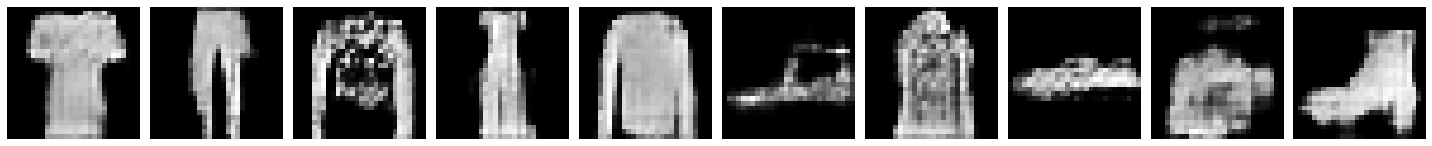

Epoch 58/100
547/547 - 26s - loss: 1.4608 - d_loss: 0.6376 - g_loss: 0.8231


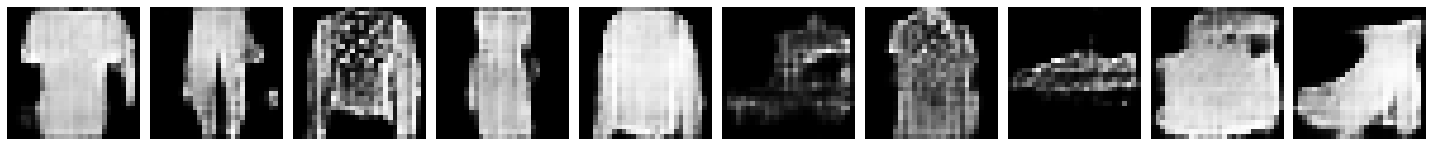

Epoch 59/100
547/547 - 26s - loss: 1.4639 - d_loss: 0.6466 - g_loss: 0.8173


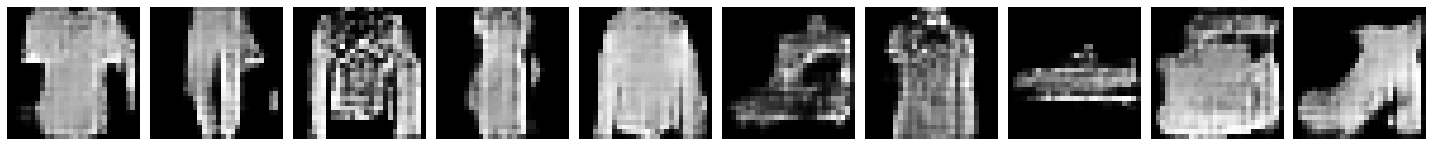

Epoch 60/100
547/547 - 26s - loss: 1.5143 - d_loss: 0.6535 - g_loss: 0.8608


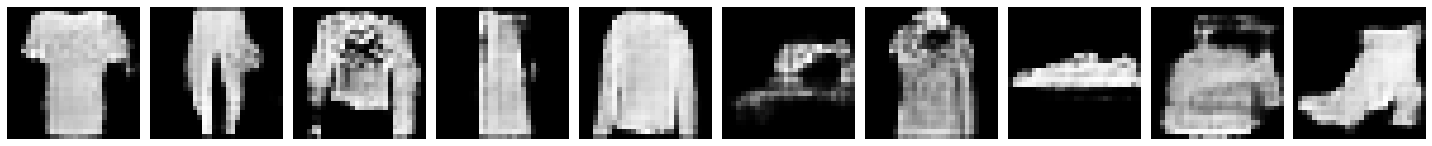

Epoch 61/100
547/547 - 26s - loss: 1.4575 - d_loss: 0.6611 - g_loss: 0.7964


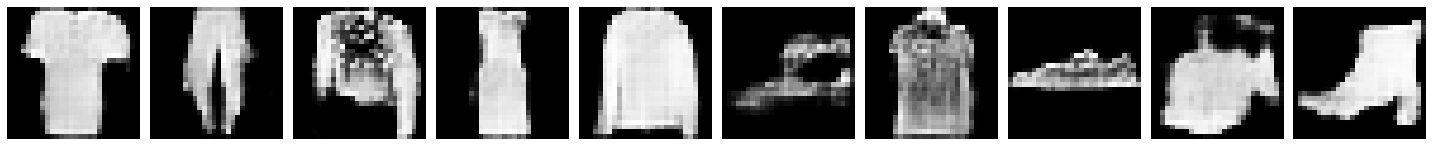

Epoch 62/100
547/547 - 26s - loss: 1.4452 - d_loss: 0.6553 - g_loss: 0.7899


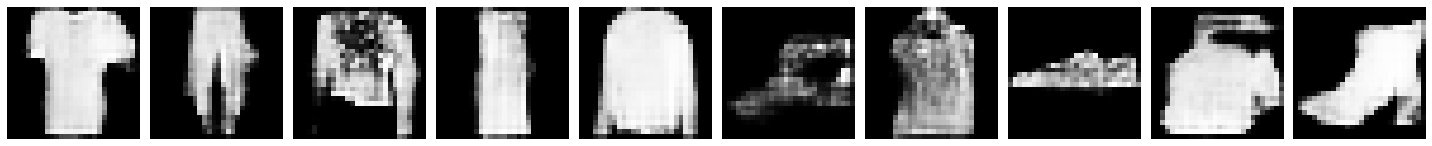

Epoch 63/100
547/547 - 26s - loss: 1.4743 - d_loss: 0.6536 - g_loss: 0.8207


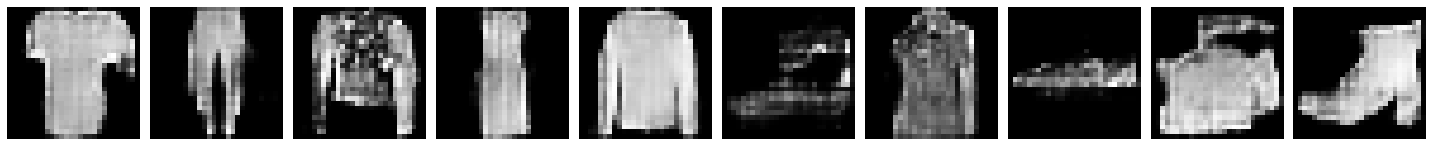

Epoch 64/100
547/547 - 26s - loss: 1.4384 - d_loss: 0.6591 - g_loss: 0.7794


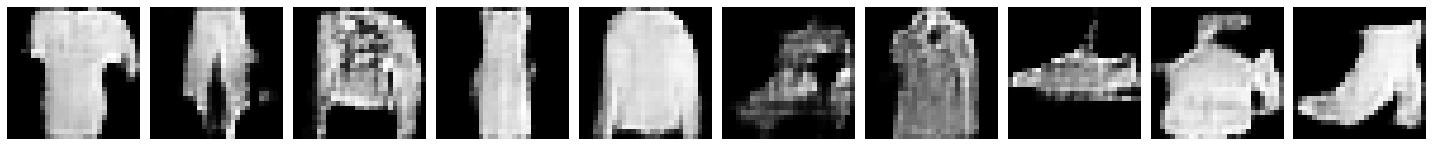

Epoch 65/100
547/547 - 26s - loss: 1.4722 - d_loss: 0.6638 - g_loss: 0.8084


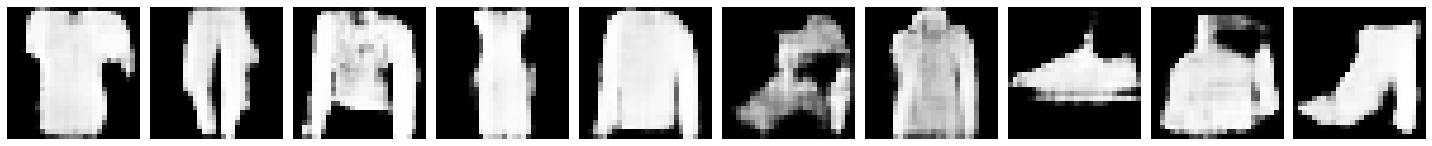

Epoch 66/100
547/547 - 26s - loss: 1.4838 - d_loss: 0.6565 - g_loss: 0.8273


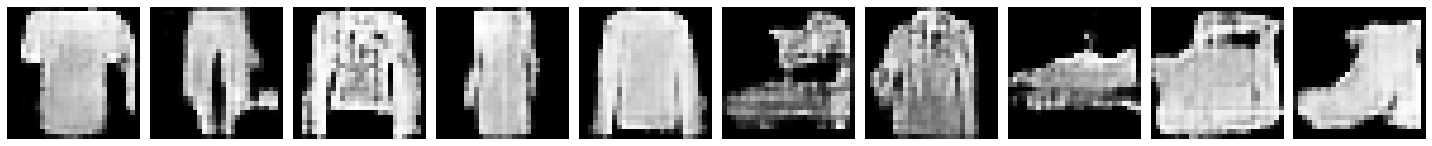

Epoch 67/100
547/547 - 26s - loss: 1.4497 - d_loss: 0.6596 - g_loss: 0.7901


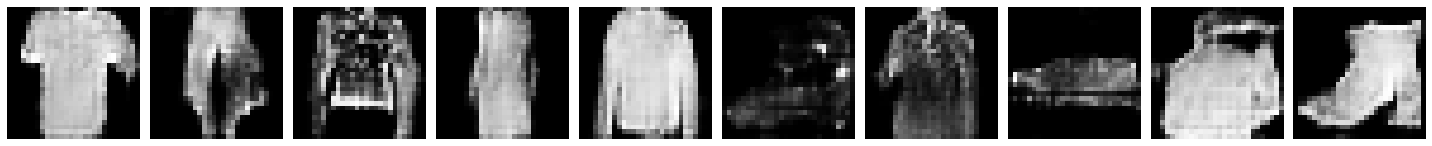

Epoch 68/100
547/547 - 26s - loss: 1.4323 - d_loss: 0.6618 - g_loss: 0.7705


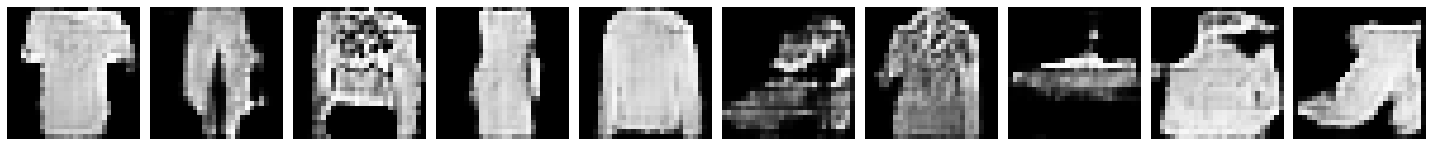

Epoch 69/100
547/547 - 26s - loss: 1.4504 - d_loss: 0.6596 - g_loss: 0.7907


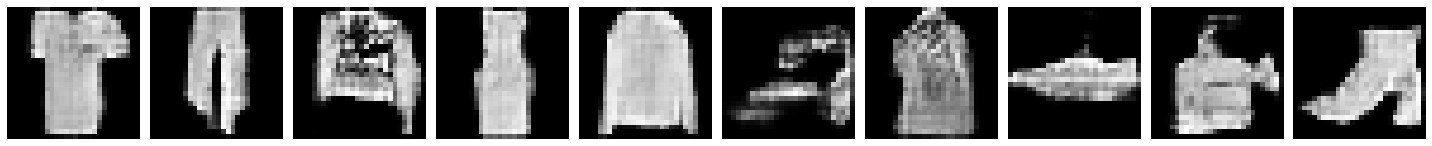

Epoch 70/100
547/547 - 26s - loss: 1.4553 - d_loss: 0.6626 - g_loss: 0.7926


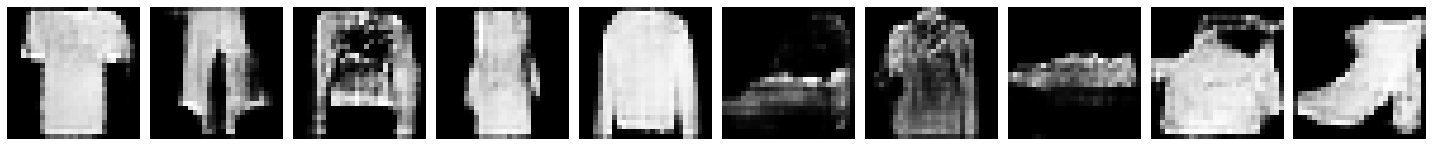

Epoch 71/100
547/547 - 26s - loss: 1.4554 - d_loss: 0.6598 - g_loss: 0.7956


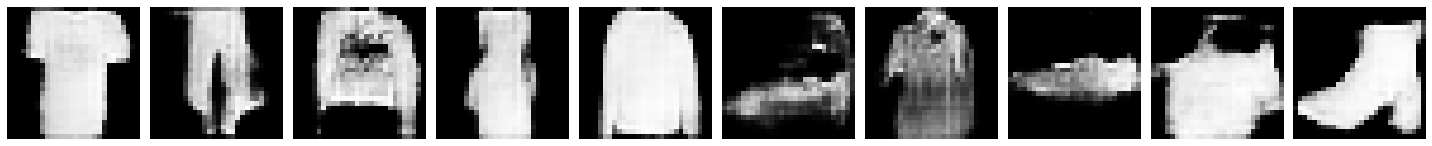

Epoch 72/100
547/547 - 26s - loss: 1.4501 - d_loss: 0.6538 - g_loss: 0.7963


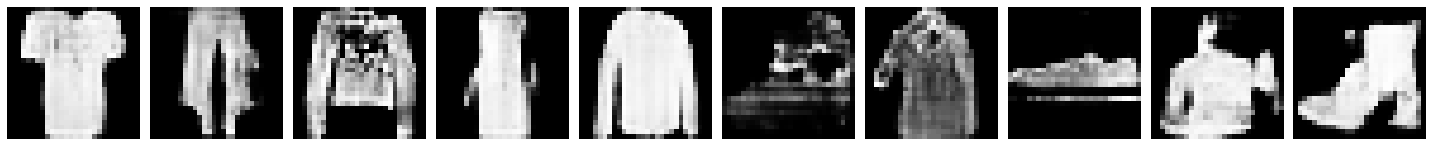

Epoch 73/100
547/547 - 26s - loss: 1.4866 - d_loss: 0.6593 - g_loss: 0.8272


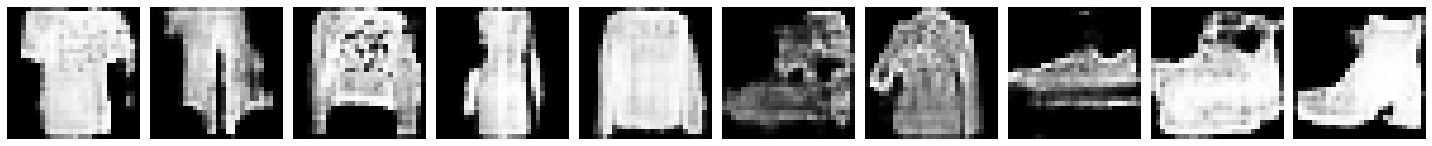

Epoch 74/100
547/547 - 26s - loss: 1.4354 - d_loss: 0.6533 - g_loss: 0.7820


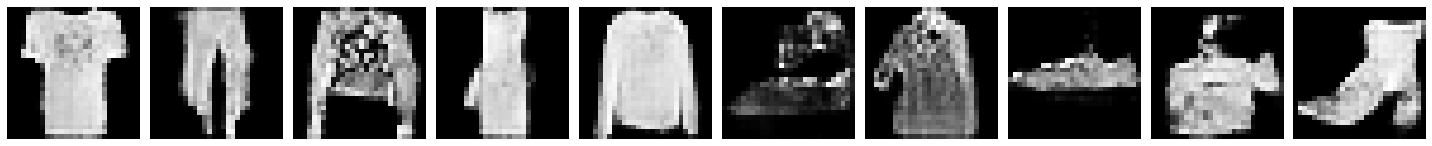

Epoch 75/100
547/547 - 26s - loss: 1.4305 - d_loss: 0.6574 - g_loss: 0.7731


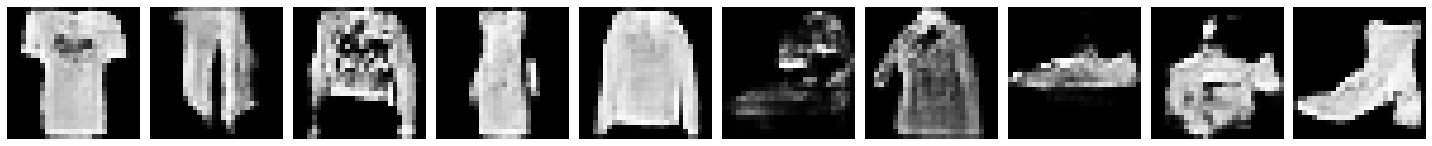

Epoch 76/100
547/547 - 26s - loss: 1.4752 - d_loss: 0.6536 - g_loss: 0.8215


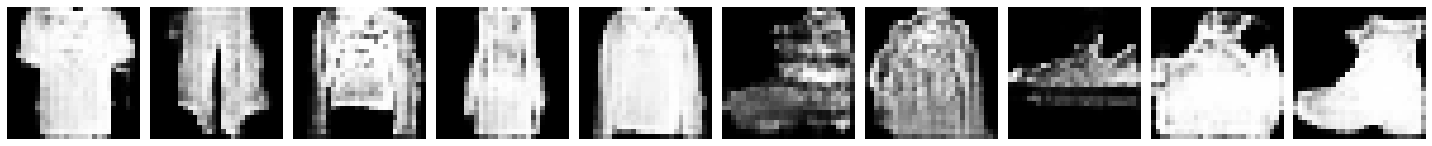

Epoch 77/100
547/547 - 26s - loss: 1.4728 - d_loss: 0.6576 - g_loss: 0.8152


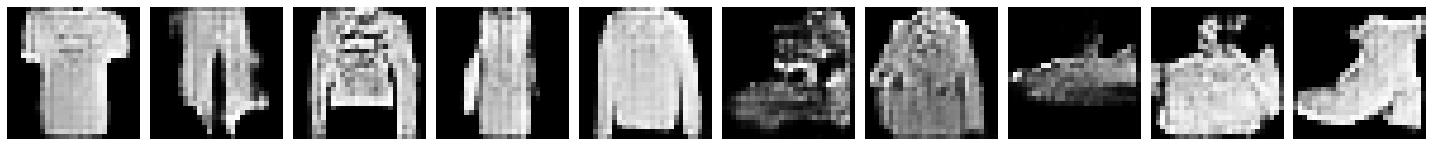

Epoch 78/100
547/547 - 26s - loss: 1.4390 - d_loss: 0.6544 - g_loss: 0.7845


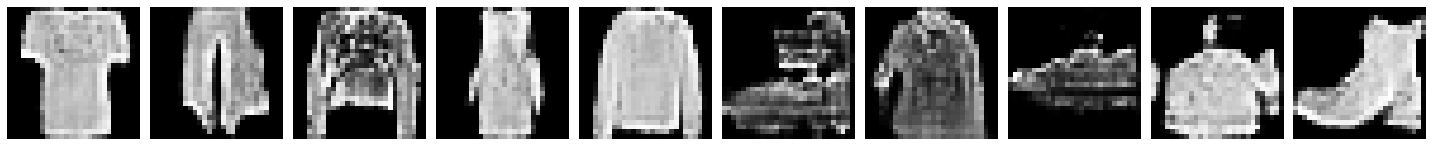

Epoch 79/100
547/547 - 26s - loss: 1.4522 - d_loss: 0.6555 - g_loss: 0.7967


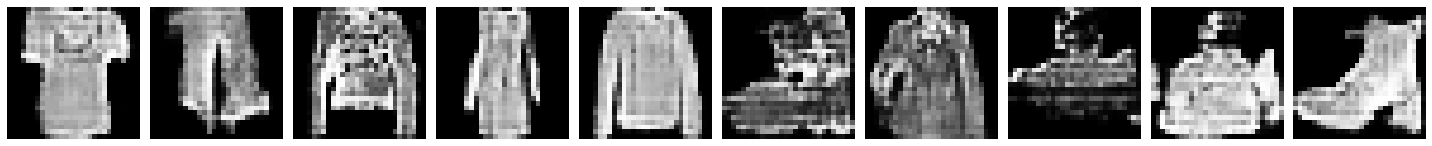

Epoch 80/100
547/547 - 26s - loss: 1.4624 - d_loss: 0.6567 - g_loss: 0.8056


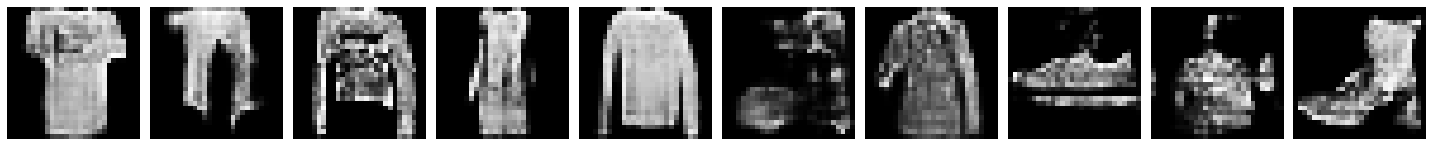

Epoch 81/100
547/547 - 26s - loss: 1.4676 - d_loss: 0.6523 - g_loss: 0.8153


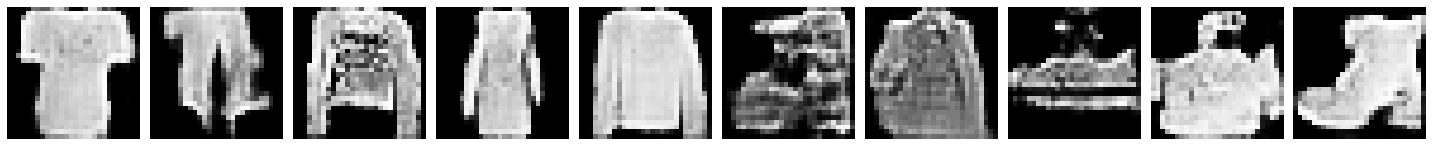

Epoch 82/100
547/547 - 26s - loss: 1.4382 - d_loss: 0.6634 - g_loss: 0.7748


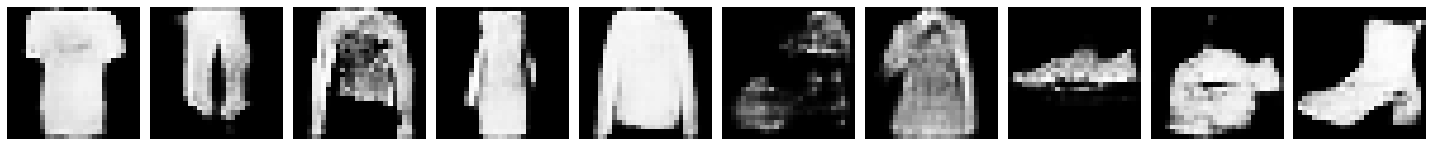

Epoch 83/100
547/547 - 26s - loss: 1.4375 - d_loss: 0.6605 - g_loss: 0.7770


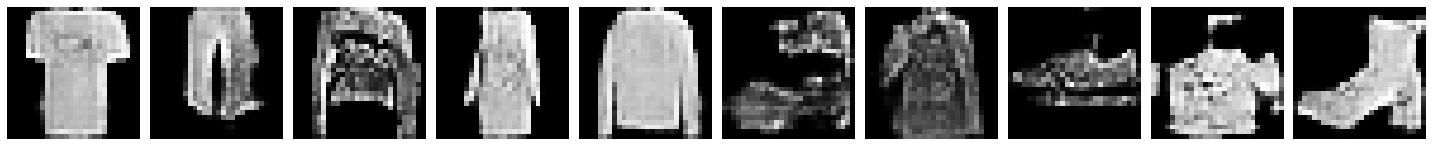

Epoch 84/100
547/547 - 26s - loss: 1.4402 - d_loss: 0.6632 - g_loss: 0.7770


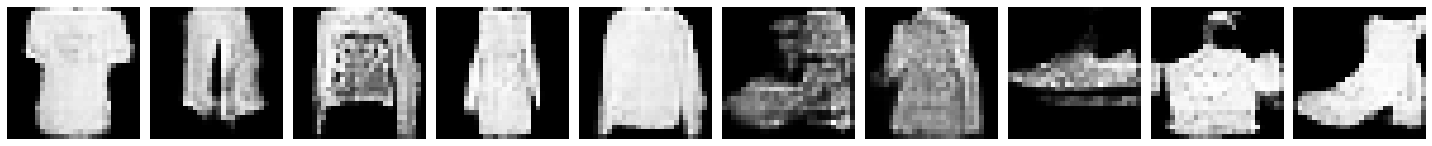

Epoch 85/100
547/547 - 26s - loss: 1.4573 - d_loss: 0.6613 - g_loss: 0.7960


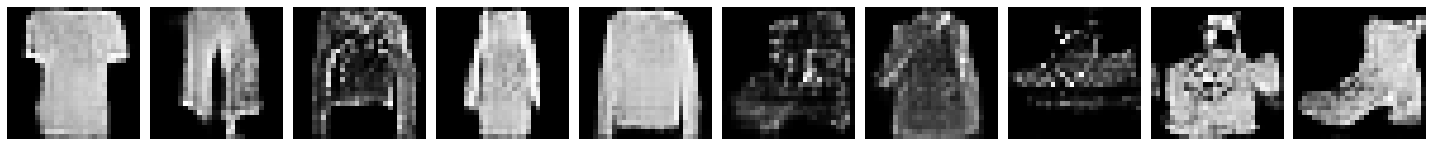

Epoch 86/100
547/547 - 26s - loss: 1.4324 - d_loss: 0.6600 - g_loss: 0.7724


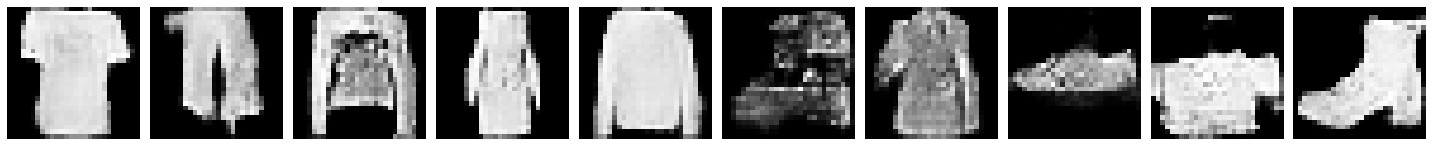

Epoch 87/100
547/547 - 26s - loss: 1.4709 - d_loss: 0.6595 - g_loss: 0.8114


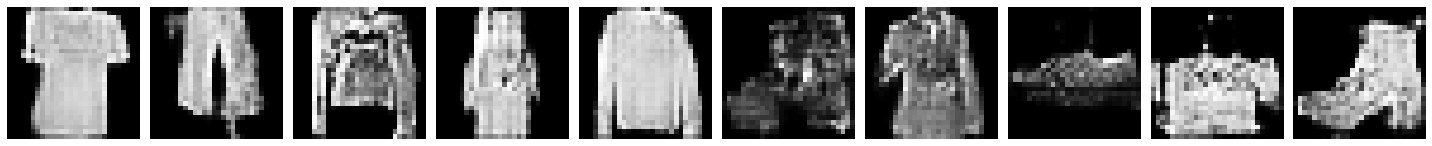

Epoch 88/100
547/547 - 26s - loss: 1.4424 - d_loss: 0.6645 - g_loss: 0.7779


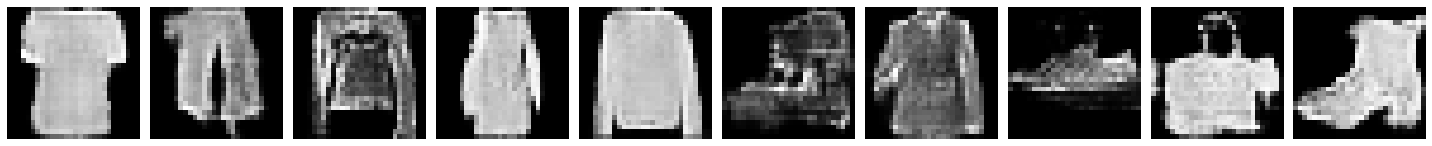

Epoch 89/100
547/547 - 26s - loss: 1.4377 - d_loss: 0.6640 - g_loss: 0.7737


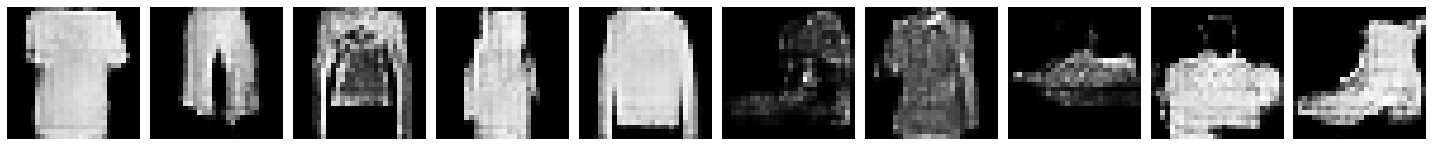

Epoch 90/100
547/547 - 26s - loss: 1.4695 - d_loss: 0.6611 - g_loss: 0.8084


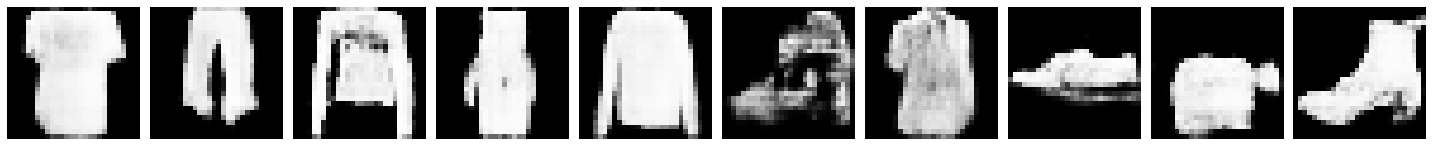

Epoch 91/100
547/547 - 26s - loss: 1.4659 - d_loss: 0.6564 - g_loss: 0.8095


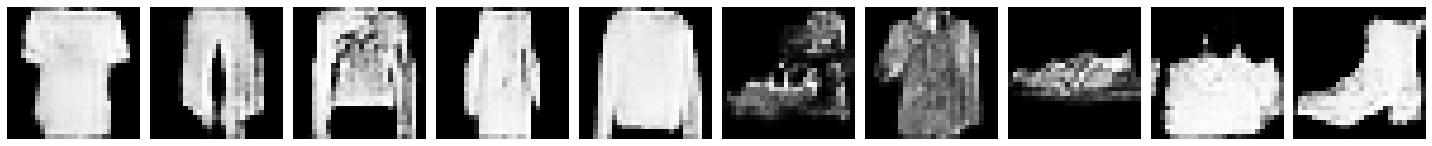

Epoch 92/100
547/547 - 26s - loss: 1.4449 - d_loss: 0.6587 - g_loss: 0.7862


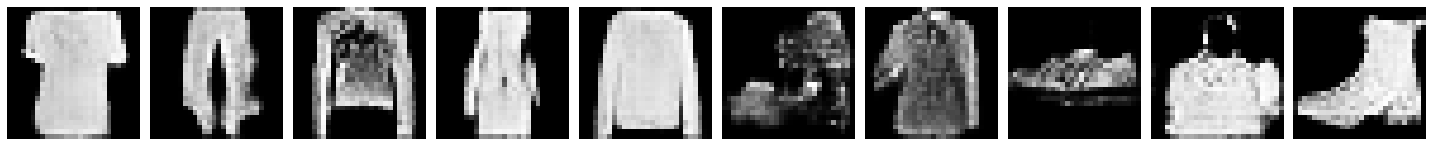

Epoch 93/100
547/547 - 26s - loss: 1.4237 - d_loss: 0.6642 - g_loss: 0.7595


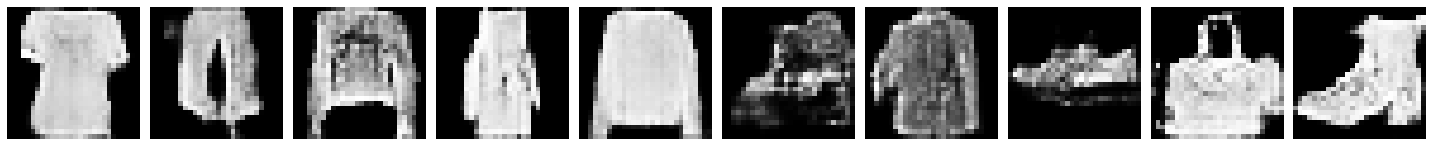

Epoch 94/100
547/547 - 26s - loss: 1.4651 - d_loss: 0.6621 - g_loss: 0.8029


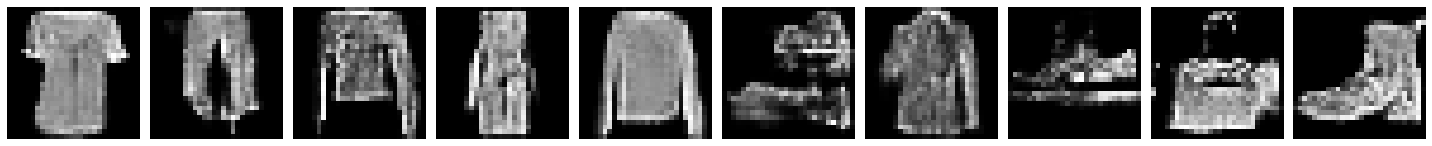

Epoch 95/100
547/547 - 26s - loss: 1.4449 - d_loss: 0.6605 - g_loss: 0.7845


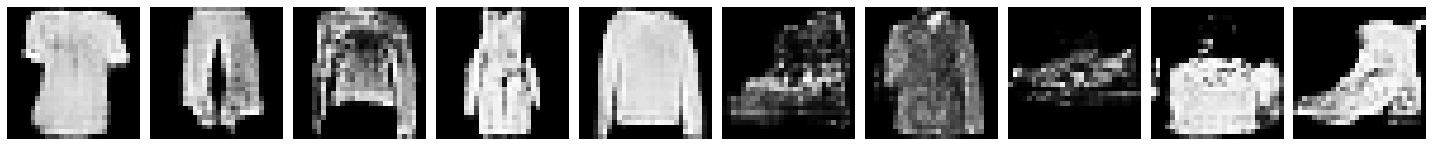

Epoch 96/100
547/547 - 26s - loss: 1.4334 - d_loss: 0.6657 - g_loss: 0.7677


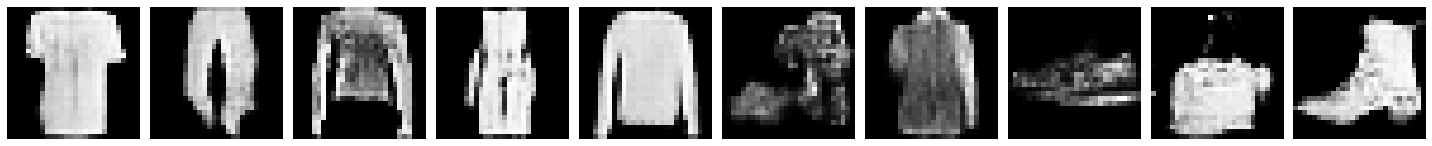

Epoch 97/100
547/547 - 26s - loss: 1.4373 - d_loss: 0.6595 - g_loss: 0.7778


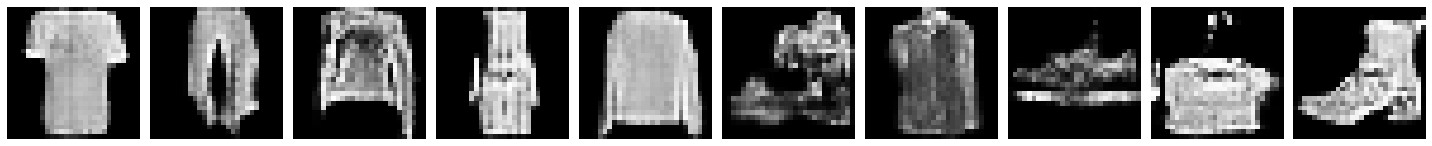

Epoch 98/100
547/547 - 26s - loss: 1.4640 - d_loss: 0.6613 - g_loss: 0.8028


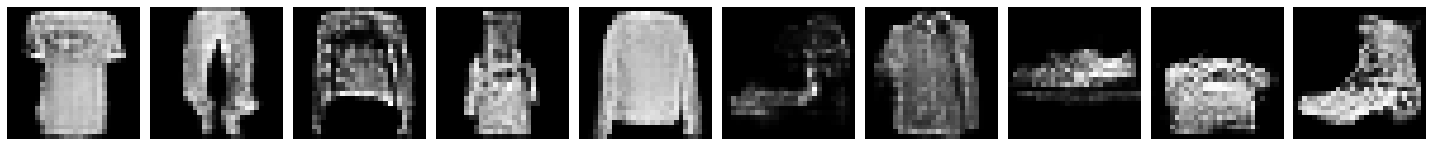

Epoch 99/100
547/547 - 26s - loss: 1.4430 - d_loss: 0.6619 - g_loss: 0.7810


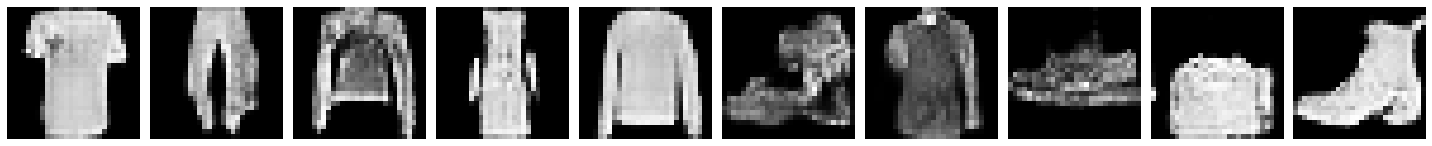

Epoch 100/100
547/547 - 26s - loss: 1.4271 - d_loss: 0.6685 - g_loss: 0.7586


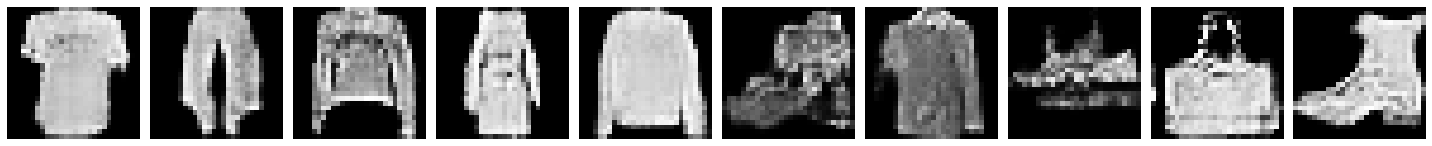

In [35]:
c_history = cgan.fit(
    dataset, 
    epochs = epochs, 
    callbacks = [ConditionalGANMonitor(name='conditional', gray=True)],
    verbose = 2
).history

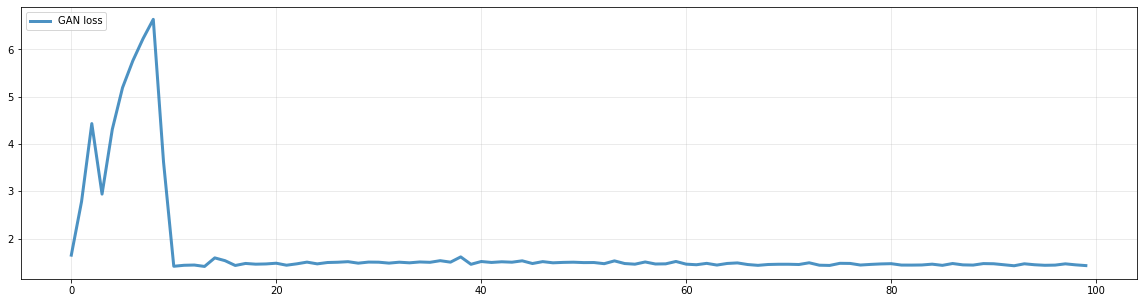

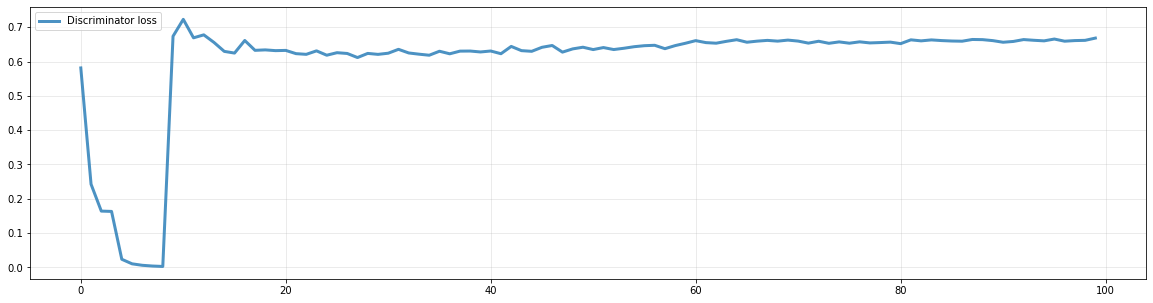

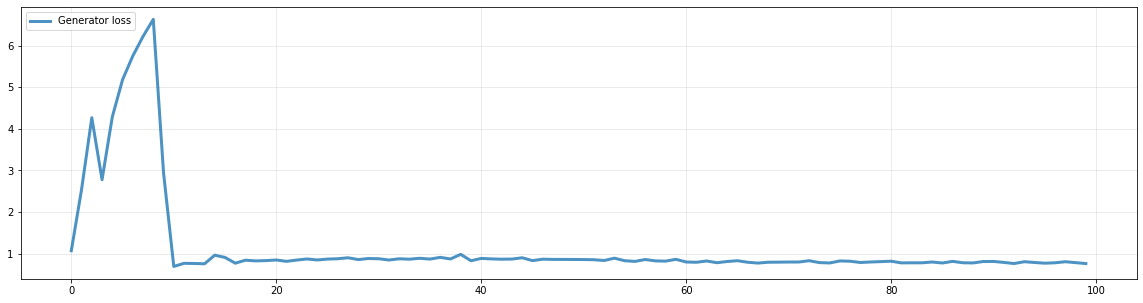

In [36]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(c_history['loss'], label='GAN loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(c_history['d_loss'], label='Discriminator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(c_history['g_loss'], label='Generator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)
plt.show()

In [37]:
cgan.generator.save('conditional_gan_generator')

In [38]:
conditional_gan_generator = tfk.models.load_model('conditional_gan_generator')

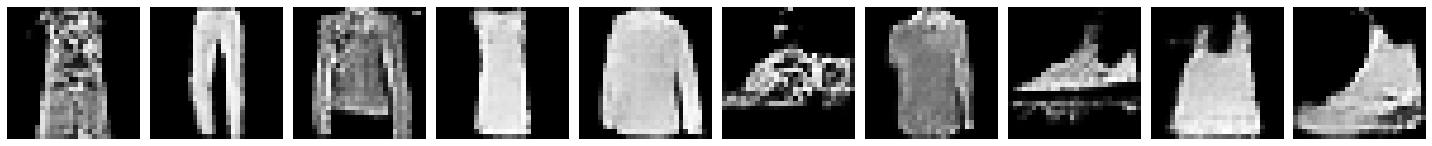

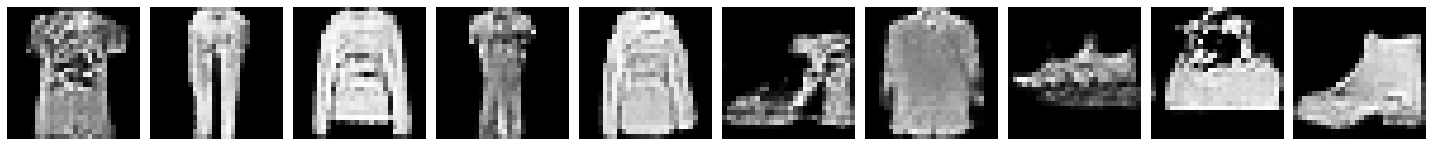

In [39]:
conditional_sample(conditional_gan_generator, 10, latent_dim, fixed=False, gray=True)
conditional_sample(conditional_gan_generator, 10, latent_dim, fixed=False, gray=True)

In [40]:
imgs = 2500
X_hat, y_hat = generate_conditional_dataset(conditional_gan_generator, imgs, latent_dim)
X_hat = np.reshape(X_hat, (X_hat.shape[0],X_hat.shape[1]*X_hat.shape[2]))*127.5 + 127+5
X_hat = np.mean(X_hat, axis=0)
y_hat = np.argmax(y_hat,axis=1)

X_temp = X[:imgs]*127.5 + 127+5
X_temp = np.reshape(X_temp, (X_temp.shape[0],X_temp.shape[1]*X_temp.shape[2]))
X_temp = np.mean(X_temp, axis=0)
y_temp = y[:imgs]

print(X_hat.shape, X_temp.shape)

(784,) (784,)


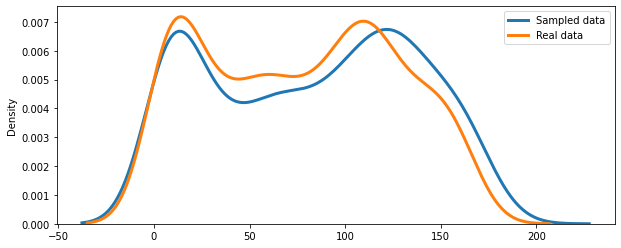

In [41]:
plt.figure(figsize=(10,4))
sns.kdeplot(x=X_hat, label='Sampled data', linewidth=3)
sns.kdeplot(x=X_temp, label='Real data', linewidth=3)
plt.legend()
plt.show()

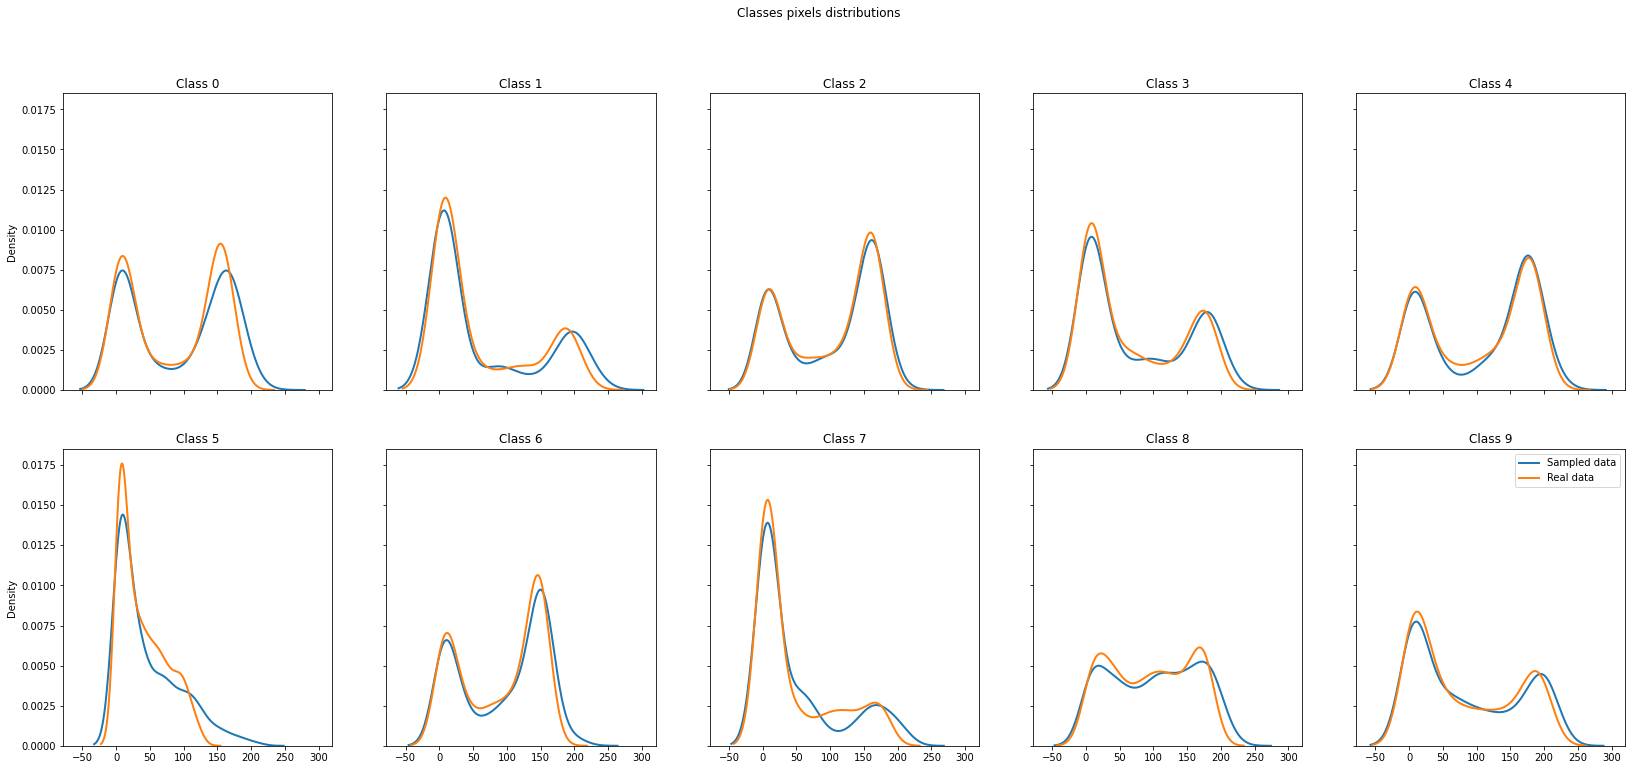

In [42]:
imgs = 1000
fig, axes = plt.subplots(2, 5, figsize=(28,12), sharey=True, sharex=True)
fig.suptitle('Classes pixels distributions')
for i in range(10):
    X_hat, y_hat = generate_conditional_dataset(conditional_gan_generator, imgs, latent_dim, label=i)
    X_hat = np.reshape(X_hat, (X_hat.shape[0],X_hat.shape[1]*X_hat.shape[2]))*127.5 + 127+5
    X_hat = np.mean(X_hat, axis=0)
    X_temp = X[y==i][:imgs]*127.5 + 127+5
    X_temp = np.reshape(X_temp, (X_temp.shape[0],X_temp.shape[1]*X_temp.shape[2]))
    X_temp = np.mean(X_temp, axis=0)
    axes[i//5, i%5].set_title(f'Class {i}')
    sns.kdeplot(ax=axes[i//5, i%5], x=X_hat, label='Sampled data', linewidth=2)
    sns.kdeplot(ax=axes[i//5, i%5], x=X_temp, label='Real data', linewidth=2)
plt.legend()
plt.show()

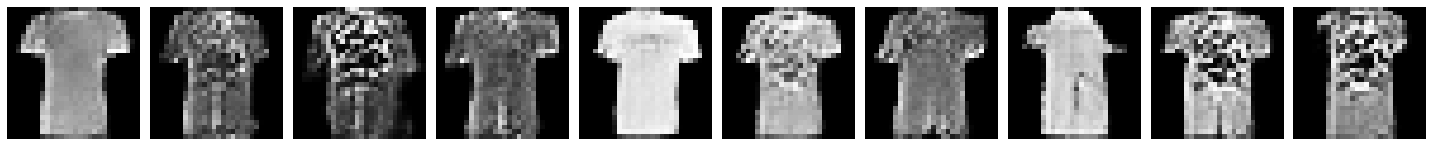

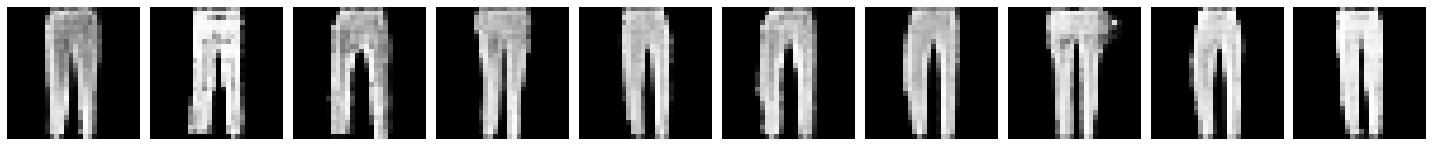

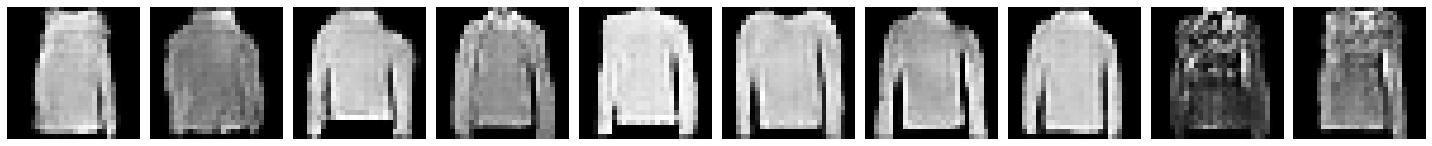

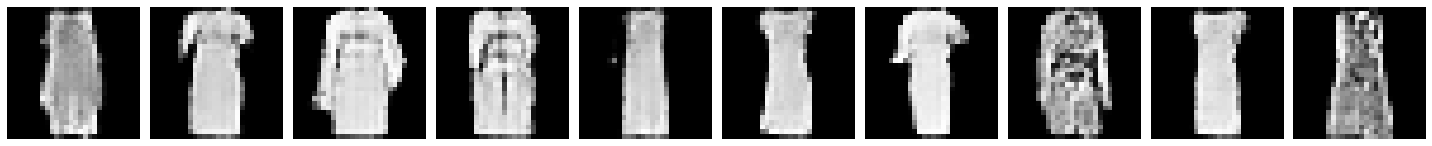

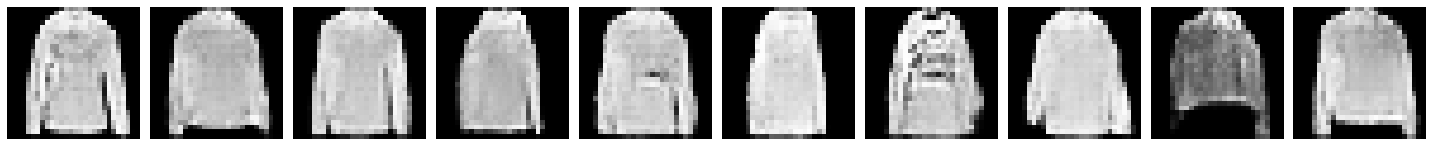

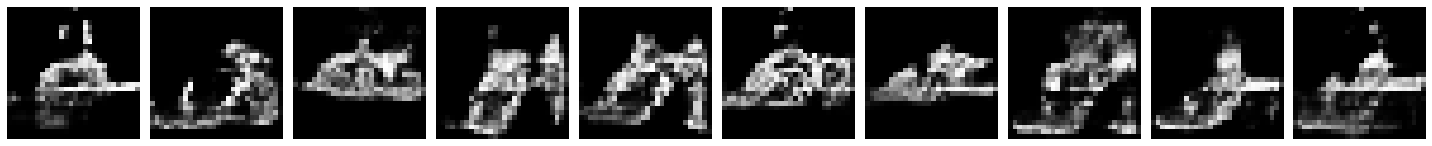

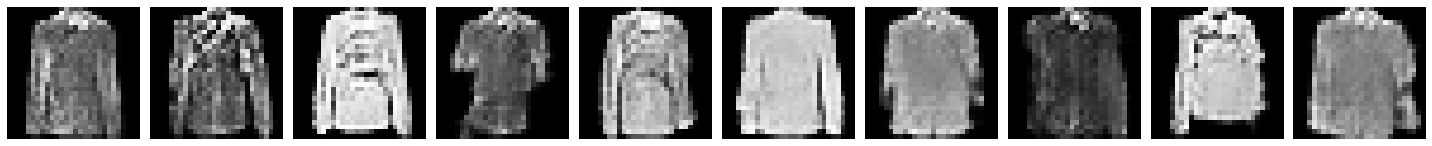

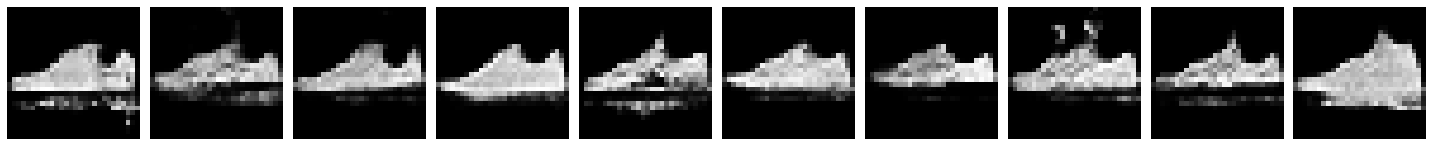

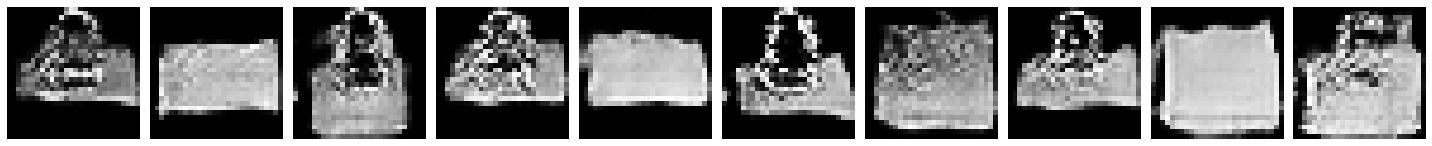

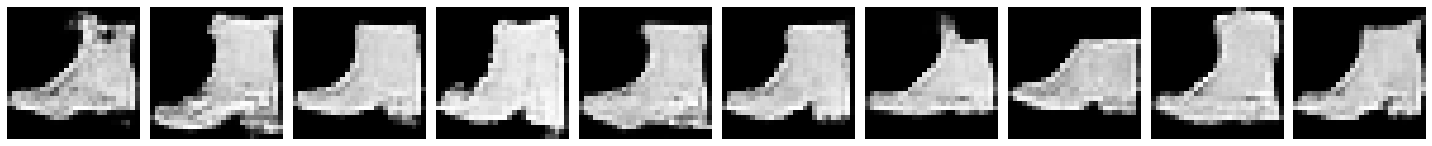

In [43]:
for i in range(num_classes):
    conditional_sample(conditional_gan_generator, 10, latent_dim, gray=True, fixed=False, label=i)

In [44]:
# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 500  

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = tfk.utils.to_categorical([first_number], num_classes)
    second_label = tfk.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (first_label * (1 - percent_second_label) + second_label * percent_second_label)

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = conditional_gan_generator.predict(noise_and_labels, verbose=0)
    return fake


start_class = 0  
end_class = 1  

fake_images = interpolate_class(start_class, end_class)

In [45]:
fake_images = interpolate_class(start_class, end_class)*127.5 + 127.5
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation01.gif", converted_images, fps=60)